# Kite Project - Orthogonal collocation

In [1]:
from casadi import *
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate

# Tuning Parameters

In [2]:
dt = 0.1
N = 50
simu_time=60#sec N=t/dt
X0init=[20/180*pi,30/180*pi,0]

In [3]:
t_f = 10                              # Time horizon
#N = 20                               # number of control intervals
A = 300                               # area of the kite in m^2
Length = 400                          # the length of the tether in m
E_0 = 5                               # base glide ratio [4,6]
v_m = 10                              # wind speed [8,12] in m s^-1
v_A = 0.8                             # amplitude [0,1] in m s^-1
v_f = 0.08                            # frequency [0.05, 0.15] in s^-1
v_off = pi                            # offset [0,2*pi] in rad
c_hat = 0.028                         # related correction coefficient
betha = 0                             # β the relation between the orientation of the boat and the direction of the wind in rad
rhu = 1                               # ρ air density in kg m^-3
w_F = 1e-4                            # the weigth for the tension
w_u = 0.5                             # punishes changes in control input to obtain a smooth behavior


In [4]:
# -----------------------------------------------------------------------------
# Declare model variables
# -----------------------------------------------------------------------------
x = SX.sym("x",3)                     # x_0 is zenith angle, theta   θ     [0, pi/2]
                                      # x_1 is azimuth angle, phi    φ     [-pi/2, pi/2]
                                      # x_2 is orientation, psi      ψ     [0,2pi]
                                      # x_3 is  time
u = SX.sym('u')                       # u is control input, [-10,10] in N
t = SX.sym('t')

In [5]:
v_0 = v_m + v_A*sin(2*pi*v_f*t+v_off)  #equation 1e
E = E_0 - c_hat*(u)**2    #equation 1f
v_a = v_0*E*cos(x[0])      #euqation 1d
P_D = rhu*(v_0**2)/2       #equation 1g
T_F = P_D*A*(cos(x[0])**2)*(E+1)*sqrt(E**2+1)*(cos(x[0])*cos(betha)+sin(x[0])*sin(betha)*sin(x[1])) #equation 1h
x_0_dot = v_a/Length*(cos(x[2])-tan(x[0])/E)     #equation 1a
x_1_dot = -v_a/(Length*sin(x[0]))*sin(x[2])      #equation 1b
x_2_dot = v_a/Length*u+(-v_a/(Length*sin(x[0]))*sin(x[2]))*cos(x[0])    #equation 1c


xdot = vertcat(x_0_dot, x_1_dot, x_2_dot)
Tf = Function("Tf",[x,u,t],[T_F])
system = Function("sys",[x,u,t],[xdot])
h_x = Length*sin(x[0])*cos(x[1])

In [6]:
ode = {'x': x, 'ode': xdot, 'p': vertcat(t,u)}
opts = {'tf': dt}
ode_solver = integrator('F', 'idas', ode, opts)

# OC Part

In [7]:

def L(tau_col, tau, j):
    l = 1
    for k in range(len(tau_col)):
        if k!=j:
            l *= (tau-tau_col[k])/(tau_col[j]-tau_col[k]) 
    return l
def LgrInter(tau_col, tau, xk):
    z = 0
    for j in range(K):
        z += L(tau_col, tau, j)*xk[j,:]
        
    return z


In [8]:
# collocation degree
K = 3

tau_col = collocation_points(K,'radau')
tau_col = [0]+tau_col
tau = SX.sym('tau')

A = np.zeros((K+1,K+1))

for j in range(K+1):
    dLj = gradient(L(tau_col, tau, j), tau)
    dLj_fcn = Function('dLj_fcn', [tau], [dLj])
    for k in range(K+1):
        A[j,k] = dLj_fcn(tau_col[k])
        

In [9]:
D = np.zeros((K+1,1))

for j in range(K+1):
    Lj = L(tau_col, tau, j)
    Lj_fcn = Function('Lj', [tau], [Lj])
    D[j] = Lj_fcn(1)


# MPC Part

In [10]:
wf=1e-4
wu=0.5

ul= SX.sym('ul', 1)
u= SX.sym('u', 1)
t= SX.sym('t', 1)
x= SX.sym('x', 3)

stage_cost = -wf*Tf(x,u,t)+wu*(u-ul)**2
stage_cost_fcn = Function('stage_cost',[x,u,ul,t],[stage_cost])


In [11]:
# state constraints
lb_x = np.asarray([[0,-np.pi/2,0]]).T
ub_x = np.asarray([[np.pi/2,np.pi/2,2*np.pi]]).T
# input constraints
lb_u = -10*np.ones((1,1))
ub_u = 10*np.ones((1,1))

In [12]:
from casadi.tools import *

In [13]:
opt_x = struct_symSX([
    entry('x', shape=3, repeat=[N+1, K+1]),
    entry('u', shape=1, repeat=[N])
])
lb_opt_x = opt_x(0)
ub_opt_x = opt_x(0)
lb_opt_x['x'] = lb_x
ub_opt_x['x'] = ub_x

lb_opt_x['u'] = lb_u
ub_opt_x['u'] = ub_u

In [14]:
p_constraint=[]
for P in opt_x['x']:
    for p in P:
       p_constraint.append(Length*sin(p[0])*cos(p[1]))

In [15]:
wu=0.5
J = 0
g = []    # constraint expression g
lb_g = []  # lower bound for constraint expression g
ub_g = []  # upper bound for constraint expression g

x_init = SX.sym('x_init', 3)

x0 = opt_x['x', 0, 0]
t= SX.sym('t', 1)
ul= SX.sym('ul', 1)
g.append(x0-x_init)
lb_g.append(np.zeros((3,1)))
ub_g.append(np.zeros((3,1)))

for i in range(N):
    if(i==0):
        J += stage_cost_fcn(opt_x['x',i,0], opt_x['u',i],ul,t) + wu*(opt_x['u',i]-ul)**2
    else:
        J += stage_cost_fcn(opt_x['x',i,0], opt_x['u',i],opt_x['u',i-1],t) + wu*(opt_x['u',i]-opt_x['u',i-1])**2
    for k in range(1,K+1):
        gk = -dt*system(opt_x['x',i,k], opt_x['u',i],t)
        for j in range(K+1):
            gk += A[j,k]*opt_x['x',i,j]
        g.append(gk)
        g.append(Length*sin(opt_x['x',i,k][0])*cos(opt_x['x',i,k][1]))
        lb_g.append(np.zeros((3,1)))
        lb_g.append(150*np.ones((1,1)))
        ub_g.append(np.zeros((3,1))) 
        ub_g.append(Length*np.ones((1,1))) 

    x_next = horzcat(*opt_x['x',i])@D
    g.append(x_next - opt_x['x', i+1, 0])
    lb_g.append(np.zeros((3,1)))
    ub_g.append(np.zeros((3,1)))

g = vertcat(*g)
lb_g = vertcat(*lb_g)
ub_g = vertcat(*ub_g)

prob = {'f':J,'x':vertcat(opt_x),'g':g, 'p':vertcat(x_init,t,ul)}
mpc_solver = nlpsol('solver','ipopt',prob)



# Optimization test&Visualization

In [16]:
# Define the initial condition
i=0
x_0 = np.array(X0init).reshape(3,1)
mpc_res = mpc_solver(x0=np.ones(lb_opt_x.shape),p=vertcat(x_0,i*dt,0), lbg=lb_g, ubg=ub_g, lbx = lb_opt_x, ubx = ub_opt_x)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     3153
Number of nonzeros in inequality constraint Jacobian.:      300
Number of nonzeros in Lagrangian Hessian.............:     1249

Total number of variables............................:      662
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      662
                     variables with only upper bounds:        0
Total number of equa

Text(0.5, 0, 'time')

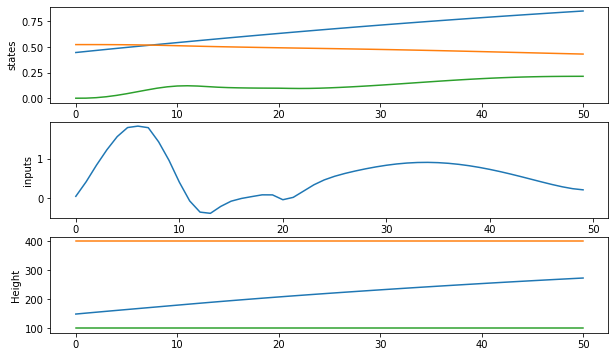

In [17]:
opt_x_k = opt_x(mpc_res['x'])
X_k = horzcat(*opt_x_k['x',:,0,:])
U_k = horzcat(*opt_x_k['u',:])
fig, ax = plt.subplots(3,1, figsize=(10,6))

h=Length*sin(horzcat(*opt_x_k['x',:,0,:])[0,:])*cos(horzcat(*opt_x_k['x',:,0,:])[1,:])
# plot the states
ax[0].plot(X_k.T)
ax[1].plot(U_k.T)
ax[2].plot(h.T)
ax[2].plot(Length*np.ones(h.T.shape))
ax[2].plot(100*np.ones(h.T.shape))
# Set labels
ax[0].set_ylabel('states')
ax[1].set_ylabel('inputs')
ax[2].set_ylabel('Height')
ax[1].set_xlabel('time')

# MPC Loop

In [18]:
# Define the initial state
x_0 = np.array(X0init).reshape(3,1)
# Initialize result lists for states and inputs
res_x_mpc = [x_0]
res_u_mpc = []

# Set number of iterations
N_sim = int(simu_time/dt)

In [19]:
for i in range(N_sim):

    mpc_res = mpc_solver(x0=opt_x_k,p=vertcat(x_0,i*dt,0), lbg=lb_g, ubg=ub_g, lbx = lb_opt_x, ubx = ub_opt_x)
    if i>0:
        mpc_res = mpc_solver(p=vertcat(x_0,i*dt,ui), x0=opt_x_k, lbg=lb_g, ubg=ub_g, lbx = lb_opt_x, ubx = ub_opt_x)
        
    opt_x_k = opt_x(mpc_res['x'])
    u_k = opt_x_k['u',0]
    ui=u_k
  
    res_integrator = ode_solver(x0=x_0, p=u_k)
    x_next = res_integrator['xf']

    x_0 = x_next

    res_x_mpc.append(x_next)
    res_u_mpc.append(u_k)

res_x_mpc = np.concatenate(res_x_mpc,axis=1)
res_u_mpc = np.concatenate(res_u_mpc, axis=1)


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     3153
Number of nonzeros in inequality constraint Jacobian.:      300
Number of nonzeros in Lagrangian Hessian.............:     1249

Total number of variables............................:      662
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      662
                     variables with only upper bounds:        0
Total number of equality constraints.................:      603
Total number of inequality constraints...............:      150
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      150
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -

  17r-1.1118698e+003 8.64e-002 2.05e-003  -1.7 5.19e-001    -  1.00e+000 1.00e+000h  1
  18r-1.1124993e+003 8.64e-002 1.81e+000  -3.8 8.31e-001    -  9.21e-001 9.60e-001f  1
  19r-1.1137488e+003 8.64e-002 3.15e-003  -3.8 4.09e-001    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20r-1.1138585e+003 8.64e-002 3.53e-004  -3.8 2.70e-001    -  1.00e+000 1.00e+000h  1
  21r-1.1138605e+003 8.64e-002 2.21e-005  -3.8 5.35e-002    -  1.00e+000 1.00e+000h  1
  22r-1.1139838e+003 8.64e-002 4.07e-003  -5.7 2.67e-001    -  9.95e-001 1.00e+000f  1
  23r-1.1135517e+003 8.64e-002 3.44e-004  -5.7 2.09e-001    -  1.00e+000 1.00e+000h  1
  24r-1.1135489e+003 8.64e-002 3.12e-007  -5.7 7.41e-003    -  1.00e+000 1.00e+000h  1
  25r-1.1135874e+003 8.64e-002 7.74e-004  -8.6 3.53e-002    -  9.99e-001 1.00e+000h  1
  26r-1.1134772e+003 8.64e-002 1.28e-005  -8.6 4.02e-002    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 26

                  

  19r-1.1060107e+003 7.56e-002 2.51e-003  -3.8 3.69e-001    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20r-1.1061123e+003 7.56e-002 2.88e-004  -3.8 1.93e-001    -  1.00e+000 1.00e+000h  1
  21r-1.1060845e+003 7.56e-002 1.57e-005  -3.8 4.36e-002    -  1.00e+000 1.00e+000h  1
  22r-1.1062873e+003 7.56e-002 3.90e-003  -5.7 1.99e-001    -  9.96e-001 1.00e+000f  1
  23r-1.1057003e+003 7.56e-002 3.11e-004  -5.7 1.99e-001    -  1.00e+000 1.00e+000h  1
  24r-1.1056998e+003 7.56e-002 1.24e-007  -5.7 5.07e-003    -  1.00e+000 1.00e+000h  1
  25r-1.1057527e+003 7.56e-002 7.36e-004  -8.6 2.57e-002    -  9.99e-001 1.00e+000h  1
  26r-1.1056172e+003 7.56e-002 1.16e-005  -8.6 3.84e-002    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 26

                                   (scaled)                 (unscaled)
Objective...............: -1.1056172361329600e+003  -1.1056172361329600e+003
Dual infeasibility......:  5.206554731342650

  24r-1.0975310e+003 6.49e-002 1.03e-005  -8.6 3.62e-002    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 24

                                   (scaled)                 (unscaled)
Objective...............: -1.0975309144487035e+003  -1.0975309144487035e+003
Dual infeasibility......:  5.1604602687385821e+001   5.1604602687385821e+001
Constraint violation....:  6.4901693624346113e-002   6.4901693624346113e-002
Complementarity.........:  2.5059569988504702e-009   2.5059569988504702e-009
Overall NLP error.......:  5.1604602687385821e+001   5.1604602687385821e+001


Number of objective function evaluations             = 61
Number of objective gradient evaluations             = 11
Number of equality constraint evaluations            = 61
Number of inequality constraint evaluations          = 61
Number of equality constraint Jacobian evaluations   = 30
Number of inequality constraint Jacobian evaluations = 30
Number of Lagrangian Hessian evaluations             = 25
Total CPU secs in 

   7 -1.0863784e+003 4.37e-002 3.01e+004  -1.0 1.14e+001    -  4.53e-001 1.52e-005h  1
   8r-1.0863784e+003 4.37e-002 9.99e+002  -1.0 0.00e+000    -  0.00e+000 3.50e-007R 10
   9r-1.0862456e+003 4.37e-002 9.78e+002  -1.0 4.30e+000    -  4.01e-001 1.93e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10r-1.0828261e+003 4.38e-002 8.45e+002  -1.0 1.35e+000    -  3.41e-001 1.37e-001f  1
  11r-1.0801955e+003 4.37e-002 3.60e+002  -1.0 1.34e+000    -  9.20e-001 5.74e-001f  1
  12r-1.0744612e+003 4.38e-002 1.09e-001  -1.0 1.13e+000    -  1.00e+000 1.00e+000f  1
  13r-1.0788991e+003 4.37e-002 1.05e-001  -1.7 9.59e-001    -  1.00e+000 1.00e+000f  1
  14r-1.0817663e+003 4.37e-002 3.14e-002  -2.5 5.46e-001    -  1.00e+000 1.00e+000f  1
  15r-1.0819420e+003 4.37e-002 9.92e-004  -2.5 1.15e-001    -  1.00e+000 1.00e+000h  1
  16r-1.0828266e+003 4.37e-002 2.05e-001  -5.7 4.35e-001    -  9.43e-001 9.97e-001f  1
  17r-1.0815856e+003 4.37e-002 2.65e-003  -5.7 2.

    nlp_grad  |        0 (       0)        0 (       0)         1
  nlp_grad_f  |        0 (       0)        0 (       0)        11
  nlp_hess_l  |  10.00ms (500.00us)  10.05ms (502.70us)        20
   nlp_jac_g  |   2.00ms ( 71.43us)   2.02ms ( 72.14us)        28
       total  |  78.00ms ( 78.00ms)  77.80ms ( 77.80ms)         1
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     3153
Number of nonzeros in inequality constraint Jacobian.:      300
Number of nonzeros in Lagrangian Hessian.............:     1249

Total number of variables............................:      662
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      662
                     variables with only upper bounds:        0
Total number of equality constraints.................:      603
Total number o

Number of inequality constraint Jacobian evaluations = 27
Number of Lagrangian Hessian evaluations             = 23
Total CPU secs in IPOPT (w/o function evaluations)   =      0.068
Total CPU secs in NLP function evaluations           =      0.015

EXIT: Converged to a point of local infeasibility. Problem may be infeasible.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)        0 (       0)        59
       nlp_g  |   5.00ms ( 84.75us)   4.99ms ( 84.53us)        59
    nlp_grad  |        0 (       0)        0 (       0)         1
  nlp_grad_f  |        0 (       0)        0 (       0)        12
  nlp_hess_l  |   6.00ms (300.00us)   5.98ms (299.15us)        20
   nlp_jac_g  |   4.00ms (142.86us)   3.99ms (142.46us)        28
       total  |  85.00ms ( 85.00ms)  84.77ms ( 84.77ms)         1
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Nu

Total number of variables............................:      662
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      662
                     variables with only upper bounds:        0
Total number of equality constraints.................:      603
Total number of inequality constraints...............:      150
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      150
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -1.0539130e+003 1.89e-002 4.87e+001  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 -1.0643280e+003 4.72e-001 1.58e+001  -1.0 1.35e+000    -  8.80e-001 6.75e-001f  1
   2 -1.0644369e+003 4.77e-001 9.40e+001  -1.0 1.01e+000    -  9.98e-001 2.06e-002h  1
   3 -1.0644350e+003 4.77e-001 1.70e+004  -1.0 8.19e+001    -  1.03e-001 7.37e-00

Total number of variables............................:      662
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      662
                     variables with only upper bounds:        0
Total number of equality constraints.................:      603
Total number of inequality constraints...............:      150
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      150
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -1.0355014e+003 9.74e-003 4.77e+001  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 -1.0190077e+003 1.12e-006 5.10e+000  -1.0 9.80e-001    -  4.70e-001 1.00e+000H  1
   2 -1.0174287e+003 9.88e-007 8.30e-001  -1.0 1.18e+000    -  8.99e-001 1.00e+000F  1
   3 -1.0164402e+003 9.94e-008 9.78e-002  -1.0 8.03e-001    -  1.00e+000 1.00e+00

   1 -9.7623004e+002 6.43e-008 6.65e-001  -1.0 9.46e-001    -  7.60e-001 1.00e+000H  1
   2 -9.7502319e+002 5.61e-007 1.36e-001  -1.0 8.45e-001    -  9.75e-001 1.00e+000F  1
   3 -9.7562065e+002 1.31e-004 8.81e-002  -1.7 8.49e-001    -  9.86e-001 1.00e+000f  1
   4 -9.7588594e+002 1.01e-004 7.51e-002  -2.5 6.42e-001    -  1.00e+000 1.00e+000h  1
   5 -9.7647015e+002 8.66e-006 7.47e-003  -2.5 1.36e-001    -  1.00e+000 1.00e+000h  1
   6 -9.7652552e+002 2.21e-006 1.99e-003  -3.8 6.98e-002    -  1.00e+000 1.00e+000h  1
   7 -9.7654370e+002 7.19e-009 6.71e-006  -3.8 4.04e-003    -  1.00e+000 1.00e+000h  1
   8 -9.7654373e+002 6.39e-009 5.91e-006  -5.7 3.79e-003    -  1.00e+000 1.00e+000h  1
   9 -9.7654378e+002 1.56e-012 1.44e-009  -8.6 5.92e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 9

                                   (scaled)                 (unscaled)
Objective...............: -9.7654377939107110e+002  -9.7654377939107110e+002
Dual infeasibility......:  1.4426528200

   4 -9.2527343e+002 1.24e-005 7.74e-003  -2.5 2.87e-001    -  1.00e+000 1.00e+000h  1
   5 -9.2532805e+002 5.81e-007 3.83e-004  -3.8 6.33e-002    -  1.00e+000 1.00e+000h  1
   6 -9.2533102e+002 2.22e-009 1.48e-006  -5.7 3.95e-003    -  1.00e+000 1.00e+000h  1
   7 -9.2533103e+002 2.01e-013 1.34e-010  -8.6 4.28e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............: -9.2533102919969508e+002  -9.2533102919969508e+002
Dual infeasibility......:  1.3380960207264852e-010   1.3380960207264852e-010
Constraint violation....:  2.0100587860838459e-013   2.0100587860838459e-013
Complementarity.........:  2.5158308023062183e-009   2.5158308023062183e-009
Overall NLP error.......:  2.5158308023062183e-009   2.5158308023062183e-009


Number of objective function evaluations             = 10
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations        

   7 -8.7757995e+002 2.61e-014 1.43e-011  -8.6 2.77e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............: -8.7757995146121732e+002  -8.7757995146121732e+002
Dual infeasibility......:  1.4269854939562120e-011   1.4269854939562120e-011
Constraint violation....:  2.6062485503075550e-014   2.6062485503075550e-014
Complementarity.........:  2.5087448343529809e-009   2.5087448343529809e-009
Overall NLP error.......:  2.5087448343529809e-009   2.5087448343529809e-009


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 8
Number of inequality constraint evaluations          = 8
Number of equality constraint Jacobian evaluations   = 8
Number of inequality constraint Jacobian evaluations = 8
Number of Lagrangian Hessian evaluations             = 7
Total CPU secs in IPOPT (w

                     variables with only lower bounds:        0
                variables with lower and upper bounds:      662
                     variables with only upper bounds:        0
Total number of equality constraints.................:      603
Total number of inequality constraints...............:      150
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      150
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -8.3165348e+002 4.02e-002 4.43e+001  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 -8.4832911e+002 5.76e-003 3.18e+000  -1.0 2.91e+000    -  6.15e-001 1.00e+000f  1
   2 -8.4755628e+002 5.61e-005 2.20e-002  -1.0 2.75e-001    -  9.87e-001 1.00e+000h  1
   3 -8.4781306e+002 3.15e-005 1.18e-002  -1.7 1.06e+000    -  1.00e+000 1.00e+000h  1
   4 -8.4781293e+002 1.47e-006 9.11e-004  -3.8 2.72e-001  

   nlp_jac_g  |   1.00ms (125.00us) 998.00us (124.75us)         8
       total  |  21.00ms ( 21.00ms)  20.94ms ( 20.94ms)         1
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     3153
Number of nonzeros in inequality constraint Jacobian.:      300
Number of nonzeros in Lagrangian Hessian.............:     1249

Total number of variables............................:      662
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      662
                     variables with only upper bounds:        0
Total number of equality constraints.................:      603
Total number of inequality constraints...............:      150
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      150
        inequality c

       nlp_g  |   1.00ms (142.86us)   1.03ms (147.43us)         7
    nlp_grad  |        0 (       0)        0 (       0)         1
  nlp_grad_f  |        0 (       0)        0 (       0)         8
  nlp_hess_l  |   1.00ms (166.67us) 996.00us (166.00us)         6
   nlp_jac_g  |        0 (       0)        0 (       0)         8
       total  |  21.00ms ( 21.00ms)  20.97ms ( 20.97ms)         1
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     3153
Number of nonzeros in inequality constraint Jacobian.:      300
Number of nonzeros in Lagrangian Hessian.............:     1249

Total number of variables............................:      662
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      662
                     variables with only upper bounds:        0
Total number

   5 -9.7858784e+002 1.52e-011 1.05e-008  -5.7 6.97e-004    -  1.00e+000 1.00e+000h  1
   6 -9.7858784e+002 3.55e-015 8.90e-013  -8.6 5.19e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 6

                                   (scaled)                 (unscaled)
Objective...............: -9.7858784489002858e+002  -9.7858784489002858e+002
Dual infeasibility......:  8.9043422874874769e-013   8.9043422874874769e-013
Constraint violation....:  3.5527136788005009e-015   3.5527136788005009e-015
Complementarity.........:  2.5067785514144684e-009   2.5067785514144684e-009
Overall NLP error.......:  2.5067785514144684e-009   2.5067785514144684e-009


Number of objective function evaluations             = 7
Number of objective gradient evaluations             = 7
Number of equality constraint evaluations            = 7
Number of inequality constraint evaluations          = 7
Number of equality constraint Jacobian evaluations   = 7
Number of inequality constraint Jacobian evaluations 

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     3153
Number of nonzeros in inequality constraint Jacobian.:      300
Number of nonzeros in Lagrangian Hessian.............:     1249

Total number of variables............................:      662
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      662
                     variables with only upper bounds:        0
Total number of equality constraints.................:      603
Total number of inequality constraints...............:      150
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      150
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -

   2 -1.1711905e+003 2.83e-005 1.57e-001  -1.0 2.97e-001    -  9.93e-001 1.00e+000h  1
   3 -1.1714157e+003 8.39e-007 1.33e-003  -1.7 7.54e-002    -  1.00e+000 1.00e+000f  1
   4 -1.1714368e+003 1.82e-007 1.18e-002  -3.8 2.55e-002    -  1.00e+000 9.42e-001h  1
   5 -1.1714364e+003 5.09e-010 3.23e-006  -3.8 1.38e-003    -  1.00e+000 1.00e+000h  1
   6 -1.1714365e+003 8.20e-012 5.30e-008  -5.7 1.87e-004    -  1.00e+000 1.00e+000h  1
   7 -1.1714365e+003 3.55e-015 8.19e-012  -8.6 2.31e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............: -1.1714365055175811e+003  -1.1714365055175811e+003
Dual infeasibility......:  8.1915611785583244e-012   8.1915611785583244e-012
Constraint violation....:  3.5527136788005009e-015   3.5527136788005009e-015
Complementarity.........:  2.5094453407586398e-009   2.5094453407586398e-009
Overall NLP error.......:  2.5094453407586398e-009   2.50944534075863

   7 -1.2228791e+003 1.19e-011 6.61e-008  -5.7 2.68e-004    -  1.00e+000 1.00e+000h  1
   8 -1.2228791e+003 3.55e-015 9.60e-012  -8.6 3.32e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 8

                                   (scaled)                 (unscaled)
Objective...............: -1.2228790954638600e+003  -1.2228790954638600e+003
Dual infeasibility......:  9.6032447664760857e-012   9.6032447664760857e-012
Constraint violation....:  3.5527136788005009e-015   3.5527136788005009e-015
Complementarity.........:  2.5093147210373435e-009   2.5093147210373435e-009
Overall NLP error.......:  2.5093147210373435e-009   2.5093147210373435e-009


Number of objective function evaluations             = 9
Number of objective gradient evaluations             = 9
Number of equality constraint evaluations            = 9
Number of inequality constraint evaluations          = 9
Number of equality constraint Jacobian evaluations   = 9
Number of inequality constraint Jacobian evaluations 

   4 -1.2737685e+003 4.15e-006 2.70e-001  -2.5 2.48e-001    -  1.00e+000 7.68e-001f  1
   5 -1.2737827e+003 4.22e-007 1.30e-002  -2.5 5.90e-002    -  1.00e+000 1.00e+000h  1
   6 -1.2737864e+003 5.21e-009 1.51e-004  -3.8 6.65e-003    -  1.00e+000 1.00e+000h  1
   7 -1.2737866e+003 1.77e-011 4.33e-007  -5.7 3.85e-004    -  1.00e+000 1.00e+000h  1
   8 -1.2737866e+003 5.33e-015 6.29e-011  -8.6 4.75e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 8

                                   (scaled)                 (unscaled)
Objective...............: -1.2737865575443391e+003  -1.2737865575443391e+003
Dual infeasibility......:  6.2856437897451009e-011   6.2856437897451009e-011
Constraint violation....:  5.3290705182007514e-015   5.3290705182007514e-015
Complementarity.........:  2.5101808372440122e-009   2.5101808372440122e-009
Overall NLP error.......:  2.5101808372440122e-009   2.5101808372440122e-009


Number of objective function evaluations             = 9
Number of objective 

Total number of variables............................:      662
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      662
                     variables with only upper bounds:        0
Total number of equality constraints.................:      603
Total number of inequality constraints...............:      150
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      150
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -1.3220041e+003 2.02e-002 5.22e+001  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 -1.3229378e+003 2.53e-001 9.14e+000  -1.0 8.17e-001    -  9.32e-001 8.25e-001H  1
   2 -1.3223062e+003 3.71e-006 7.55e-001  -1.0 2.09e-001    -  1.00e+000 1.00e+000h  1
   3 -1.3228703e+003 6.85e-006 5.27e-002  -1.7 3.32e-001    -  1.00e+000 9.19e-00

   8 -1.3549119e+003 1.24e-014 5.24e-010  -8.6 1.16e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 8

                                   (scaled)                 (unscaled)
Objective...............: -1.3549118724212651e+003  -1.3549118724212651e+003
Dual infeasibility......:  5.2434761364831820e-010   5.2434761364831820e-010
Constraint violation....:  1.2434497875801753e-014   1.2434497875801753e-014
Complementarity.........:  2.5187236274543930e-009   2.5187236274543930e-009
Overall NLP error.......:  2.5187236274543930e-009   2.5187236274543930e-009


Number of objective function evaluations             = 10
Number of objective gradient evaluations             = 9
Number of equality constraint evaluations            = 10
Number of inequality constraint evaluations          = 10
Number of equality constraint Jacobian evaluations   = 9
Number of inequality constraint Jacobian evaluations = 9
Number of Lagrangian Hessian evaluations             = 8
Total CPU secs in IPOPT

   3 -1.3884603e+003 6.78e-006 3.76e-001  -1.7 3.82e-001    -  1.00e+000 7.35e-001f  1
   4 -1.3885758e+003 1.61e-006 1.27e-001  -1.7 1.48e-001    -  1.00e+000 1.00e+000f  1
   5 -1.3886694e+003 1.81e-004 1.12e-001  -2.5 1.87e-001    -  1.00e+000 9.45e-001f  1
   6 -1.3886767e+003 4.21e-008 3.30e-003  -2.5 2.19e-002    -  1.00e+000 1.00e+000f  1
   7 -1.3886811e+003 8.35e-008 4.24e-003  -3.8 3.28e-002    -  1.00e+000 1.00e+000h  1
   8 -1.3886813e+003 1.64e-011 1.70e-006  -3.8 4.00e-004    -  1.00e+000 1.00e+000h  1
   9 -1.3886814e+003 2.71e-010 1.40e-005  -5.7 1.86e-003    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 -1.3886814e+003 4.71e-014 2.58e-009  -8.6 2.44e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 10

                                   (scaled)                 (unscaled)
Objective...............: -1.3886814347493066e+003  -1.3886814347493066e+003
Dual infeasibility......:  2.576092703359085

   6 -1.4110070e+003 1.14e-007 1.12e-002  -2.5 3.70e-002    -  1.00e+000 1.00e+000h  1
   7 -1.4110320e+003 5.85e-005 4.05e-002  -3.8 9.72e-002    -  1.00e+000 9.38e-001f  1
   8 -1.4110364e+003 9.23e-008 8.82e-003  -3.8 3.29e-002    -  1.00e+000 1.00e+000f  1
   9 -1.4110369e+003 3.14e-009 4.21e-004  -3.8 5.94e-003    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 -1.4110373e+003 1.00e-006 1.13e-003  -5.7 1.19e-002    -  1.00e+000 9.92e-001h  1
  11 -1.4110373e+003 1.42e-010 2.11e-005  -5.7 1.27e-003    -  1.00e+000 1.00e+000f  1
  12 -1.4110373e+003 3.34e-014 6.25e-009  -5.7 1.92e-005    -  1.00e+000 1.00e+000h  1
  13 -1.4110373e+003 2.57e-012 2.78e-007  -8.6 1.76e-004    -  1.00e+000 1.00e+000h  1
  14 -1.4110373e+003 1.78e-015 1.27e-012  -8.6 2.86e-007    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 14

                                   (scaled)                 (unscaled)
Objective...............: -1.41103

In iteration 13, 1 Slack too small, adjusting variable bound
  14 -1.4221496e+003 4.35e-012 8.86e-004  -8.6 2.35e-004    -  9.93e-001 9.81e-001h  1
  15 -1.4221496e+003 3.48e-014 1.67e-008  -8.6 1.87e-005    -  1.00e+000 1.00e+000h  1
  16 -1.4221496e+003 4.44e-015 4.61e-012  -9.0 2.91e-007    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 16

                                   (scaled)                 (unscaled)
Objective...............: -1.4221495601615088e+003  -1.4221495601615088e+003
Dual infeasibility......:  4.6146991382794235e-012   4.6146991382794235e-012
Constraint violation....:  4.4408920985006262e-015   4.4408920985006262e-015
Complementarity.........:  9.0928135980015321e-010   9.0928135980015321e-010
Overall NLP error.......:  9.0928135980015321e-010   9.0928135980015321e-010


Number of objective function evaluations             = 17
Number of objective gradient evaluations             = 17
Number of equality constraint evaluations            = 17
Number of inequ

  10 -1.4287657e+003 6.86e-010 3.27e-003  -5.7 2.06e-003    -  9.96e-001 1.00e+000f  1
  11 -1.4287657e+003 1.18e-011 7.16e-006  -5.7 3.17e-004    -  1.00e+000 1.00e+000h  1
In iteration 11, 1 Slack too small, adjusting variable bound
  12 -1.4287657e+003 1.94e-012 3.13e-004  -8.6 1.17e-004    -  9.99e-001 9.92e-001h  1
  13 -1.4287657e+003 2.66e-015 1.95e-009  -8.6 4.37e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 13

                                   (scaled)                 (unscaled)
Objective...............: -1.4287657218049349e+003  -1.4287657218049349e+003
Dual infeasibility......:  1.9521207413944028e-009   1.9521207413944028e-009
Constraint violation....:  2.6645352591003757e-015   2.6645352591003757e-015
Complementarity.........:  2.5643433546099289e-009   2.5643433546099289e-009
Overall NLP error.......:  2.5643433546099289e-009   2.5643433546099289e-009


Number of objective function evaluations             = 14
Number of objective gradient evaluations    

   8 -1.4256920e+003 1.48e-007 4.05e+000  -3.8 3.22e-002    -  3.63e-001 1.00e+000f  1
   9 -1.4256942e+003 6.67e-008 2.40e-001  -3.8 6.68e-003    -  1.00e+000 9.18e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 -1.4256942e+003 4.66e-010 7.37e-004  -3.8 2.38e-003    -  1.00e+000 1.00e+000f  1
  11 -1.4256948e+003 2.09e-009 2.29e-001  -5.7 6.75e-003    -  9.83e-001 7.18e-001f  1
  12 -1.4256949e+003 7.10e-010 2.50e-004  -5.7 2.23e-003    -  1.00e+000 1.00e+000f  1
  13 -1.4256949e+003 3.55e-015 7.76e-010  -5.7 5.61e-006    -  1.00e+000 1.00e+000h  1
In iteration 13, 1 Slack too small, adjusting variable bound
  14 -1.4256949e+003 9.13e-013 7.52e-005  -8.6 8.12e-005    -  1.00e+000 9.95e-001f  1
  15 -1.4256949e+003 2.66e-015 1.71e-011  -8.6 5.63e-007    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 15

                                   (scaled)                 (unscaled)
Objective...............: -1.4256948620388259e+003  -1.42569

Overall NLP error.......:  2.5105645059025539e-009   2.5105645059025539e-009


Number of objective function evaluations             = 17
Number of objective gradient evaluations             = 17
Number of equality constraint evaluations            = 17
Number of inequality constraint evaluations          = 17
Number of equality constraint Jacobian evaluations   = 17
Number of inequality constraint Jacobian evaluations = 17
Number of Lagrangian Hessian evaluations             = 16
Total CPU secs in IPOPT (w/o function evaluations)   =      0.035
Total CPU secs in NLP function evaluations           =      0.011

EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)        0 (       0)        17
       nlp_g  |   2.00ms (117.65us)   1.99ms (117.29us)        17
    nlp_grad  |        0 (       0)        0 (       0)         1
  nlp_grad_f  |        0 (       0)        0 (       0)        18
  nlp_hess_l  |   7.00

   6 -1.3930555e+003 2.21e-007 1.37e-002  -2.5 6.03e-002    -  1.00e+000 1.00e+000f  1
   7 -1.3931315e+003 1.79e-007 2.51e-001  -3.8 5.30e-002    -  1.00e+000 5.95e-001f  1
   8 -1.3931533e+003 2.49e-007 2.98e-001  -3.8 4.76e-002    -  7.43e-001 8.17e-001f  1
   9 -1.3931573e+003 6.41e-008 8.25e-002  -3.8 1.95e-002    -  8.98e-001 7.83e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 -1.3931573e+003 8.62e-009 4.77e-003  -3.8 8.28e-003    -  1.00e+000 1.00e+000f  1
  11 -1.3931577e+003 3.93e-010 3.46e-004  -3.8 1.27e-003    -  1.00e+000 1.00e+000h  1
  12 -1.3931585e+003 6.71e-009 4.81e-001  -5.7 9.73e-003    -  1.00e+000 6.76e-001f  1
  13 -1.3931586e+003 2.54e-009 6.03e-004  -5.7 4.40e-003    -  1.00e+000 1.00e+000f  1
  14 -1.3931586e+003 2.31e-013 1.48e-007  -5.7 4.27e-005    -  1.00e+000 1.00e+000h  1
In iteration 14, 1 Slack too small, adjusting variable bound
  15 -1.3931586e+003 3.13e-012 1.15e-004  -8.6 1.53e-004    -  1.00e+000 9.

  15 -1.3841398e+003 4.02e-012 1.20e-006  -5.7 1.46e-004    -  1.00e+000 1.00e+000h  1
In iteration 15, 1 Slack too small, adjusting variable bound
  16 -1.3841398e+003 1.08e-011 6.84e-004  -8.6 3.44e-004    -  9.73e-001 9.98e-001h  1
  17 -1.3841398e+003 3.18e-014 7.60e-009  -8.6 1.28e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 17

                                   (scaled)                 (unscaled)
Objective...............: -1.3841398316872710e+003  -1.3841398316872710e+003
Dual infeasibility......:  7.6018931154103101e-009   7.6018931154103101e-009
Constraint violation....:  3.1835645231126364e-014   3.1835645231126364e-014
Complementarity.........:  3.1831808392939544e-009   3.1831808392939544e-009
Overall NLP error.......:  7.6018931154103101e-009   7.6018931154103101e-009


Number of objective function evaluations             = 18
Number of objective gradient evaluations             = 18
Number of equality constraint evaluations            = 18
Number of inequ

   4 -1.3613681e+003 8.41e-006 1.42e-001  -2.5 4.17e-001    -  1.00e+000 7.30e-001f  1
   5 -1.3616028e+003 2.57e-006 3.83e+000  -2.5 1.45e-001    -  1.55e-001 7.36e-001f  1
   6 -1.3616415e+003 3.10e-007 3.14e-002  -2.5 7.07e-002    -  1.00e+000 1.00e+000f  1
   7 -1.3616750e+003 1.05e-008 2.76e-003  -2.5 2.17e-002    -  1.00e+000 1.00e+000f  1
   8 -1.3617470e+003 1.88e-007 2.46e-001  -3.8 5.66e-002    -  1.00e+000 6.14e-001f  1
   9 -1.3617633e+003 2.07e-007 5.57e-001  -3.8 5.11e-002    -  6.98e-001 6.00e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 -1.3617717e+003 1.01e-007 2.68e-001  -3.8 3.03e-002    -  1.00e+000 6.57e-001f  1
  11 -1.3617738e+003 3.55e-008 7.39e-003  -3.8 1.73e-002    -  1.00e+000 1.00e+000f  1
  12 -1.3617744e+003 4.14e-010 3.04e-004  -3.8 1.42e-003    -  1.00e+000 1.00e+000h  1
  13 -1.3617755e+003 1.08e-008 8.11e-001  -5.7 1.46e-002    -  1.00e+000 6.55e-001f  1
  14 -1.3617758e+003 7.69e-009 1.36e-003  -5.7 8.

  12 -1.3332954e+003 1.80e-008 3.15e-001  -5.7 1.66e-002    -  6.14e-001 8.34e-001f  1
  13 -1.3332959e+003 1.28e-008 8.47e-001  -5.7 7.76e-003    -  9.07e-001 3.06e-001f  1
  14 -1.3332966e+003 8.57e-009 1.54e-003  -5.7 8.74e-003    -  1.00e+000 1.00e+000f  1
  15 -1.3332967e+003 3.00e-010 3.66e-005  -5.7 1.65e-003    -  1.00e+000 1.00e+000h  1
  16 -1.3332967e+003 1.43e-011 3.68e-006  -5.7 4.17e-004    -  1.00e+000 1.00e+000h  1
  17 -1.3332967e+003 2.32e-011 4.00e-002  -8.6 5.85e-004    -  1.00e+000 7.36e-001h  1
  18 -1.3332967e+003 1.04e-012 1.18e-004  -8.6 1.06e-004    -  9.96e-001 1.00e+000f  1
  19 -1.3332967e+003 3.55e-015 2.67e-011  -8.6 1.58e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 19

                                   (scaled)                 (unscaled)
Objective...............: -1.3332967041812221e+003  -1.3332967041812221e+003
Dual infeasibility......:  2.6749478897355314e-011   2.6749478897355314e-011
Constraint violation....:  3.5527136788005009e-0

   4 -1.3032667e+003 9.55e-006 3.26e-001  -2.5 4.61e-001    -  1.00e+000 7.48e-001f  1
   5 -1.3035143e+003 1.82e-006 1.39e-002  -2.5 1.37e-001    -  1.00e+000 1.00e+000f  1
   6 -1.3036200e+003 1.17e-006 7.79e-001  -3.8 9.19e-002    -  1.00e+000 4.67e-001f  1
   7 -1.3037026e+003 8.67e-007 4.84e+000  -3.8 8.36e-002    -  3.47e-001 8.19e-001f  1
   8 -1.3037228e+003 3.17e-007 1.65e+000  -3.8 2.84e-002    -  5.89e-001 6.48e-001f  1
   9 -1.3037327e+003 3.97e-008 7.14e+000  -3.8 1.89e-002    -  4.31e-001 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 -1.3037358e+003 1.02e-008 1.44e+000  -3.8 6.14e-003    -  1.00e+000 8.33e-001h  1
  11 -1.3037356e+003 2.93e-009 3.13e-003  -3.8 4.85e-003    -  1.00e+000 1.00e+000f  1
  12 -1.3037360e+003 3.87e-010 2.36e-004  -3.8 1.47e-003    -  1.00e+000 1.00e+000h  1
  13 -1.3037398e+003 7.98e-009 7.06e-001  -5.7 1.44e-002    -  9.90e-001 5.76e-001f  1
  14 -1.3037415e+003 6.61e-009 5.73e-001  -5.7 8.

  16 -1.2920240e+003 5.69e-012 3.16e-002  -8.6 3.45e-004    -  1.00e+000 7.20e-001h  1
In iteration 16, 1 Slack too small, adjusting variable bound
  17 -1.2920240e+003 5.72e-012 1.64e-003  -8.6 2.60e-004    -  9.53e-001 9.98e-001f  1
  18 -1.2920240e+003 4.81e-013 3.38e-008  -8.6 7.51e-005    -  1.00e+000 1.00e+000h  1
  19 -1.2920240e+003 2.17e-014 1.60e-009  -8.6 1.59e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 19

                                   (scaled)                 (unscaled)
Objective...............: -1.2920240373446611e+003  -1.2920240373446611e+003
Dual infeasibility......:  1.6037980071478521e-009   1.6037980071478521e-009
Constraint violation....:  2.1718737919229625e-014   2.1718737919229625e-014
Complementarity.........:  3.5976843768756855e-009   3.5976843768756855e-009
Overall NLP error.......:  3.5976843768756855e-009   3.5976843768756855e-009


Number of objective function evaluations             = 20
Number of objective gradient evaluations    

  12 -1.2598749e+003 4.69e-009 5.35e-001  -5.7 1.27e-002    -  8.49e-001 6.34e-001f  1
  13 -1.2598757e+003 1.30e-008 3.80e-001  -5.7 7.30e-003    -  5.61e-001 5.12e-001f  1
  14 -1.2598759e+003 3.72e-009 1.24e-002  -5.7 6.80e-003    -  1.00e+000 9.77e-001f  1
  15 -1.2598760e+003 8.47e-011 1.81e-005  -5.7 9.01e-004    -  1.00e+000 1.00e+000f  1
  16 -1.2598760e+003 3.35e-011 3.04e-002  -8.6 6.03e-004    -  9.82e-001 6.20e-001h  1
  17 -1.2598760e+003 6.92e-012 2.23e-004  -8.6 2.87e-004    -  9.96e-001 1.00e+000f  1
  18 -1.2598760e+003 2.66e-015 1.56e-011  -8.6 1.75e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 18

                                   (scaled)                 (unscaled)
Objective...............: -1.2598759921135115e+003  -1.2598759921135115e+003
Dual infeasibility......:  1.5613237035373383e-011   1.5613237035373383e-011
Constraint violation....:  2.6645352591003757e-015   2.6645352591003757e-015
Complementarity.........:  2.5152073987479315e-009   2.515

   9 -1.2206062e+003 4.49e-008 1.88e+000  -3.8 1.33e-002    -  3.95e-001 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 -1.2206049e+003 6.47e-009 2.03e-003  -3.8 4.25e-003    -  1.00e+000 1.00e+000h  1
  11 -1.2206052e+003 2.05e-010 3.64e-005  -3.8 1.24e-003    -  1.00e+000 1.00e+000h  1
  12 -1.2206102e+003 6.49e-009 8.23e-002  -5.7 1.26e-002    -  7.21e-001 6.70e-001f  1
  13 -1.2206109e+003 1.09e-008 1.09e-001  -5.7 1.17e-002    -  8.26e-001 9.86e-001f  1
  14 -1.2206111e+003 2.33e-009 1.75e-002  -5.7 3.09e-003    -  1.00e+000 8.35e-001f  1
  15 -1.2206111e+003 2.23e-010 3.63e-005  -5.7 1.66e-003    -  1.00e+000 1.00e+000f  1
  16 -1.2206111e+003 5.62e-012 2.36e-006  -5.7 2.46e-004    -  1.00e+000 1.00e+000h  1
  17 -1.2206111e+003 4.81e-011 2.96e-002  -8.6 9.93e-004    -  9.75e-001 7.80e-001h  1
In iteration 17, 1 Slack too small, adjusting variable bound
  18 -1.2206111e+003 1.16e-011 7.73e-003  -8.6 3.07e-004    -  1.00e+000 8.

  17 -1.2081615e+003 3.90e-011 6.90e-002  -8.6 1.05e-003    -  8.85e-001 6.66e-001h  1
  18 -1.2081615e+003 1.69e-011 2.04e-002  -8.6 4.62e-004    -  8.72e-001 1.00e+000f  1
In iteration 18, 1 Slack too small, adjusting variable bound
  19 -1.2081615e+003 4.27e-013 3.77e-004  -8.6 3.94e-005    -  1.00e+000 9.76e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 -1.2081615e+003 2.66e-015 7.19e-012  -8.6 7.70e-007    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 20

                                   (scaled)                 (unscaled)
Objective...............: -1.2081615114364365e+003  -1.2081615114364365e+003
Dual infeasibility......:  7.1915576971467253e-012   7.1915576971467253e-012
Constraint violation....:  2.6645352591003757e-015   2.6645352591003757e-015
Complementarity.........:  2.5386290910808606e-009   2.5386290910808606e-009
Overall NLP error.......:  2.5386290910808606e-009   2.5386290910808606e-009


Number of objective f

  12 -1.1716036e+003 4.84e-010 8.63e-005  -3.8 1.92e-003    -  1.00e+000 1.00e+000h  1
  13 -1.1716095e+003 5.20e-009 4.92e-002  -5.7 1.39e-002    -  7.69e-001 7.00e-001f  1
  14 -1.1716100e+003 3.69e-009 2.55e+000  -5.7 1.18e-002    -  1.00e+000 3.83e-001f  1
  15 -1.1716105e+003 7.24e-009 1.77e-001  -5.7 1.00e-002    -  9.56e-001 9.41e-001f  1
  16 -1.1716105e+003 4.01e-010 1.61e-005  -5.7 2.28e-003    -  1.00e+000 1.00e+000f  1
  17 -1.1716105e+003 2.33e-010 9.01e-002  -8.6 1.64e-003    -  9.05e-001 6.14e-001h  1
  18 -1.1716106e+003 1.02e-010 7.29e-002  -8.6 1.15e-003    -  8.74e-001 1.00e+000f  1
  19 -1.1716106e+003 9.01e-013 5.40e-003  -8.6 1.08e-004    -  8.89e-001 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 -1.1716106e+003 2.28e-015 4.15e-010  -8.6 5.22e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 20

                                   (scaled)                 (unscaled)
Objective...............: -1.17161

                     variables with only lower bounds:        0
                variables with lower and upper bounds:      662
                     variables with only upper bounds:        0
Total number of equality constraints.................:      603
Total number of inequality constraints...............:      150
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      150
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -1.1498861e+003 5.06e-002 6.10e+001  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 -1.1260584e+003 1.45e-004 2.59e+000  -1.0 4.39e-001    -  9.61e-001 1.00e+000h  1
   2 -1.1221082e+003 5.10e-005 2.68e-001  -1.0 1.20e+000    -  1.00e+000 1.00e+000f  1
   3 -1.1308696e+003 8.94e-005 7.75e-002  -1.7 1.17e+000    -  1.00e+000 1.00e+000f  1
   4 -1.1321653e+003 4.75e-004 3.35e-001  -2.5 5.73e-001  

  10 -1.0939512e+003 2.54e-008 1.86e-003  -3.8 1.39e-002    -  1.00e+000 1.00e+000f  1
  11 -1.0939522e+003 4.34e-010 5.05e-005  -3.8 2.10e-003    -  1.00e+000 1.00e+000h  1
  12 -1.0939586e+003 5.59e-009 1.47e-001  -5.7 1.57e-002    -  7.85e-001 6.59e-001f  1
  13 -1.0939603e+003 5.60e-009 3.93e-001  -5.7 1.05e-002    -  8.03e-001 7.41e-001f  1
  14 -1.0939609e+003 2.95e-009 2.99e-001  -5.7 6.40e-003    -  2.30e-001 9.66e-001f  1
  15 -1.0939610e+003 1.90e-010 1.61e-001  -5.7 1.56e-003    -  5.68e-001 1.00e+000f  1
  16 -1.0939610e+003 2.55e-011 2.92e-006  -5.7 5.81e-004    -  1.00e+000 1.00e+000h  1
  17 -1.0939610e+003 2.48e-011 4.70e-002  -8.6 9.67e-004    -  9.16e-001 5.83e-001h  1
In iteration 17, 1 Slack too small, adjusting variable bound
  18 -1.0939610e+003 2.06e-011 1.25e-001  -8.6 6.74e-004    -  7.96e-001 5.06e-001f  1
In iteration 18, 1 Slack too small, adjusting variable bound
  19 -1.0939610e+003 1.14e-011 1.06e-001  -8.6 3.67e-004    -  8.27e-001 5.62e-001h  1
iter    

   6 -1.0527316e+003 1.23e-007 3.38e-003  -2.5 6.44e-002    -  1.00e+000 1.00e+000f  1
   7 -1.0529100e+003 1.81e-007 2.30e-001  -3.8 1.13e-001    -  1.00e+000 5.81e-001f  1
   8 -1.0529749e+003 1.52e-007 8.24e-001  -3.8 5.93e-002    -  1.00e+000 5.24e-001f  1
   9 -1.0530256e+003 9.23e-008 2.10e+000  -3.8 3.57e-002    -  5.34e-001 9.78e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 -1.0530242e+003 2.09e-008 1.09e-003  -3.8 1.71e-002    -  1.00e+000 1.00e+000f  1
  11 -1.0530306e+003 1.25e-008 5.80e-001  -5.7 1.67e-002    -  8.21e-001 4.98e-001f  1
  12 -1.0530352e+003 8.90e-009 1.16e+000  -5.7 1.31e-002    -  6.74e-001 8.68e-001f  1
  13 -1.0530357e+003 3.23e-009 4.21e-001  -5.7 5.28e-003    -  4.49e-001 6.59e-001f  1
  14 -1.0530358e+003 9.97e-010 1.10e-001  -5.7 3.00e-003    -  6.13e-001 8.83e-001f  1
  15 -1.0530358e+003 1.26e-010 1.71e+000  -5.7 1.33e-003    -  1.76e-001 1.00e+000f  1
  16 -1.0530358e+003 1.64e-010 1.72e-002  -5.7 1.

Total number of variables............................:      662
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      662
                     variables with only upper bounds:        0
Total number of equality constraints.................:      603
Total number of inequality constraints...............:      150
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      150
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -1.0274803e+003 4.02e-002 5.96e+001  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 -1.0044188e+003 1.34e-004 3.74e+000  -1.0 4.79e-001    -  9.61e-001 1.00e+000h  1
   2 -9.9828595e+002 8.35e-005 3.86e-001  -1.0 1.63e+000    -  1.00e+000 1.00e+000f  1
   3 -1.0066791e+003 1.22e-004 1.41e-001  -1.7 1.33e+000    -  1.00e+000 1.00e+00

   2 -9.3382704e+002 5.92e-005 3.31e-001  -1.0 1.44e+000    -  1.00e+000 1.00e+000f  1
   3 -9.4017613e+002 5.48e-005 1.07e-001  -1.7 1.08e+000    -  1.00e+000 9.63e-001f  1
   4 -9.4181725e+002 3.26e-005 4.47e+000  -2.5 8.16e-001    -  9.75e-001 4.90e-001f  1
   5 -9.4246171e+002 2.31e-005 9.10e+000  -2.5 5.41e-001    -  8.93e-001 3.27e-001f  1
   6 -9.4371801e+002 1.17e-005 1.15e+001  -2.5 4.23e-001    -  6.53e-001 1.00e+000f  1
   7 -9.4380455e+002 8.06e-007 7.41e-002  -2.5 5.39e-002    -  1.00e+000 1.00e+000h  1
   8 -9.4381053e+002 4.05e-008 7.68e-004  -2.5 1.19e-002    -  1.00e+000 1.00e+000h  1
   9 -9.4398951e+002 3.77e-007 1.91e+000  -3.8 1.14e-001    -  8.55e-001 5.94e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 -9.4408659e+002 3.66e-007 4.70e-001  -3.8 4.74e-002    -  1.00e+000 8.52e-001f  1
  11 -9.4409181e+002 1.21e-007 1.39e+000  -3.8 3.05e-002    -  1.00e+000 6.94e-001f  1
  12 -9.4409605e+002 7.31e-009 3.88e-004  -3.8 1.

In iteration 15, 1 Slack too small, adjusting variable bound
  16 -9.2455077e+002 3.46e-011 1.71e-001  -8.6 7.15e-004    -  9.18e-001 4.00e-001f  1
In iteration 16, 1 Slack too small, adjusting variable bound
  17 -9.2455078e+002 2.01e-011 1.49e-001  -8.6 4.87e-004    -  8.51e-001 5.50e-001h  1
  18 -9.2455078e+002 8.66e-012 8.72e-002  -8.6 3.34e-004    -  9.51e-001 7.33e-001h  1
In iteration 18, 1 Slack too small, adjusting variable bound
  19 -9.2455078e+002 3.25e-012 5.94e-002  -8.6 1.60e-004    -  1.00e+000 7.23e-001f  1
In iteration 19, 1 Slack too small, adjusting variable bound
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 -9.2455078e+002 3.89e-013 3.54e-002  -8.6 7.31e-005    -  6.83e-001 9.78e-001h  1
In iteration 20, 1 Slack too small, adjusting variable bound
  21 -9.2455078e+002 2.78e-014 6.16e-003  -8.6 1.40e-005    -  1.00e+000 9.55e-001h  1
  22 -9.2455078e+002 2.66e-015 4.03e-010  -8.6 5.80e-006    -  1.00e+000 1.00e+000h  1

Numb

                     variables with only lower bounds:        0
                variables with lower and upper bounds:      662
                     variables with only upper bounds:        0
Total number of equality constraints.................:      603
Total number of inequality constraints...............:      150
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      150
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -8.9737492e+002 2.16e-002 5.77e+001  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 -8.7669347e+002 1.43e-004 3.80e+000  -1.0 6.80e-001    -  9.41e-001 1.00e+000h  1
   2 -8.7177359e+002 4.91e-005 3.13e-001  -1.0 1.43e+000    -  1.00e+000 1.00e+000f  1
   3 -8.7708249e+002 6.81e-005 1.39e-001  -1.7 1.03e+000    -  1.00e+000 1.00e+000f  1
   4 -8.8000630e+002 2.93e-005 1.79e-001  -2.5 8.42e-001  

  14 -8.3873957e+002 1.95e-010 1.72e-001  -8.6 1.58e-003    -  1.00e+000 5.70e-001h  1
  15 -8.3873960e+002 8.77e-011 1.11e-001  -8.6 1.09e-003    -  1.00e+000 7.63e-001f  1
In iteration 15, 1 Slack too small, adjusting variable bound
  16 -8.3873961e+002 3.43e-011 5.74e-002  -8.6 4.29e-004    -  7.89e-001 6.28e-001f  1
In iteration 16, 1 Slack too small, adjusting variable bound
  17 -8.3873961e+002 9.96e-012 7.61e-002  -8.6 2.35e-004    -  8.70e-001 7.59e-001h  1
In iteration 17, 1 Slack too small, adjusting variable bound
  18 -8.3873961e+002 3.60e-012 6.41e-002  -8.6 1.19e-004    -  3.65e-001 6.53e-001h  1
In iteration 18, 1 Slack too small, adjusting variable bound
  19 -8.3873961e+002 6.61e-013 4.91e-002  -8.6 6.31e-005    -  5.74e-001 8.22e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 -8.3873961e+002 4.14e-013 5.84e-008  -8.6 8.36e-005    -  1.00e+000 1.00e+000h  1
  21 -8.3873961e+002 1.22e-014 1.98e-009  -8.6 1.41e-005    -  1.0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 -8.1826137e+002 3.43e-012 1.16e-001  -8.6 2.41e-004    -  6.38e-001 1.00e+000h  1
In iteration 20, 1 Slack too small, adjusting variable bound
  21 -8.1826137e+002 1.06e-012 1.02e-001  -8.6 1.34e-004    -  8.01e-001 8.44e-001h  1
  22 -8.1826137e+002 3.47e-013 9.06e-009  -8.6 7.40e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 22

                                   (scaled)                 (unscaled)
Objective...............: -8.1826137200844380e+002  -8.1826137200844380e+002
Dual infeasibility......:  9.0601832913239807e-009   9.0601832913239807e-009
Constraint violation....:  3.4662550607578169e-013   3.4662550607578169e-013
Complementarity.........:  4.4632471263103970e-009   4.4632471263103970e-009
Overall NLP error.......:  4.4632471263103970e-009   9.0601832913239807e-009


Number of objective function evaluations             = 23
Number of objective gradient evaluations          

Total number of variables............................:      662
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      662
                     variables with only upper bounds:        0
Total number of equality constraints.................:      603
Total number of inequality constraints...............:      150
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      150
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -7.9208019e+002 1.08e-002 5.57e+001  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 -7.7373591e+002 1.59e-004 3.26e+000  -1.0 9.00e-001    -  9.19e-001 1.00e+000h  1
   2 -7.7038741e+002 3.31e-005 2.28e-001  -1.0 1.13e+000    -  1.00e+000 1.00e+000f  1
   3 -7.7413089e+002 4.73e-005 1.41e-001  -1.7 7.76e-001    -  1.00e+000 1.00e+00

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     3153
Number of nonzeros in inequality constraint Jacobian.:      300
Number of nonzeros in Lagrangian Hessian.............:     1249

Total number of variables............................:      662
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      662
                     variables with only upper bounds:        0
Total number of equality constraints.................:      603
Total number of inequality constraints...............:      150
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      150
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -

Total number of variables............................:      662
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      662
                     variables with only upper bounds:        0
Total number of equality constraints.................:      603
Total number of inequality constraints...............:      150
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      150
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -7.3310148e+002 7.61e-003 5.42e+001  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 -7.1577231e+002 1.67e-004 3.05e+000  -1.0 9.82e-001    -  9.11e-001 1.00e+000h  1
   2 -7.1275520e+002 3.27e-005 2.34e-001  -1.0 1.06e+000    -  9.99e-001 1.00e+000f  1
   3 -7.1622030e+002 4.69e-005 1.44e-001  -1.7 6.98e-001    -  1.00e+000 1.00e+00

   3 -6.7921823e+002 4.95e-005 1.49e-001  -1.7 6.81e-001    -  1.00e+000 1.00e+000f  1
   4 -6.8199434e+002 2.22e-005 7.88e-002  -2.5 7.92e-001    -  1.00e+000 1.00e+000f  1
   5 -6.8252439e+002 9.13e-007 6.27e-003  -2.5 1.47e-001    -  1.00e+000 1.00e+000f  1
   6 -6.8280151e+002 5.30e-007 3.59e-002  -3.8 1.39e-001    -  1.00e+000 7.18e-001f  1
   7 -6.8290777e+002 1.69e-007 1.87e-003  -3.8 5.76e-002    -  1.00e+000 9.98e-001f  1
   8 -6.8290870e+002 1.72e-008 7.97e-002  -3.8 2.03e-002    -  3.90e-001 1.00e+000f  1
   9 -6.8291002e+002 3.74e-010 1.18e-005  -3.8 2.94e-003    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 -6.8292194e+002 1.23e-008 4.47e-002  -5.7 2.09e-002    -  1.00e+000 7.84e-001f  1
  11 -6.8292289e+002 8.15e-009 9.72e-002  -5.7 1.28e-002    -  1.00e+000 4.43e-001f  1
  12 -6.8292384e+002 4.98e-009 2.74e-001  -5.7 9.71e-003    -  5.11e-001 9.04e-001f  1
  13 -6.8292395e+002 3.24e-010 4.64e-001  -5.7 2.

   5 -6.6469933e+002 1.19e-006 7.14e-003  -2.5 1.55e-001    -  1.00e+000 1.00e+000f  1
   6 -6.6496466e+002 7.23e-007 3.65e-002  -3.8 1.43e-001    -  1.00e+000 6.93e-001f  1
   7 -6.6507633e+002 1.75e-007 2.37e-002  -3.8 5.83e-002    -  1.00e+000 9.36e-001f  1
   8 -6.6508162e+002 2.71e-008 2.65e-004  -3.8 2.50e-002    -  1.00e+000 1.00e+000f  1
   9 -6.6509463e+002 2.07e-008 5.41e-002  -5.7 2.37e-002    -  1.00e+000 7.63e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 -6.6509673e+002 3.84e-008 5.00e-002  -5.7 1.47e-002    -  1.00e+000 6.33e-001f  1
  11 -6.6509726e+002 5.39e-009 1.20e-001  -5.7 8.75e-003    -  3.16e-001 6.28e-001f  1
  12 -6.6509752e+002 8.59e-010 7.51e-002  -5.7 4.04e-003    -  8.73e-001 1.00e+000f  1
  13 -6.6509756e+002 4.21e-011 2.74e-006  -5.7 9.01e-004    -  1.00e+000 1.00e+000h  1
  14 -6.6509762e+002 6.09e-011 4.40e-002  -8.6 1.50e-003    -  1.00e+000 6.41e-001h  1
  15 -6.6509764e+002 4.13e-011 2.94e-001  -8.6 9.

  15 -6.3043004e+002 4.18e-011 9.50e-002  -8.6 1.10e-003    -  9.35e-001 6.01e-001f  1
In iteration 15, 1 Slack too small, adjusting variable bound
  16 -6.3043004e+002 3.20e-011 3.55e-001  -8.6 5.83e-004    -  9.29e-001 2.62e-001f  1
  17 -6.3043005e+002 1.23e-011 5.99e-002  -8.6 4.02e-004    -  1.00e+000 7.20e-001h  1
  18 -6.3043005e+002 4.48e-012 6.85e-002  -8.6 1.78e-004    -  1.00e+000 6.88e-001f  1
In iteration 18, 1 Slack too small, adjusting variable bound
  19 -6.3043005e+002 6.10e-013 7.46e-003  -8.6 9.62e-005    -  1.00e+000 9.32e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 -6.3043005e+002 3.73e-014 7.19e-009  -8.6 2.49e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 20

                                   (scaled)                 (unscaled)
Objective...............: -6.3043004950410148e+002  -6.3043004950410148e+002
Dual infeasibility......:  7.1873427801634845e-009   7.1873427801634845e-009
Constraint violatio

  16 -6.1378405e+002 2.66e-011 1.48e-001  -8.6 7.23e-004    -  5.22e-001 4.40e-001h  1
  17 -6.1378406e+002 1.44e-011 1.79e-002  -8.6 5.50e-004    -  8.50e-001 8.70e-001h  1
In iteration 17, 1 Slack too small, adjusting variable bound
  18 -6.1378406e+002 5.81e-012 7.85e-003  -8.6 1.86e-004    -  6.58e-001 6.31e-001f  1
In iteration 18, 1 Slack too small, adjusting variable bound
  19 -6.1378406e+002 2.27e-012 2.41e-002  -8.6 2.04e-004    -  3.77e-001 7.01e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 -6.1378406e+002 1.86e-013 1.05e-003  -8.6 5.59e-005    -  9.91e-001 1.00e+000h  1
  21 -6.1378406e+002 2.63e-014 1.02e-009  -8.6 2.27e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 21

                                   (scaled)                 (unscaled)
Objective...............: -6.1378405612848064e+002  -6.1378405612848064e+002
Dual infeasibility......:  1.0198774321419998e-009   1.0198774321419998e-009
Constraint violatio

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -5.9268423e+002 7.39e-003 4.94e+001  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 -5.7792084e+002 1.79e-004 2.67e+000  -1.0 9.94e-001    -  9.11e-001 1.00e+000h  1
   2 -5.7476565e+002 4.12e-005 3.14e-001  -1.0 1.06e+000    -  9.76e-001 1.00e+000f  1
   3 -5.7791228e+002 4.75e-005 1.41e-001  -1.7 5.66e-001    -  1.00e+000 1.00e+000f  1
   4 -5.8047885e+002 3.00e-005 9.42e-002  -2.5 8.17e-001    -  1.00e+000 1.00e+000f  1
   5 -5.8112059e+002 1.77e-006 9.44e-003  -2.5 1.82e-001    -  1.00e+000 1.00e+000f  1
   6 -5.8133854e+002 1.13e-006 1.63e-001  -3.8 1.60e-001    -  1.00e+000 5.66e-001f  1
   7 -5.8151543e+002 3.64e-007 8.50e-003  -3.8 9.27e-002    -  1.00e+000 9.75e-001f  1
   8 -5.8152206e+002 4.27e-008 8.53e-003  -3.8 2.94e-002    -  1.00e+000 9.44e-001f  1
   9 -5.8152569e+002 1.47e-009 6.42e-005  -3.8 5.90e-003    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d|

  14 -5.5091423e+002 3.36e-011 3.17e-006  -5.7 8.50e-004    -  1.00e+000 1.00e+000h  1
  15 -5.5091432e+002 7.21e-011 4.78e-002  -8.6 1.59e-003    -  1.00e+000 7.27e-001f  1
In iteration 15, 1 Slack too small, adjusting variable bound
  16 -5.5091433e+002 6.15e-011 6.42e-001  -8.6 1.03e-003    -  1.00e+000 1.66e-001f  1
In iteration 16, 1 Slack too small, adjusting variable bound
  17 -5.5091434e+002 3.83e-011 1.16e-001  -8.6 9.27e-004    -  4.63e-001 7.00e-001h  1
  18 -5.5091435e+002 1.45e-011 7.02e-002  -8.6 3.79e-004    -  1.00e+000 7.03e-001h  1
In iteration 18, 1 Slack too small, adjusting variable bound
  19 -5.5091435e+002 4.23e-012 1.45e-002  -8.6 1.81e-004    -  7.29e-001 7.52e-001f  1
In iteration 19, 1 Slack too small, adjusting variable bound
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 -5.5091435e+002 4.02e-013 2.85e-003  -8.6 8.25e-005    -  1.00e+000 9.76e-001h  1
  21 -5.5091435e+002 2.41e-014 3.17e-009  -8.6 2.05e-005    -  1.0

   7 -5.2188707e+002 9.33e-007 7.43e-003  -3.8 1.33e-001    -  1.00e+000 1.00e+000f  1
   8 -5.2190226e+002 7.41e-008 2.51e-002  -3.8 2.71e-002    -  1.00e+000 9.24e-001h  1
   9 -5.2190656e+002 1.81e-009 2.73e-005  -3.8 6.68e-003    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 -5.2191848e+002 1.29e-008 6.08e-002  -5.7 2.36e-002    -  1.00e+000 7.27e-001f  1
  11 -5.2192162e+002 3.15e-008 3.57e-002  -5.7 1.62e-002    -  1.00e+000 7.56e-001f  1
  12 -5.2192253e+002 2.60e-009 2.54e-001  -5.7 7.87e-003    -  1.95e-001 9.36e-001f  1
  13 -5.2192259e+002 8.75e-011 1.76e-001  -5.7 1.53e-003    -  7.69e-001 1.00e+000f  1
  14 -5.2192260e+002 1.48e-011 2.93e-006  -5.7 5.71e-004    -  1.00e+000 1.00e+000h  1
  15 -5.2192269e+002 5.98e-011 7.06e-002  -8.6 1.62e-003    -  1.00e+000 6.86e-001f  1
In iteration 15, 1 Slack too small, adjusting variable bound
  16 -5.2192271e+002 4.48e-011 1.25e-001  -8.6 1.09e-003    -  8.24e-001 3.

   5 -4.9378742e+002 2.06e-005 1.93e+001  -3.8 6.43e-001    -  8.96e-001 1.00e+000f  1
   6 -4.9411112e+002 8.53e-004 3.60e+000  -3.8 2.04e-001    -  1.00e+000 5.23e-001f  1
   7 -4.9430211e+002 4.29e-006 4.74e+000  -3.8 1.34e-001    -  1.00e+000 6.23e-001f  1
   8 -4.9442882e+002 1.66e-006 7.60e+001  -3.8 6.71e-002    -  2.56e-001 9.93e-001f  1
   9 -4.9443205e+002 1.28e-008 5.87e-004  -3.8 1.65e-002    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 -4.9444466e+002 1.50e-008 7.91e+000  -5.7 2.47e-002    -  1.00e+000 6.99e-001f  1
  11 -4.9444841e+002 4.30e-008 3.71e+000  -5.7 1.77e-002    -  1.00e+000 7.72e-001f  1
  12 -4.9444945e+002 2.94e-009 1.31e+000  -5.7 8.52e-003    -  3.34e-001 9.59e-001f  1
  13 -4.9444951e+002 6.03e-010 3.16e-001  -5.7 1.90e-003    -  1.00e+000 8.11e-001f  1
  14 -4.9444953e+002 2.56e-011 3.08e-006  -5.7 7.62e-004    -  1.00e+000 1.00e+000f  1
  15 -4.9444961e+002 6.78e-011 9.02e-001  -8.6 1.

   1 -4.7834773e+002 1.71e-004 2.33e+000  -1.0 1.03e+000    -  9.08e-001 9.98e-001h  1
   2 -4.7547649e+002 4.27e-005 4.78e-001  -1.0 9.70e-001    -  9.58e-001 9.88e-001f  1
   3 -4.7814986e+002 4.30e-005 2.67e-001  -1.7 4.47e-001    -  1.00e+000 1.00e+000f  1
   4 -4.7922437e+002 5.32e-006 2.43e-001  -1.7 2.95e-001    -  1.00e+000 1.00e+000f  1
   5 -4.8063929e+002 1.67e-005 5.55e-001  -2.5 5.57e-001    -  1.00e+000 1.00e+000f  1
   6 -4.8111920e+002 1.27e-006 2.66e-002  -2.5 1.62e-001    -  1.00e+000 1.00e+000f  1
   7 -4.8129303e+002 2.29e-005 2.39e+001  -3.8 1.57e-001    -  1.00e+000 5.28e-001f  1
   8 -4.8138881e+002 6.54e-007 2.35e+002  -3.8 1.06e-001    -  1.00e+000 5.26e-001f  1
   9 -4.8146658e+002 1.85e-007 3.98e-002  -3.8 5.63e-002    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 -4.8146795e+002 8.40e-009 6.96e-004  -3.8 1.36e-002    -  1.00e+000 1.00e+000h  1
  11 -4.8147861e+002 1.35e-008 2.68e+002  -5.7 2.

  21 -4.5647579e+002 1.56e-014 3.03e-009  -8.6 1.84e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 21

                                   (scaled)                 (unscaled)
Objective...............: -4.5647579154081450e+002  -4.5647579154081450e+002
Dual infeasibility......:  3.0286565132036396e-009   3.0286565132036396e-009
Constraint violation....:  1.5598633495983449e-014   1.5598633495983449e-014
Complementarity.........:  9.0734230119926188e-009   9.0734230119926188e-009
Overall NLP error.......:  9.0734230119926188e-009   9.0734230119926188e-009


Number of objective function evaluations             = 22
Number of objective gradient evaluations             = 22
Number of equality constraint evaluations            = 22
Number of inequality constraint evaluations          = 22
Number of equality constraint Jacobian evaluations   = 22
Number of inequality constraint Jacobian evaluations = 22
Number of Lagrangian Hessian evaluations             = 21
Total CPU secs in 

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -4.4182892e+002 6.50e-003 4.27e+001  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 -4.3015551e+002 1.71e-004 2.18e+000  -1.0 1.08e+000    -  9.04e-001 1.00e+000h  1
   2 -4.2755531e+002 4.38e-005 3.60e-001  -1.0 9.71e-001    -  9.70e-001 1.00e+000f  1
   3 -4.3003037e+002 4.32e-005 1.46e-001  -1.7 4.57e-001    -  1.00e+000 1.00e+000f  1
   4 -4.3201352e+002 3.72e-005 1.06e-001  -2.5 7.09e-001    -  1.00e+000 1.00e+000f  1
   5 -4.3277845e+002 2.45e-006 1.13e-002  -2.5 2.80e-001    -  1.00e+000 1.00e+000f  1
   6 -4.3285987e+002 2.30e-004 5.03e-001  -3.8 1.57e-001    -  1.00e+000 2.51e-001f  1
   7 -4.3309476e+002 1.52e-006 1.02e-002  -3.8 1.53e-001    -  1.00e+000 1.00e+000f  1
   8 -4.3312792e+002 2.44e-008 1.99e-004  -3.8 2.56e-002    -  1.00e+000 1.00e+000h  1
   9 -4.3313861e+002 2.40e-008 7.17e-002  -5.7 2.95e-002    -  1.00e+000 6.98e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d|

   9 -4.1120853e+002 3.25e-009 7.46e-005  -3.8 9.48e-003    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 -4.1121969e+002 1.39e-008 6.74e-002  -5.7 2.67e-002    -  1.00e+000 6.72e-001f  1
  11 -4.1122225e+002 1.01e-008 3.47e-001  -5.7 1.86e-002    -  1.00e+000 5.50e-001f  1
  12 -4.1122337e+002 3.31e-008 1.54e-001  -5.7 1.27e-002    -  6.20e-001 7.53e-001f  1
  13 -4.1122355e+002 2.74e-009 2.03e-001  -5.7 6.20e-003    -  8.81e-001 5.69e-001f  1
  14 -4.1122368e+002 4.45e-010 2.05e-001  -5.7 3.31e-003    -  9.27e-001 1.00e+000f  1
  15 -4.1122370e+002 1.06e-010 1.29e-005  -5.7 1.35e-003    -  1.00e+000 1.00e+000h  1
In iteration 15, 1 Slack too small, adjusting variable bound
  16 -4.1122376e+002 7.53e-011 4.67e-001  -8.6 2.09e-003    -  9.87e-001 6.48e-001h  1
  17 -4.1122378e+002 5.24e-011 2.58e-001  -8.6 1.22e-003    -  7.73e-001 5.28e-001h  1
  18 -4.1122378e+002 2.74e-011 1.50e-001  -8.6 6.79e-004    -  1.00e+000 5.

  13 -4.0089053e+002 1.26e-010 1.40e-005  -5.7 1.92e-003    -  1.00e+000 1.00e+000f  1
  14 -4.0089055e+002 1.18e-011 3.26e-006  -5.7 5.47e-004    -  1.00e+000 1.00e+000h  1
  15 -4.0089061e+002 6.71e-011 2.13e-002  -8.6 1.86e-003    -  1.00e+000 6.79e-001f  1
  16 -4.0089063e+002 5.89e-011 1.58e-001  -8.6 1.53e-003    -  1.00e+000 5.66e-001f  1
In iteration 16, 1 Slack too small, adjusting variable bound
  17 -4.0089063e+002 3.74e-011 1.33e-002  -8.6 9.74e-004    -  1.00e+000 9.71e-001f  1
  18 -4.0089063e+002 1.47e-011 8.85e-003  -8.6 1.07e-004    -  5.13e-001 6.10e-001h  1
  19 -4.0089063e+002 5.91e-013 1.79e-002  -8.6 1.21e-004    -  8.16e-001 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 -4.0089063e+002 5.55e-014 2.86e-009  -8.6 3.73e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 20

                                   (scaled)                 (unscaled)
Objective...............: -4.0089063336466228e+002  -4.00890

In iteration 16, 1 Slack too small, adjusting variable bound
  17 -3.8109563e+002 7.24e-011 9.33e-002  -8.6 1.24e-003    -  9.55e-001 5.21e-001f  1
  18 -3.8109564e+002 3.32e-011 1.10e-001  -8.6 6.25e-004    -  1.00e+000 5.94e-001h  1
In iteration 18, 1 Slack too small, adjusting variable bound
  19 -3.8109564e+002 6.32e-012 2.19e-002  -8.6 3.24e-004    -  1.00e+000 8.83e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 -3.8109564e+002 1.87e-013 1.29e-008  -8.6 6.65e-005    -  1.00e+000 1.00e+000h  1
  21 -3.8109564e+002 5.33e-015 7.95e-010  -9.0 1.15e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 21

                                   (scaled)                 (unscaled)
Objective...............: -3.8109563913804749e+002  -3.8109563913804749e+002
Dual infeasibility......:  7.9482315457942130e-010   7.9482315457942130e-010
Constraint violation....:  5.3290705182007514e-015   5.3290705182007514e-015
Complementarity.........:  1.

   9 -3.7180343e+002 2.55e-009 2.06e-005  -3.8 8.62e-003    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 -3.7181399e+002 1.32e-008 7.22e-002  -5.7 2.78e-002    -  1.00e+000 6.40e-001f  1
  11 -3.7181825e+002 7.21e-008 3.92e-002  -5.7 2.08e-002    -  1.00e+000 7.81e-001f  1
  12 -3.7181907e+002 3.67e-009 4.35e-002  -5.7 1.03e-002    -  6.24e-001 9.78e-001f  1
  13 -3.7181914e+002 1.41e-010 1.69e-002  -5.7 2.06e-003    -  9.55e-001 1.00e+000f  1
  14 -3.7181916e+002 1.15e-011 2.69e-006  -5.7 5.51e-004    -  1.00e+000 1.00e+000h  1
  15 -3.7181924e+002 7.76e-011 1.53e-002  -8.6 1.99e-003    -  1.00e+000 7.00e-001f  1
  16 -3.7181925e+002 5.79e-011 1.54e-001  -8.6 1.41e-003    -  1.00e+000 5.52e-001f  1
  17 -3.7181926e+002 2.74e-011 4.93e-002  -8.6 7.92e-004    -  8.71e-001 7.75e-001f  1
In iteration 17, 1 Slack too small, adjusting variable bound
  18 -3.7181926e+002 1.18e-011 2.61e-002  -8.6 2.64e-004    -  6.73e-001 5.

   4 -3.5284315e+002 4.05e-005 1.03e-001  -2.5 5.90e-001    -  1.00e+000 1.00e+000f  1
   5 -3.5363151e+002 3.05e-006 1.21e-002  -2.5 3.90e-001    -  1.00e+000 1.00e+000f  1
   6 -3.5380448e+002 3.50e-004 1.60e+000  -3.8 1.57e-001    -  1.00e+000 5.06e-001f  1
   7 -3.5392759e+002 1.00e-006 8.00e-001  -3.8 1.28e-001    -  1.00e+000 7.05e-001f  1
   8 -3.5398782e+002 1.91e-007 6.60e+000  -3.8 6.22e-002    -  6.26e-001 1.00e+000f  1
   9 -3.5399464e+002 3.20e-009 1.62e-004  -3.8 9.51e-003    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 -3.5399953e+002 5.07e-009 9.39e+000  -5.7 2.88e-002    -  1.00e+000 3.02e-001f  1
  11 -3.5400797e+002 2.36e-007 2.92e-001  -5.7 2.83e-002    -  5.70e-001 8.05e-001f  1
  12 -3.5400878e+002 5.99e-009 5.80e-005  -5.7 1.24e-002    -  1.00e+000 1.00e+000f  1
  13 -3.5400903e+002 4.53e-010 9.11e-006  -5.7 3.52e-003    -  1.00e+000 1.00e+000h  1
  14 -3.5400909e+002 3.07e-010 2.24e-001  -8.6 3.

Total number of variables............................:      662
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      662
                     variables with only upper bounds:        0
Total number of equality constraints.................:      603
Total number of inequality constraints...............:      150
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      150
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -3.5293676e+002 6.01e-003 3.81e+001  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 -3.4307033e+002 1.78e-004 1.97e+000  -1.0 1.13e+000    -  9.00e-001 9.96e-001h  1
   2 -3.4082251e+002 4.35e-005 2.66e-001  -1.0 9.74e-001    -  9.90e-001 1.00e+000f  1
   3 -3.4295332e+002 4.32e-005 1.58e-001  -1.7 4.61e-001    -  1.00e+000 1.00e+00

   7 -3.2963355e+002 3.93e-006 1.59e+001  -3.8 1.14e-001    -  1.00e+000 4.03e-001h  1
   8 -3.2973814e+002 4.90e-007 4.90e-003  -3.8 9.39e-002    -  1.00e+000 1.00e+000f  1
   9 -3.2975088e+002 4.71e-009 8.70e-005  -3.8 1.13e-002    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 -3.2976115e+002 1.42e-008 6.10e+000  -5.7 3.01e-002    -  1.00e+000 6.11e-001f  1
  11 -3.2976306e+002 1.15e-008 2.67e+001  -5.7 2.24e-002    -  1.00e+000 2.98e-001f  1
  12 -3.2976599e+002 6.52e-008 1.08e+001  -5.7 2.02e-002    -  1.00e+000 8.15e-001f  1
  13 -3.2976632e+002 2.36e-009 9.87e-001  -5.7 8.05e-003    -  9.08e-001 1.00e+000f  1
  14 -3.2976641e+002 5.75e-011 2.10e-006  -5.7 1.26e-003    -  1.00e+000 1.00e+000h  1
  15 -3.2976648e+002 1.32e-010 7.27e-001  -8.6 2.53e-003    -  8.35e-001 7.05e-001h  1
  16 -3.2976650e+002 7.28e-011 2.05e-001  -8.6 1.45e-003    -  9.88e-001 7.26e-001f  1
In iteration 16, 1 Slack too small, adjusting var

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 -3.2237394e+002 2.20e-008 4.13e+000  -5.7 3.23e-002    -  1.00e+000 6.53e-001f  1
  11 -3.2237840e+002 2.11e-007 1.34e+000  -5.7 2.29e-002    -  1.00e+000 7.24e-001f  1
  12 -3.2237947e+002 5.60e-009 6.59e-001  -5.7 1.32e-002    -  4.37e-002 1.00e+000f  1
  13 -3.2237970e+002 1.60e-010 2.16e-005  -5.7 2.23e-003    -  1.00e+000 1.00e+000h  1
  14 -3.2237971e+002 5.70e-011 1.07e-006  -5.7 1.28e-003    -  1.00e+000 1.00e+000h  1
  15 -3.2237982e+002 9.56e-011 7.59e-002  -8.6 2.05e-003    -  1.00e+000 7.40e-001f  1
In iteration 15, 1 Slack too small, adjusting variable bound
  16 -3.2237983e+002 5.73e-011 1.08e-001  -8.6 1.29e-003    -  1.00e+000 6.33e-001f  1
In iteration 16, 1 Slack too small, adjusting variable bound
  17 -3.2237984e+002 3.52e-011 8.56e-001  -8.6 6.63e-004    -  1.00e+000 4.36e-001h  1
  18 -3.2237984e+002 1.28e-011 1.38e-001  -8.6 5.54e-004    -  1.00e+000 8.71e-001h  1
In iteration 1

  12 -3.0817424e+002 6.01e-008 2.00e+000  -5.7 1.45e-002    -  4.41e-001 7.38e-001f  1
  13 -3.0817448e+002 1.84e-009 2.22e-001  -5.7 7.21e-003    -  9.02e-001 8.87e-001f  1
  14 -3.0817458e+002 1.21e-010 3.72e+000  -5.7 1.87e-003    -  5.93e-001 1.00e+000f  1
  15 -3.0817460e+002 8.19e-011 2.65e-005  -5.7 1.34e-003    -  1.00e+000 1.00e+000h  1
  16 -3.0817460e+002 4.54e-013 1.50e-007  -5.7 1.00e-004    -  1.00e+000 1.00e+000h  1
  17 -3.0817467e+002 9.94e-011 5.38e-002  -8.6 2.41e-003    -  7.25e-001 6.99e-001f  1
  18 -3.0817468e+002 7.62e-011 9.01e-002  -8.6 1.72e-003    -  8.97e-001 5.87e-001f  1
  19 -3.0817469e+002 3.57e-011 1.14e-001  -8.6 9.90e-004    -  1.00e+000 8.61e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 -3.0817469e+002 1.25e-012 2.93e-002  -8.6 1.82e-004    -  7.48e-001 1.00e+000f  1
In iteration 20, 1 Slack too small, adjusting variable bound
  21 -3.0817469e+002 6.18e-013 2.63e-002  -8.6 4.57e-005    -  1.00e+000 5.

  15 -3.0154129e+002 8.23e-011 2.20e-002  -8.6 2.53e-003    -  1.00e+000 6.00e-001h  1
  16 -3.0154130e+002 1.24e-010 1.80e-006  -8.6 1.90e-003    -  1.00e+000 1.00e+000f  1
In iteration 16, 1 Slack too small, adjusting variable bound
  17 -3.0154130e+002 8.86e-012 1.21e-002  -8.6 2.02e-004    -  8.53e-001 9.38e-001h  1
  18 -3.0154130e+002 3.28e-013 1.63e-008  -8.6 9.50e-005    -  1.00e+000 1.00e+000h  1
  19 -3.0154130e+002 7.03e-014 4.71e-009  -9.0 4.40e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 19

                                   (scaled)                 (unscaled)
Objective...............: -3.0154129848618624e+002  -3.0154129848618624e+002
Dual infeasibility......:  4.7100208793394260e-009   4.7100208793394260e-009
Constraint violation....:  7.0332628610003667e-014   7.0332628610003667e-014
Complementarity.........:  2.6174148909717805e-009   2.6174148909717805e-009
Overall NLP error.......:  4.7100208793394260e-009   4.7100208793394260e-009


Number of objec

   3 -2.8042723e+002 4.35e-005 1.84e-001  -1.7 4.82e-001    -  1.00e+000 1.00e+000f  1
   4 -2.8190132e+002 4.27e-005 1.05e-001  -2.5 5.59e-001    -  9.80e-001 1.00e+000f  1
   5 -2.8258676e+002 4.13e-006 1.55e-002  -2.5 3.77e-001    -  1.00e+000 1.00e+000f  1
   6 -2.8284064e+002 2.33e-004 1.76e-001  -3.8 1.98e-001    -  9.86e-001 7.56e-001f  1
   7 -2.8294370e+002 4.42e-007 3.34e-003  -3.8 1.08e-001    -  1.00e+000 1.00e+000f  1
   8 -2.8296553e+002 1.78e-008 1.40e-004  -3.8 2.38e-002    -  1.00e+000 1.00e+000h  1
   9 -2.8297542e+002 9.99e-008 6.00e-002  -5.7 3.86e-002    -  1.00e+000 6.41e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 -2.8297873e+002 1.93e-008 1.12e-001  -5.7 2.78e-002    -  1.00e+000 5.34e-001f  1
  11 -2.8298098e+002 9.59e-008 4.64e-001  -5.7 1.84e-002    -  5.01e-001 8.30e-001f  1
  12 -2.8298111e+002 2.75e-009 2.63e-001  -5.7 6.50e-003    -  4.12e-001 8.13e-001f  1
  13 -2.8298121e+002 9.89e-011 5.38e-001  -5.7 1.

Total number of variables............................:      662
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      662
                     variables with only upper bounds:        0
Total number of equality constraints.................:      603
Total number of inequality constraints...............:      150
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      150
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -2.7763141e+002 5.39e-003 3.40e+001  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 -2.6910215e+002 1.78e-004 1.87e+000  -1.0 1.20e+000    -  8.94e-001 1.00e+000h  1
   2 -2.6738127e+002 3.83e-005 2.00e-001  -1.0 9.06e-001    -  1.00e+000 1.00e+000f  1
   3 -2.6926063e+002 4.36e-005 1.89e-001  -1.7 4.83e-001    -  1.00e+000 1.00e+00

   7 -2.6141043e+002 5.51e-007 4.07e-003  -3.8 1.12e-001    -  1.00e+000 1.00e+000f  1
   8 -2.6143589e+002 2.34e-008 2.51e-004  -3.8 2.40e-002    -  1.00e+000 1.00e+000h  1
   9 -2.6144611e+002 1.19e-007 5.40e-002  -5.7 3.74e-002    -  1.00e+000 6.35e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 -2.6145117e+002 1.58e-007 3.06e-002  -5.7 2.67e-002    -  1.00e+000 7.72e-001f  1
  11 -2.6145193e+002 6.17e-009 9.43e-002  -5.7 1.43e-002    -  4.66e-001 1.00e+000f  1
  12 -2.6145207e+002 2.87e-010 2.78e-006  -5.7 3.09e-003    -  1.00e+000 1.00e+000h  1
  13 -2.6145214e+002 2.22e-010 5.53e-003  -8.6 3.11e-003    -  1.00e+000 6.35e-001h  1
In iteration 13, 1 Slack too small, adjusting variable bound
  14 -2.6145215e+002 1.45e-010 9.20e-002  -8.6 1.86e-003    -  8.10e-001 4.01e-001f  1
  15 -2.6145216e+002 7.27e-011 1.57e-001  -8.6 1.21e-003    -  1.00e+000 5.56e-001h  1
In iteration 15, 1 Slack too small, adjusting variable bound
  16 -2.614521

  15 -2.5178778e+002 3.90e-010 5.61e-001  -8.6 2.63e-003    -  1.00e+000 5.30e-001h  1
In iteration 15, 1 Slack too small, adjusting variable bound
  16 -2.5178778e+002 2.55e-010 5.52e-001  -8.6 1.82e-003    -  1.00e+000 3.67e-001f  1
In iteration 16, 1 Slack too small, adjusting variable bound
  17 -2.5178779e+002 5.05e-011 9.80e-004  -8.6 1.24e-003    -  1.00e+000 9.98e-001h  1
  18 -2.5178779e+002 4.44e-015 1.87e-010  -8.6 1.06e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 18

                                   (scaled)                 (unscaled)
Objective...............: -2.5178778628971847e+002  -2.5178778628971847e+002
Dual infeasibility......:  1.8689450363303903e-010   1.8689450363303903e-010
Constraint violation....:  4.4408920985006262e-015   4.4408920985006262e-015
Complementarity.........:  2.5571838488612639e-009   2.5571838488612639e-009
Overall NLP error.......:  2.5571838488612639e-009   2.5571838488612639e-009


Number of objective function evaluations 

                     variables with only lower bounds:        0
                variables with lower and upper bounds:      662
                     variables with only upper bounds:        0
Total number of equality constraints.................:      603
Total number of inequality constraints...............:      150
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      150
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -2.4818556e+002 5.07e-003 5.33e-001  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 -2.4019227e+002 1.92e-004 1.69e+000  -1.0 1.26e+000    -  8.89e-001 9.95e-001h  1
   2 -2.3859496e+002 3.73e-005 1.85e-001  -1.0 8.94e-001    -  1.00e+000 1.00e+000f  1
   3 -2.4078007e+002 7.79e-005 3.22e+000  -2.5 6.53e-001    -  8.25e-001 1.00e+000f  1
   4 -2.4197005e+002 3.03e-005 7.30e-002  -2.5 4.90e-001  

  21 -2.3865894e+002 3.55e-015 7.19e-011  -8.6 7.75e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 21

                                   (scaled)                 (unscaled)
Objective...............: -2.3865893897519356e+002  -2.3865893897519356e+002
Dual infeasibility......:  7.1942799096821057e-011   7.1942799096821057e-011
Constraint violation....:  3.5527136788005009e-015   3.5527136788005009e-015
Complementarity.........:  2.5172605333464168e-009   2.5172605333464168e-009
Overall NLP error.......:  2.5172605333464168e-009   2.5172605333464168e-009


Number of objective function evaluations             = 22
Number of objective gradient evaluations             = 22
Number of equality constraint evaluations            = 22
Number of inequality constraint evaluations          = 22
Number of equality constraint Jacobian evaluations   = 22
Number of inequality constraint Jacobian evaluations = 22
Number of Lagrangian Hessian evaluations             = 21
Total CPU secs in 

In iteration 16, 1 Slack too small, adjusting variable bound
  17 -2.3467776e+002 4.03e-011 5.24e-001  -8.6 1.11e-003    -  1.78e-001 7.63e-001f  1
In iteration 17, 1 Slack too small, adjusting variable bound
  18 -2.3467776e+002 2.16e-011 3.11e-001  -8.6 5.02e-004    -  3.63e-001 5.08e-001h  1
In iteration 18, 1 Slack too small, adjusting variable bound
  19 -2.3467776e+002 1.15e-011 1.48e-001  -8.6 3.17e-004    -  5.80e-001 4.96e-001h  1
In iteration 19, 1 Slack too small, adjusting variable bound
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 -2.3467776e+002 3.35e-012 2.95e-002  -8.6 2.37e-004    -  8.95e-001 7.78e-001h  1
  21 -2.3467776e+002 4.27e-013 1.02e-002  -8.6 9.41e-005    -  9.03e-001 9.32e-001h  1
  22 -2.3467776e+002 1.25e-013 1.19e-008  -8.6 6.16e-005    -  1.00e+000 1.00e+000f  1
  23 -2.3467776e+002 3.02e-014 1.88e-009  -9.0 2.90e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 23

                                   

   5 -2.2662873e+002 3.83e-006 1.36e-002  -2.5 2.83e-001    -  1.00e+000 1.00e+000f  1
   6 -2.2689095e+002 2.20e-004 9.12e-002  -3.8 2.34e-001    -  9.55e-001 9.51e-001f  1
   7 -2.2695213e+002 3.67e-007 2.81e-003  -3.8 9.94e-002    -  1.00e+000 1.00e+000f  1
   8 -2.2697385e+002 2.89e-008 3.23e-004  -3.8 2.65e-002    -  1.00e+000 1.00e+000h  1
   9 -2.2698441e+002 2.47e-007 3.95e-001  -5.7 4.00e-002    -  1.00e+000 6.54e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 -2.2699081e+002 3.80e-007 8.13e-002  -5.7 2.77e-002    -  1.00e+000 8.65e-001f  1
  11 -2.2699142e+002 4.11e-009 1.20e-001  -5.7 1.19e-002    -  4.77e-001 1.00e+000f  1
  12 -2.2699161e+002 1.54e-010 1.05e-005  -5.7 2.29e-003    -  1.00e+000 1.00e+000h  1
  13 -2.2699166e+002 1.40e-010 3.12e-002  -8.6 3.35e-003    -  1.00e+000 4.16e-001h  1
  14 -2.2699171e+002 2.29e-010 3.28e-002  -8.6 3.06e-003    -  1.00e+000 8.49e-001f  1
In iteration 14, 1 Slack too small, adjusting var

  nlp_grad_f  |        0 (       0)        0 (       0)        22
  nlp_hess_l  |   7.00ms (350.00us)   6.98ms (349.20us)        20
   nlp_jac_g  |   6.00ms (272.73us)   5.99ms (272.09us)        22
       total  |  57.00ms ( 57.00ms)  56.85ms ( 56.85ms)         1
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     3153
Number of nonzeros in inequality constraint Jacobian.:      300
Number of nonzeros in Lagrangian Hessian.............:     1249

Total number of variables............................:      662
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      662
                     variables with only upper bounds:        0
Total number of equality constraints.................:      603
Total number of inequality constraints...............:      150
        inequali

   5 -2.0650970e+002 4.09e-006 1.43e-002  -2.5 2.43e-001    -  1.00e+000 1.00e+000f  1
   6 -2.0676342e+002 2.68e-006 1.54e-001  -3.8 2.43e-001    -  9.36e-001 1.00e+000f  1
   7 -2.0680488e+002 1.77e-004 9.87e-002  -3.8 8.13e-002    -  1.00e+000 5.09e-001h  1
   8 -2.0683873e+002 1.74e-007 1.59e-003  -3.8 7.23e-002    -  1.00e+000 1.00e+000f  1
   9 -2.0684577e+002 2.61e-009 4.78e-005  -3.8 8.54e-003    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 -2.0685334e+002 5.44e-008 5.95e-002  -5.7 4.00e-002    -  9.98e-001 5.57e-001f  1
  11 -2.0685954e+002 6.39e-007 1.59e-002  -5.7 3.27e-002    -  1.00e+000 8.94e-001f  1
  12 -2.0685999e+002 4.05e-009 2.63e-001  -5.7 1.20e-002    -  1.66e-001 1.00e+000f  1
  13 -2.0686012e+002 1.33e-009 7.46e-002  -5.7 1.81e-003    -  1.00e+000 6.83e-001h  1
  14 -2.0686009e+002 1.11e-010 3.48e-001  -5.7 1.89e-003    -  2.53e-001 1.00e+000f  1
  15 -2.0686012e+002 3.83e-011 1.09e-005  -5.7 1.

   8 -2.0091609e+002 1.25e-007 8.74e-004  -3.8 6.39e-002    -  1.00e+000 1.00e+000f  1
   9 -2.0092731e+002 6.71e-008 8.65e-002  -5.7 3.78e-002    -  9.96e-001 5.66e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 -2.0092935e+002 5.29e-008 4.40e-001  -5.7 3.76e-002    -  5.73e-001 2.49e-001f  1
  11 -2.0093378e+002 7.69e-008 6.07e+000  -5.7 3.41e-002    -  8.40e-002 8.34e-001f  1
  12 -2.0093425e+002 2.30e-008 5.22e+000  -5.7 1.18e-002    -  7.50e-001 2.97e-001h  1
  13 -2.0093480e+002 1.30e-008 2.27e+000  -5.7 1.14e-002    -  1.00e+000 4.70e-001f  1
  14 -2.0093533e+002 1.88e-009 2.15e+000  -5.7 8.03e-003    -  3.62e-001 1.00e+000f  1
  15 -2.0093532e+002 1.29e-010 2.17e-001  -5.7 1.98e-003    -  7.00e-001 1.00e+000h  1
  16 -2.0093534e+002 4.30e-012 2.02e-007  -5.7 3.71e-004    -  1.00e+000 1.00e+000h  1
  17 -2.0093539e+002 1.59e-010 1.33e-001  -8.6 2.66e-003    -  7.90e-001 6.20e-001f  1
In iteration 17, 1 Slack too small, adjusting var

  19 -1.9814659e+002 2.83e-015 8.32e-011  -9.0 8.72e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 19

                                   (scaled)                 (unscaled)
Objective...............: -1.9814659154278650e+002  -1.9814659154278650e+002
Dual infeasibility......:  8.3188945792842643e-011   8.3188945792842643e-011
Constraint violation....:  2.8310687127941492e-015   2.8310687127941492e-015
Complementarity.........:  9.3808084440444472e-010   9.3808084440444472e-010
Overall NLP error.......:  9.3808084440444472e-010   9.3808084440444472e-010


Number of objective function evaluations             = 20
Number of objective gradient evaluations             = 20
Number of equality constraint evaluations            = 20
Number of inequality constraint evaluations          = 20
Number of equality constraint Jacobian evaluations   = 20
Number of inequality constraint Jacobian evaluations = 20
Number of Lagrangian Hessian evaluations             = 19
Total CPU secs in 

   5 -1.9237210e+002 4.34e-006 1.47e-002  -2.5 2.27e-001    -  1.00e+000 1.00e+000f  1
   6 -1.9261904e+002 2.96e-006 9.14e-002  -3.8 2.37e-001    -  9.21e-001 1.00e+000f  1
   7 -1.9268165e+002 1.23e-004 6.41e-002  -3.8 1.03e-001    -  1.00e+000 6.49e-001h  1
   8 -1.9270871e+002 1.40e-007 1.23e-003  -3.8 6.80e-002    -  1.00e+000 1.00e+000f  1
   9 -1.9271590e+002 2.11e-009 1.11e-004  -3.8 7.74e-003    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 -1.9272429e+002 1.76e-007 3.46e-002  -5.7 3.96e-002    -  9.97e-001 5.95e-001f  1
  11 -1.9273014e+002 2.89e-007 1.49e-002  -5.7 3.26e-002    -  1.00e+000 8.87e-001f  1
  12 -1.9273066e+002 4.88e-009 3.01e-001  -5.7 1.32e-002    -  1.99e-001 1.00e+000f  1
  13 -1.9273081e+002 7.67e-010 3.84e-002  -5.7 2.44e-003    -  1.00e+000 8.69e-001h  1
  14 -1.9273078e+002 1.17e-010 1.82e-001  -5.7 1.94e-003    -  4.17e-001 1.00e+000f  1
  15 -1.9273079e+002 1.41e-011 3.76e-006  -5.7 6.

  13 -1.8753946e+002 1.45e-008 6.88e+000  -5.7 4.45e-003    -  7.74e-001 2.62e-001h  1
  14 -1.8753980e+002 4.45e-010 3.77e-005  -5.7 3.92e-003    -  1.00e+000 1.00e+000f  1
  15 -1.8753978e+002 1.61e-011 1.07e-006  -5.7 7.29e-004    -  1.00e+000 1.00e+000h  1
  16 -1.8753984e+002 3.55e-010 1.55e-001  -8.6 2.82e-003    -  9.30e-001 6.37e-001f  1
In iteration 16, 1 Slack too small, adjusting variable bound
  17 -1.8753985e+002 5.04e-011 9.25e-002  -8.6 1.43e-003    -  8.36e-001 7.32e-001f  1
In iteration 17, 1 Slack too small, adjusting variable bound
  18 -1.8753985e+002 3.66e-011 1.53e-001  -8.6 4.86e-004    -  1.00e+000 2.82e-001h  1
  19 -1.8753985e+002 2.81e-012 5.42e-008  -8.6 3.04e-004    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 -1.8753985e+002 3.55e-015 9.52e-012  -8.6 1.93e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 20

                                   (scaled)                 (unscaled)

  12 -1.8509466e+002 4.64e-009 2.33e-001  -5.7 1.29e-002    -  2.63e-001 1.00e+000f  1
  13 -1.8509479e+002 1.91e-010 1.06e-005  -5.7 2.61e-003    -  1.00e+000 1.00e+000h  1
  14 -1.8509484e+002 2.40e-010 7.60e-003  -8.6 4.04e-003    -  1.00e+000 6.03e-001h  1
In iteration 14, 1 Slack too small, adjusting variable bound
  15 -1.8509485e+002 1.64e-010 2.35e-002  -8.6 2.67e-003    -  3.09e-001 4.85e-001f  1
In iteration 15, 1 Slack too small, adjusting variable bound
  16 -1.8509486e+002 1.00e-010 1.50e-001  -8.6 1.60e-003    -  1.58e-001 4.66e-001h  1
  17 -1.8509486e+002 3.63e-011 3.62e-001  -8.6 9.07e-004    -  1.81e-001 7.26e-001h  1
In iteration 17, 1 Slack too small, adjusting variable bound
  18 -1.8509486e+002 1.94e-011 1.94e-001  -8.6 3.99e-004    -  4.06e-001 4.91e-001f  1
In iteration 18, 1 Slack too small, adjusting variable bound
  19 -1.8509486e+002 6.87e-012 2.51e-001  -8.6 1.56e-004    -  3.03e-001 6.56e-001h  1
In iteration 19, 1 Slack too small, adjusting variable bound

Number of nonzeros in equality constraint Jacobian...:     3153
Number of nonzeros in inequality constraint Jacobian.:      300
Number of nonzeros in Lagrangian Hessian.............:     1249

Total number of variables............................:      662
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      662
                     variables with only upper bounds:        0
Total number of equality constraints.................:      603
Total number of inequality constraints...............:      150
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      150
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -1.8414087e+002 4.05e-003 1.15e-002  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 -1.7804706e+002 1.96e-004 1.81e+000  -1.0 1.36e+000    - 

   3 -1.7372630e+002 6.29e-005 3.71e+000  -2.5 6.03e-001    -  8.03e-001 1.00e+000f  1
   4 -1.7475782e+002 3.63e-005 5.78e-001  -2.5 5.35e-001    -  8.53e-001 1.00e+000f  1
   5 -1.7519681e+002 4.62e-006 1.50e-002  -2.5 2.33e-001    -  1.00e+000 1.00e+000f  1
   6 -1.7546122e+002 3.17e-006 3.51e-001  -3.8 2.26e-001    -  9.02e-001 1.00e+000f  1
   7 -1.7554222e+002 1.06e-006 3.96e-001  -3.8 1.60e-001    -  1.00e+000 7.20e-001h  1
   8 -1.7556319e+002 3.32e-005 3.35e-001  -3.8 5.22e-002    -  7.46e-001 7.75e-001f  1
   9 -1.7557004e+002 2.72e-008 2.38e-004  -3.8 3.01e-002    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 -1.7557786e+002 2.50e-008 1.40e+000  -5.7 4.21e-002    -  9.86e-001 5.27e-001f  1
  11 -1.7558228e+002 1.36e-007 5.45e+000  -5.7 4.00e-002    -  4.83e-001 6.72e-001f  1
  12 -1.7558427e+002 1.50e-008 1.54e+000  -5.7 2.15e-002    -  1.00e+000 7.25e-001f  1
  13 -1.7558521e+002 4.49e-008 1.27e+001  -5.7 1.

  12 -1.7109803e+002 2.63e-008 1.81e+001  -5.7 1.91e-002    -  1.00e+000 2.25e-001h  1
  13 -1.7109977e+002 1.48e-007 4.70e-001  -5.7 1.94e-002    -  1.00e+000 9.81e-001f  1
  14 -1.7109979e+002 4.63e-010 2.52e-001  -5.7 3.94e-003    -  4.70e-001 1.00e+000f  1
  15 -1.7109985e+002 4.91e-011 1.12e-005  -5.7 1.26e-003    -  1.00e+000 1.00e+000h  1
  16 -1.7109990e+002 4.48e-010 9.55e-001  -8.6 3.06e-003    -  1.00e+000 6.19e-001h  1
In iteration 16, 1 Slack too small, adjusting variable bound
  17 -1.7109991e+002 5.79e-011 6.92e-002  -8.6 1.49e-003    -  8.02e-001 9.02e-001f  1
  18 -1.7109991e+002 1.12e-012 6.92e-008  -8.6 1.95e-004    -  1.00e+000 1.00e+000h  1
  19 -1.7109991e+002 5.33e-015 1.23e-009  -8.6 1.19e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 19

                                   (scaled)                 (unscaled)
Objective...............: -1.7109991015657820e+002  -1.7109991015657820e+002
Dual infeasibility......:  1.2348135496039634e-009   1.234813549

Overall NLP error.......:  9.3064712133743367e-010   9.3064712133743367e-010


Number of objective function evaluations             = 21
Number of objective gradient evaluations             = 21
Number of equality constraint evaluations            = 21
Number of inequality constraint evaluations          = 21
Number of equality constraint Jacobian evaluations   = 21
Number of inequality constraint Jacobian evaluations = 21
Number of Lagrangian Hessian evaluations             = 20
Total CPU secs in IPOPT (w/o function evaluations)   =      0.042
Total CPU secs in NLP function evaluations           =      0.013

EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)        0 (       0)        21
       nlp_g  |   2.00ms ( 95.24us)   1.99ms ( 95.00us)        21
    nlp_grad  |        0 (       0)        0 (       0)         1
  nlp_grad_f  |   1.00ms ( 45.45us) 998.00us ( 45.36us)        22
  nlp_hess_l  |   6.00

Total number of variables............................:      662
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      662
                     variables with only upper bounds:        0
Total number of equality constraints.................:      603
Total number of inequality constraints...............:      150
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      150
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -1.6585173e+002 3.69e-003 4.81e-001  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 -1.6016087e+002 1.86e-004 1.75e+000  -1.0 1.36e+000    -  8.82e-001 9.91e-001h  1
   2 -1.5930910e+002 2.07e-005 2.06e-001  -1.0 6.32e-001    -  1.00e+000 9.90e-001f  1
   3 -1.6051504e+002 3.68e-005 4.11e+000  -1.7 4.63e-001    -  9.90e-001 1.00e+00

  15 -1.6042136e+002 1.06e-009 9.99e+000  -5.7 6.20e-003    -  3.27e-001 1.00e+000f  1
  16 -1.6042144e+002 4.37e-011 8.90e-006  -5.7 1.15e-003    -  1.00e+000 1.00e+000h  1
  17 -1.6042151e+002 2.11e-010 5.45e+000  -8.6 3.70e-003    -  1.00e+000 6.31e-001h  1
  18 -1.6042153e+002 1.76e-010 4.09e-002  -8.6 2.43e-003    -  1.00e+000 9.96e-001f  1
In iteration 18, 1 Slack too small, adjusting variable bound
  19 -1.6042153e+002 1.11e-010 1.23e+000  -8.6 5.67e-004    -  1.00e+000 3.76e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 -1.6042153e+002 1.21e-011 3.42e-007  -8.6 6.35e-004    -  1.00e+000 1.00e+000h  1
In iteration 20, 1 Slack too small, adjusting variable bound
  21 -1.6042153e+002 2.60e-012 4.02e-002  -8.6 1.36e-004    -  6.97e-001 8.06e-001h  1
In iteration 21, 1 Slack too small, adjusting variable bound
  22 -1.6042153e+002 8.09e-013 4.61e-002  -8.6 7.67e-005    -  9.77e-001 6.95e-001h  1
  23 -1.6042153e+002 1.85e-013 2.17e-008

  14 -1.5842223e+002 7.82e-008 1.85e-001  -5.7 1.11e-002    -  1.00e+000 8.75e-001h  1
  15 -1.5842228e+002 6.21e-010 1.65e-001  -5.7 4.57e-003    -  1.53e-001 1.00e+000f  1
  16 -1.5842233e+002 2.18e-011 8.50e-006  -5.7 8.17e-004    -  1.00e+000 1.00e+000h  1
  17 -1.5842241e+002 1.54e-010 3.30e-001  -8.6 3.66e-003    -  1.00e+000 6.49e-001h  1
In iteration 17, 1 Slack too small, adjusting variable bound
  18 -1.5842242e+002 1.78e-010 1.02e-002  -8.6 2.50e-003    -  1.00e+000 9.71e-001f  1
In iteration 18, 1 Slack too small, adjusting variable bound
  19 -1.5842243e+002 4.51e-011 1.41e-002  -8.6 7.52e-004    -  1.00e+000 8.04e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 -1.5842243e+002 3.90e-012 4.69e-002  -8.6 3.60e-004    -  5.30e-001 1.00e+000h  1
In iteration 20, 1 Slack too small, adjusting variable bound
  21 -1.5842243e+002 1.25e-012 2.33e-002  -8.6 6.67e-005    -  1.00e+000 6.88e-001h  1
  22 -1.5842243e+002 1.71e-013 2.73e-008

   4 -1.5322422e+002 1.47e-005 1.09e-001  -1.7 3.24e-001    -  1.00e+000 1.00e+000f  1
   5 -1.5375842e+002 1.37e-005 1.22e+002  -2.5 3.54e-001    -  8.95e-001 1.00e+000f  1
   6 -1.5403929e+002 4.15e-006 2.19e-002  -2.5 2.29e-001    -  1.00e+000 1.00e+000f  1
   7 -1.5422290e+002 2.87e-006 1.16e+001  -3.8 2.22e-001    -  8.97e-001 1.00e+000f  1
   8 -1.5431032e+002 1.00e-004 4.18e-001  -3.8 1.75e-001    -  1.00e+000 8.95e-001f  1
   9 -1.5432364e+002 1.00e-007 1.08e-003  -3.8 5.75e-002    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 -1.5432927e+002 2.31e-009 2.32e-004  -3.8 1.19e-002    -  1.00e+000 1.00e+000h  1
  11 -1.5433838e+002 8.09e-007 2.75e+000  -5.7 4.30e-002    -  9.89e-001 6.35e-001f  1
  12 -1.5434413e+002 3.87e-008 3.46e-004  -5.7 3.70e-002    -  1.00e+000 1.00e+000f  1
  13 -1.5434515e+002 4.94e-008 2.77e-002  -5.7 1.13e-002    -  1.00e+000 9.10e-001h  1
  14 -1.5434518e+002 5.72e-010 7.03e-002  -5.7 4.

  11 -1.5026447e+002 2.24e-008 3.31e+001  -5.7 3.68e-002    -  1.00e+000 2.75e-001h  1
  12 -1.5026788e+002 3.47e-008 3.16e+001  -5.7 3.53e-002    -  6.48e-001 1.00e+000f  1
  13 -1.5026856e+002 8.63e-010 2.12e-004  -5.7 5.51e-003    -  1.00e+000 1.00e+000h  1
  14 -1.5026852e+002 1.16e-010 1.54e-006  -5.7 2.00e-003    -  1.00e+000 1.00e+000h  1
  15 -1.5026860e+002 6.94e-010 4.12e-001  -8.6 3.63e-003    -  8.74e-001 7.08e-001h  1
  16 -1.5026861e+002 8.59e-011 4.64e-003  -8.6 1.72e-003    -  9.89e-001 9.89e-001f  1
In iteration 16, 1 Slack too small, adjusting variable bound
  17 -1.5026861e+002 7.85e-012 5.53e-003  -8.6 2.21e-004    -  1.00e+000 9.23e-001f  1
  18 -1.5026861e+002 1.33e-014 5.04e-010  -8.6 2.05e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 18

                                   (scaled)                 (unscaled)
Objective...............: -1.5026860933194234e+002  -1.5026860933194234e+002
Dual infeasibility......:  5.0371033441098832e-010   5.037103344

  12 -1.4833436e+002 3.91e-008 3.49e-004  -5.7 3.74e-002    -  1.00e+000 1.00e+000h  1
  13 -1.4833550e+002 2.51e-008 2.18e-002  -5.7 1.17e-002    -  1.00e+000 9.55e-001h  1
  14 -1.4833550e+002 5.38e-010 4.79e-002  -5.7 4.28e-003    -  5.28e-001 1.00e+000f  1
  15 -1.4833554e+002 2.37e-011 2.53e-006  -5.7 8.57e-004    -  1.00e+000 1.00e+000h  1
  16 -1.4833564e+002 2.72e-010 3.45e-002  -8.6 3.90e-003    -  1.00e+000 6.98e-001f  1
  17 -1.4833566e+002 1.51e-010 7.51e-002  -8.6 2.27e-003    -  5.95e-001 9.94e-001f  1
In iteration 17, 1 Slack too small, adjusting variable bound
  18 -1.4833566e+002 6.99e-011 1.74e-002  -8.6 5.08e-004    -  1.00e+000 5.50e-001f  1
In iteration 18, 1 Slack too small, adjusting variable bound
  19 -1.4833566e+002 2.69e-011 1.03e-002  -8.6 3.10e-004    -  7.16e-001 6.31e-001h  1
In iteration 19, 1 Slack too small, adjusting variable bound
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 -1.4833566e+002 9.43e-012 7.95e-002

In iteration 17, 1 Slack too small, adjusting variable bound
  18 -1.4432472e+002 2.34e-010 4.57e+000  -8.6 1.63e-003    -  1.00e+000 4.71e-001h  1
  19 -1.4432472e+002 3.08e-011 5.65e-007  -8.6 1.03e-003    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 -1.4432472e+002 1.45e-013 3.76e-009  -8.6 7.03e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 20

                                   (scaled)                 (unscaled)
Objective...............: -1.4432472402562593e+002  -1.4432472402562593e+002
Dual infeasibility......:  3.7594329489859004e-009   3.7594329489859004e-009
Constraint violation....:  1.4527268277220173e-013   1.4527268277220173e-013
Complementarity.........:  3.0069761055524204e-009   3.0069761055524204e-009
Overall NLP error.......:  3.7594329489859004e-009   3.7594329489859004e-009


Number of objective function evaluations             = 21
Number of objective gradient evaluations          

   8 -1.4027392e+002 1.21e-006 1.73e+002  -3.8 2.00e-001    -  9.07e-001 7.34e-001f  1
   9 -1.4035906e+002 8.65e-007 2.48e+003  -3.8 1.80e-001    -  8.56e-001 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 -1.4037291e+002 6.08e-008 5.17e+001  -3.8 3.61e-002    -  1.00e+000 9.64e-001h  1
  11 -1.4037545e+002 2.09e-009 1.43e-004  -3.8 8.05e-003    -  1.00e+000 1.00e+000f  1
  12 -1.4038200e+002 5.02e-007 1.98e+003  -5.7 4.54e-002    -  9.86e-001 5.06e-001f  1
  13 -1.4038699e+002 5.58e-008 7.57e+001  -5.7 4.62e-002    -  1.00e+000 9.77e-001f  1
  14 -1.4038831e+002 1.37e-008 1.22e+002  -5.7 1.60e-002    -  1.00e+000 8.43e-001f  1
  15 -1.4038872e+002 1.33e-009 1.30e-005  -5.7 6.87e-003    -  1.00e+000 1.00e+000f  1
  16 -1.4038877e+002 8.10e-009 8.26e+001  -8.6 4.30e-003    -  1.00e+000 4.76e-001h  1
  17 -1.4038878e+002 4.59e-009 4.38e+001  -8.6 2.78e-003    -  4.31e-001 4.74e-001f  1
  18 -1.4038878e+002 4.68e-011 5.64e+000  -8.6 1.

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     3153
Number of nonzeros in inequality constraint Jacobian.:      300
Number of nonzeros in Lagrangian Hessian.............:     1249

Total number of variables............................:      662
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      662
                     variables with only upper bounds:        0
Total number of equality constraints.................:      603
Total number of inequality constraints...............:      150
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      150
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -

Number of nonzeros in equality constraint Jacobian...:     3153
Number of nonzeros in inequality constraint Jacobian.:      300
Number of nonzeros in Lagrangian Hessian.............:     1249

Total number of variables............................:      662
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      662
                     variables with only upper bounds:        0
Total number of equality constraints.................:      603
Total number of inequality constraints...............:      150
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      150
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -1.3712102e+002 3.12e-003 2.75e-002  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 -1.3254600e+002 1.89e-004 1.97e+000  -1.0 1.44e+000    - 

   7 -1.3070875e+002 6.61e-007 3.90e-003  -3.8 1.76e-001    -  1.00e+000 1.00e+000f  1
   8 -1.3073502e+002 4.17e-008 3.09e-004  -3.8 4.33e-002    -  1.00e+000 1.00e+000h  1
   9 -1.3073775e+002 1.03e-005 3.08e-001  -5.7 4.72e-002    -  9.84e-001 1.81e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 -1.3074469e+002 4.75e-008 2.59e-001  -5.7 6.30e-002    -  1.00e+000 6.48e-001f  1
  11 -1.3074761e+002 3.51e-008 7.51e+000  -5.7 3.65e-002    -  2.22e-001 1.00e+000f  1
  12 -1.3074799e+002 1.94e-008 3.79e+000  -5.7 8.41e-003    -  7.44e-001 4.58e-001h  1
  13 -1.3074838e+002 1.58e-009 7.27e+000  -5.7 7.76e-003    -  3.54e-001 1.00e+000f  1
  14 -1.3074850e+002 4.85e-010 4.18e-001  -5.7 4.18e-003    -  1.00e+000 9.46e-001h  1
  15 -1.3074850e+002 3.06e-011 3.19e+000  -5.7 9.94e-004    -  6.14e-001 1.00e+000f  1
  16 -1.3074851e+002 2.32e-011 8.03e-006  -5.7 8.68e-004    -  1.00e+000 1.00e+000h  1
In iteration 16, 1 Slack too small, adjusting var

In iteration 13, 1 Slack too small, adjusting variable bound
  14 -1.2885397e+002 3.08e-010 4.94e-002  -8.6 2.22e-003    -  5.53e-001 1.39e-001h  1
  15 -1.2885398e+002 9.24e-011 6.97e-001  -8.6 1.89e-003    -  9.65e-002 9.99e-001h  1
  16 -1.2885398e+002 3.12e-011 2.32e-001  -8.6 5.29e-004    -  6.26e-001 6.72e-001f  1
  17 -1.2885398e+002 5.80e-014 3.04e-008  -8.6 4.54e-005    -  1.00e+000 1.00e+000f  1
  18 -1.2885398e+002 1.42e-014 1.45e-009  -8.6 2.09e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 18

                                   (scaled)                 (unscaled)
Objective...............: -1.2885397657325248e+002  -1.2885397657325248e+002
Dual infeasibility......:  1.4493463958854422e-009   1.4493463958854422e-009
Constraint violation....:  1.4210854715202004e-014   1.4210854715202004e-014
Complementarity.........:  3.5248419683970359e-009   3.5248419683970359e-009
Overall NLP error.......:  3.5248419683970359e-009   3.5248419683970359e-009


Number of objec

   3 -1.2364339e+002 4.33e-005 4.26e+000  -2.5 5.50e-001    -  7.94e-001 1.00e+000f  1
   4 -1.2435856e+002 2.91e-005 1.06e+000  -2.5 4.94e-001    -  7.51e-001 1.00e+000f  1
   5 -1.2470191e+002 5.98e-006 1.71e-002  -2.5 3.00e-001    -  1.00e+000 1.00e+000f  1
   6 -1.2489416e+002 3.80e-006 4.52e-001  -3.8 2.54e-001    -  8.39e-001 1.00e+000f  1
   7 -1.2498614e+002 7.45e-007 4.39e-003  -3.8 1.72e-001    -  1.00e+000 1.00e+000f  1
   8 -1.2501300e+002 6.83e-008 7.18e-004  -3.8 5.31e-002    -  1.00e+000 9.98e-001h  1
   9 -1.2502302e+002 9.48e-008 2.98e-003  -5.7 6.00e-002    -  9.81e-001 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 -1.2502576e+002 3.70e-008 1.63e-002  -5.7 2.70e-002    -  1.00e+000 7.13e-001h  1
  11 -1.2502739e+002 7.83e-009 5.77e-005  -5.7 1.72e-002    -  1.00e+000 1.00e+000f  1
  12 -1.2502746e+002 3.66e-010 2.64e-006  -5.7 3.82e-003    -  1.00e+000 1.00e+000h  1
  13 -1.2502755e+002 4.04e-010 6.63e-003  -8.6 4.

   8 -1.2117943e+002 5.81e-008 4.16e-004  -3.8 6.41e-002    -  1.00e+000 1.00e+000h  1
   9 -1.2118283e+002 2.17e-005 6.06e-001  -5.7 4.56e-002    -  9.81e-001 2.35e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 -1.2118810e+002 4.66e-008 7.04e-001  -5.7 6.15e-002    -  1.00e+000 5.68e-001f  1
  11 -1.2119072e+002 3.35e-008 4.68e+000  -5.7 4.10e-002    -  2.74e-001 7.06e-001f  1
  12 -1.2119164e+002 8.20e-009 9.58e+000  -5.7 1.79e-002    -  3.68e-001 1.00e+000f  1
  13 -1.2119197e+002 1.82e-009 3.36e-001  -5.7 7.78e-003    -  6.60e-001 1.00e+000h  1
  14 -1.2119205e+002 2.09e-010 4.48e-006  -5.7 2.68e-003    -  1.00e+000 1.00e+000h  1
  15 -1.2119210e+002 2.85e-010 3.55e-001  -8.6 6.27e-003    -  8.26e-001 4.21e-001h  1
  16 -1.2119214e+002 6.45e-010 1.64e-001  -8.6 5.16e-003    -  1.00e+000 9.66e-001f  1
  17 -1.2119215e+002 7.34e-011 8.38e-007  -8.6 1.66e-003    -  1.00e+000 1.00e+000f  1
  18 -1.2119215e+002 9.18e-012 1.01e-007  -8.6 5.

   6 -1.1919518e+002 3.80e-006 5.16e-001  -3.8 2.54e-001    -  8.34e-001 1.00e+000f  1
   7 -1.1928286e+002 7.60e-007 4.38e-003  -3.8 1.60e-001    -  1.00e+000 1.00e+000f  1
   8 -1.1931129e+002 7.58e-008 7.49e-004  -3.8 6.59e-002    -  1.00e+000 1.00e+000h  1
   9 -1.1931299e+002 2.62e-005 1.48e-001  -5.7 5.35e-002    -  9.80e-001 1.20e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 -1.1932303e+002 1.30e-007 1.33e-003  -5.7 7.08e-002    -  1.00e+000 1.00e+000f  1
  11 -1.1932552e+002 1.29e-008 2.19e-003  -5.7 1.79e-002    -  1.00e+000 9.59e-001h  1
  12 -1.1932586e+002 1.13e-009 7.51e-006  -5.7 6.63e-003    -  1.00e+000 1.00e+000f  1
  13 -1.1932591e+002 7.61e-010 1.19e-002  -8.6 5.53e-003    -  9.99e-001 4.96e-001h  1
In iteration 13, 1 Slack too small, adjusting variable bound
  14 -1.1932592e+002 5.71e-010 1.37e-002  -8.6 4.09e-003    -  2.22e-001 2.98e-001f  1
  15 -1.1932593e+002 2.64e-010 8.47e-001  -8.6 3.00e-003    -  6.12e-002 7.

  12 -1.1552059e+002 4.99e-009 9.71e+000  -5.7 1.40e-002    -  5.03e-001 1.00e+000f  1
  13 -1.1552081e+002 1.36e-009 1.80e-004  -5.7 6.76e-003    -  1.00e+000 1.00e+000h  1
  14 -1.1552086e+002 1.65e-010 2.72e-006  -5.7 2.55e-003    -  1.00e+000 1.00e+000h  1
In iteration 14, 1 Slack too small, adjusting variable bound
  15 -1.1552092e+002 6.13e-010 1.15e-002  -8.6 6.16e-003    -  7.48e-001 7.71e-001h  1
In iteration 15, 1 Slack too small, adjusting variable bound
  16 -1.1552095e+002 2.76e-010 2.77e-001  -8.6 3.29e-003    -  1.00e+000 9.61e-001h  1
In iteration 16, 1 Slack too small, adjusting variable bound
  17 -1.1552095e+002 5.29e-011 7.32e-002  -8.6 1.38e-003    -  1.00e+000 9.73e-001h  1
  18 -1.1552095e+002 7.37e-012 1.16e-007  -8.6 5.10e-004    -  1.00e+000 1.00e+000h  1
  19 -1.1552095e+002 7.03e-013 1.05e-008  -8.6 1.54e-004    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 -1.1552095e+002 1.33e-013 2.11e-009

  19 -1.1367691e+002 7.03e-012 6.84e-001  -8.6 1.56e-004    -  4.02e-001 1.79e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 -1.1367691e+002 3.32e-013 3.68e-001  -8.6 1.09e-004    -  1.31e-001 1.00e+000h  1
In iteration 20, 1 Slack too small, adjusting variable bound
  21 -1.1367691e+002 5.72e-013 1.86e-001  -8.6 3.14e-004    -  1.74e-001 4.50e-001h  1
  22 -1.1367691e+002 3.45e-014 4.83e-002  -8.6 3.47e-005    -  8.44e-001 1.00e+000h  1
  23 -1.1367691e+002 1.34e-013 3.75e-002  -8.6 1.64e-004    -  5.17e-001 4.09e-001h  2
  24 -1.1367691e+002 2.66e-015 3.89e-010  -8.6 3.07e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 24

                                   (scaled)                 (unscaled)
Objective...............: -1.1367691167416454e+002  -1.1367691167416454e+002
Dual infeasibility......:  3.8892582652993520e-010   3.8892582652993520e-010
Constraint violation....:  2.6645352591003757e-015   2.6645352591003757e-015
Com

  12 -1.0990968e+002 2.65e-008 1.37e+001  -5.7 1.57e-002    -  5.48e-001 2.06e-001f  1
  13 -1.0991042e+002 5.87e-009 1.03e-004  -5.7 1.53e-002    -  1.00e+000 1.00e+000f  1
  14 -1.0991054e+002 4.00e-010 1.36e-005  -5.7 4.00e-003    -  1.00e+000 1.00e+000h  1
  15 -1.0991061e+002 7.14e-010 3.00e-002  -8.6 6.50e-003    -  7.95e-001 7.63e-001h  1
  16 -1.0991064e+002 3.22e-010 1.29e-001  -8.6 3.58e-003    -  1.00e+000 9.60e-001f  1
In iteration 16, 1 Slack too small, adjusting variable bound
  17 -1.0991064e+002 6.71e-011 8.06e-002  -8.6 1.46e-003    -  1.00e+000 9.35e-001f  1
  18 -1.0991064e+002 9.74e-012 9.96e-008  -8.6 5.98e-004    -  1.00e+000 1.00e+000h  1
  19 -1.0991064e+002 1.07e-012 1.06e-008  -8.6 1.91e-004    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 -1.0991064e+002 2.72e-013 2.70e-009  -9.0 9.68e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 20

                                   (scaled) 

  12 -1.0809386e+002 3.31e-009 2.07e-005  -5.7 1.14e-002    -  1.00e+000 1.00e+000f  1
  13 -1.0809390e+002 1.01e-010 6.39e-007  -5.7 2.03e-003    -  1.00e+000 1.00e+000h  1
  14 -1.0809400e+002 4.60e-010 4.95e-003  -8.6 5.39e-003    -  9.99e-001 7.74e-001h  1
  15 -1.0809401e+002 2.08e-010 2.10e-001  -8.6 2.68e-003    -  7.92e-002 7.81e-001f  1
  16 -1.0809402e+002 2.37e-011 2.07e-001  -8.6 9.29e-004    -  2.83e-001 1.00e+000f  1
In iteration 16, 1 Slack too small, adjusting variable bound
  17 -1.0809402e+002 1.62e-011 1.14e-001  -8.6 2.73e-004    -  1.00e+000 3.28e-001h  1
  18 -1.0809402e+002 2.69e-012 6.69e-008  -8.6 3.14e-004    -  1.00e+000 1.00e+000h  1
  19 -1.0809402e+002 1.12e-014 1.02e-009  -8.6 1.89e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 19

                                   (scaled)                 (unscaled)
Objective...............: -1.0809401690452749e+002  -1.0809401690452749e+002
Dual infeasibility......:  1.0223321740380985e-009   1.022332174

In iteration 15, 1 Slack too small, adjusting variable bound
  16 -1.0437802e+002 1.84e-010 1.32e-001  -8.6 2.74e-003    -  9.05e-001 1.00e+000f  1
  17 -1.0437803e+002 6.05e-011 5.35e-007  -8.6 1.57e-003    -  1.00e+000 1.00e+000h  1
  18 -1.0437803e+002 7.81e-012 7.16e-008  -8.6 5.64e-004    -  1.00e+000 1.00e+000h  1
  19 -1.0437803e+002 2.03e-013 1.82e-009  -8.6 8.91e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 19

                                   (scaled)                 (unscaled)
Objective...............: -1.0437802994254058e+002  -1.0437802994254058e+002
Dual infeasibility......:  1.8175548034865023e-009   1.8175548034865023e-009
Constraint violation....:  2.0339285811132868e-013   2.0339285811132868e-013
Complementarity.........:  2.9098677324281767e-009   2.9098677324281767e-009
Overall NLP error.......:  2.9098677324281767e-009   2.9098677324281767e-009


Number of objective function evaluations             = 20
Number of objective gradient evaluations    

  14 -1.0259520e+002 6.92e-010 4.22e-003  -8.6 5.68e-003    -  9.99e-001 8.33e-001h  1
In iteration 14, 1 Slack too small, adjusting variable bound
  15 -1.0259521e+002 2.95e-010 8.69e-002  -8.6 2.49e-003    -  1.02e-001 5.69e-001f  1
  16 -1.0259522e+002 3.85e-011 2.37e-001  -8.6 1.27e-003    -  1.43e-001 1.00e+000h  1
In iteration 16, 1 Slack too small, adjusting variable bound
  17 -1.0259522e+002 3.19e-011 2.00e-001  -8.6 2.81e-004    -  1.00e+000 1.72e-001h  1
In iteration 17, 1 Slack too small, adjusting variable bound
  18 -1.0259522e+002 1.35e-011 8.08e-002  -8.6 3.11e-004    -  5.82e-001 5.93e-001h  1
In iteration 18, 1 Slack too small, adjusting variable bound
  19 -1.0259522e+002 4.86e-012 2.88e-002  -8.6 1.03e-004    -  7.66e-001 6.49e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 -1.0259522e+002 1.10e-013 7.16e-003  -8.6 6.36e-005    -  8.96e-001 1.00e+000h  1
  21 -1.0259522e+002 3.55e-015 7.94e-010  -8.6 9.46e-006    -  1.0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 -9.8986309e+001 6.67e-012 6.05e-002  -8.6 1.06e-004    -  1.00e+000 6.11e-001h  1
  21 -9.8986310e+001 7.99e-015 3.77e-009  -8.6 1.67e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 21

                                   (scaled)                 (unscaled)
Objective...............: -9.8986309505338383e+001  -9.8986309505338383e+001
Dual infeasibility......:  3.7685309479868756e-009   3.7685309479868756e-009
Constraint violation....:  7.9936057773011271e-015   7.9936057773011271e-015
Complementarity.........:  5.3126791600849509e-009   5.3126791600849509e-009
Overall NLP error.......:  5.3126791600849509e-009   5.3126791600849509e-009


Number of objective function evaluations             = 22
Number of objective gradient evaluations             = 22
Number of equality constraint evaluations            = 22
Number of inequality constraint evaluations          = 22
Number of equality const

   2 -9.3330633e+001 2.79e-005 2.44e-001  -1.0 5.16e-001    -  9.99e-001 9.88e-001h  1
   3 -9.4336618e+001 3.52e-005 1.10e+001  -2.5 5.31e-001    -  8.01e-001 1.00e+000f  1
   4 -9.4880673e+001 1.92e-005 2.28e+001  -2.5 4.30e-001    -  7.94e-001 1.00e+000f  1
   5 -9.5153967e+001 4.97e-006 1.75e-002  -2.5 2.62e-001    -  1.00e+000 1.00e+000f  1
   6 -9.5319674e+001 3.33e-006 3.15e+001  -3.8 2.52e-001    -  8.24e-001 1.00e+000f  1
   7 -9.5388073e+001 7.13e-007 4.15e-003  -3.8 1.39e-001    -  1.00e+000 1.00e+000f  1
   8 -9.5414815e+001 1.06e-007 8.38e-004  -3.8 8.83e-002    -  1.00e+000 1.00e+000h  1
   9 -9.5422751e+001 2.83e-005 4.91e+000  -5.7 5.59e-002    -  9.66e-001 5.23e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 -9.5428596e+001 6.60e-008 7.59e-004  -5.7 5.25e-002    -  1.00e+000 1.00e+000f  1
  11 -9.5429864e+001 2.20e-008 1.86e-001  -5.7 1.88e-002    -  1.00e+000 7.37e-001h  1
  12 -9.5430505e+001 3.29e-009 2.63e-005  -5.7 1.

   3 -9.0722004e+001 3.46e-005 1.23e+001  -2.5 5.44e-001    -  7.97e-001 1.00e+000f  1
   4 -9.1304336e+001 1.86e-005 8.06e+001  -2.5 4.31e-001    -  7.98e-001 1.00e+000f  1
   5 -9.1595076e+001 4.84e-006 2.76e-002  -2.5 2.57e-001    -  1.00e+000 1.00e+000f  1
   6 -9.1784276e+001 3.27e-006 3.26e+001  -3.8 2.58e-001    -  8.23e-001 1.00e+000f  1
   7 -9.1825489e+001 1.70e-006 5.32e+002  -3.8 1.37e-001    -  1.00e+000 5.32e-001f  1
   8 -9.1866679e+001 4.53e-007 2.84e+004  -3.8 1.28e-001    -  2.30e-001 1.00e+000f  1
   9 -9.1871458e+001 1.48e-007 6.93e+003  -3.8 1.97e-002    -  1.00e+000 6.77e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 -9.1873216e+001 1.51e-009 2.01e-003  -3.8 7.42e-003    -  1.00e+000 1.00e+000f  1
  11 -9.1882365e+001 6.48e-006 1.49e+003  -5.7 5.27e-002    -  9.62e-001 7.34e-001f  1
  12 -9.1885243e+001 3.82e-008 3.77e-004  -5.7 4.01e-002    -  1.00e+000 1.00e+000h  1
  13 -9.1885950e+001 1.20e-008 2.39e+002  -5.7 1.

                     variables with only lower bounds:        0
                variables with lower and upper bounds:      662
                     variables with only upper bounds:        0
Total number of equality constraints.................:      603
Total number of inequality constraints...............:      150
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      150
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -9.1520618e+001 2.32e-003 2.49e-002  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 -8.8151779e+001 1.83e-004 2.32e+000  -1.0 1.57e+000    -  8.65e-001 9.90e-001h  1
   2 -8.8187515e+001 8.91e-006 1.80e-001  -1.0 5.26e-001    -  9.99e-001 9.91e-001h  1
   3 -8.9191099e+001 3.37e-005 9.77e+000  -2.5 5.28e-001    -  8.02e-001 1.00e+000f  1
   4 -8.9699764e+001 1.70e-005 7.85e+000  -2.5 4.14e-001  

  12 -8.6794213e+001 2.11e-008 4.88e+000  -5.7 3.35e-002    -  8.76e-001 7.25e-001f  1
  13 -8.6794861e+001 7.00e-007 3.20e+001  -5.7 1.91e-002    -  2.24e-001 7.85e-001f  1
  14 -8.6795185e+001 1.54e-009 1.07e+000  -5.7 8.15e-003    -  6.55e-001 1.00e+000f  1
  15 -8.6795237e+001 1.80e-010 2.46e-006  -5.7 2.80e-003    -  1.00e+000 1.00e+000h  1
In iteration 15, 1 Slack too small, adjusting variable bound
  16 -8.6795272e+001 3.13e-010 2.91e+000  -8.6 6.61e-003    -  9.98e-001 4.64e-001h  1
  17 -8.6795296e+001 6.30e-010 1.70e-001  -8.6 5.35e-003    -  1.00e+000 9.69e-001h  1
  18 -8.6795300e+001 1.95e-011 2.33e-007  -8.6 9.23e-004    -  1.00e+000 1.00e+000f  1
  19 -8.6795301e+001 1.36e-013 1.67e-009  -8.6 7.29e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 19

                                   (scaled)                 (unscaled)
Objective...............: -8.6795300556099178e+001  -8.6795300556099178e+001
Dual infeasibility......:  1.6716546414954963e-009   1.671654641

  16 -8.5152055e+001 2.74e-011 6.98e-002  -8.6 1.11e-003    -  2.01e-001 1.00e+000f  1
In iteration 16, 1 Slack too small, adjusting variable bound
  17 -8.5152055e+001 1.80e-011 1.87e-002  -8.6 1.64e-004    -  9.94e-001 3.45e-001h  1
  18 -8.5152055e+001 6.06e-013 1.84e-008  -8.6 1.55e-004    -  1.00e+000 1.00e+000h  1
  19 -8.5152055e+001 9.21e-015 3.72e-010  -9.0 1.85e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 19

                                   (scaled)                 (unscaled)
Objective...............: -8.5152055026865042e+001  -8.5152055026865042e+001
Dual infeasibility......:  3.7235291294522599e-010   3.7235291294522599e-010
Constraint violation....:  9.2148511043887993e-015   9.2148511043887993e-015
Complementarity.........:  1.1158607492879376e-009   1.1158607492879376e-009
Overall NLP error.......:  1.1158607492879376e-009   1.1158607492879376e-009


Number of objective function evaluations             = 20
Number of objective gradient evaluations    

   0 -8.3008826e+001 2.18e-003 7.55e-003  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 -7.9804657e+001 1.81e-004 2.41e+000  -1.0 1.60e+000    -  8.63e-001 9.91e-001h  1
   2 -7.9905262e+001 1.72e-005 3.04e-001  -1.0 5.44e-001    -  9.87e-001 1.00e+000h  1
   3 -8.0797169e+001 2.10e-005 1.32e+000  -1.7 4.26e-001    -  9.73e-001 1.00e+000f  1
   4 -8.1127534e+001 5.05e-006 2.77e-002  -1.7 2.25e-001    -  1.00e+000 1.00e+000f  1
   5 -8.1501784e+001 1.00e-005 1.56e+001  -3.8 3.58e-001    -  7.79e-001 1.00e+000f  1
   6 -8.1734369e+001 5.64e-006 3.78e+000  -3.8 3.25e-001    -  7.37e-001 1.00e+000f  1
   7 -8.1821896e+001 1.03e-006 1.21e-001  -3.8 1.72e-001    -  9.72e-001 1.00e+000f  1
   8 -8.1857881e+001 2.72e-007 2.06e-003  -3.8 1.03e-001    -  1.00e+000 1.00e+000h  1
   9 -8.1865384e+001 1.43e-008 1.88e-004  -3.8 2.32e-002    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 -8.1875098e+001 9.14e-006 8.48e-002  -5.7 5.

   1 -7.6421516e+001 1.79e-004 2.36e+000  -1.0 1.61e+000    -  8.62e-001 9.91e-001h  1
   2 -7.6520710e+001 2.20e-005 4.86e-001  -1.0 5.76e-001    -  9.79e-001 1.00e+000h  1
   3 -7.7495798e+001 2.06e-005 1.18e+000  -1.7 4.36e-001    -  9.71e-001 1.00e+000f  1
   4 -7.7837635e+001 4.60e-006 2.82e-002  -1.7 2.37e-001    -  1.00e+000 1.00e+000f  1
   5 -7.8252060e+001 9.93e-006 1.39e+001  -3.8 3.67e-001    -  7.76e-001 1.00e+000f  1
   6 -7.8510700e+001 5.51e-006 3.54e+000  -3.8 3.25e-001    -  7.32e-001 1.00e+000f  1
   7 -7.8610353e+001 9.98e-007 1.65e-001  -3.8 1.78e-001    -  9.66e-001 1.00e+000f  1
   8 -7.8650732e+001 2.46e-007 1.52e-003  -3.8 9.34e-002    -  1.00e+000 1.00e+000f  1
   9 -7.8657898e+001 1.30e-008 1.26e-004  -3.8 2.24e-002    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 -7.8666160e+001 3.15e-008 4.44e-001  -5.7 5.39e-002    -  9.50e-001 5.88e-001f  1
  11 -7.8667192e+001 2.76e-008 6.62e+000  -5.7 3.

   6 -7.6996248e+001 5.36e-006 3.41e+000  -3.8 3.19e-001    -  7.35e-001 1.00e+000f  1
   7 -7.7080455e+001 9.91e-007 1.13e-001  -3.8 1.76e-001    -  9.73e-001 1.00e+000f  1
   8 -7.7114280e+001 2.63e-007 2.07e-003  -3.8 9.77e-002    -  1.00e+000 1.00e+000h  1
   9 -7.7121731e+001 1.47e-008 1.89e-004  -3.8 2.39e-002    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 -7.7131832e+001 1.12e-005 4.87e-002  -5.7 5.75e-002    -  9.49e-001 8.45e-001f  1
  11 -7.7134501e+001 3.09e-008 3.05e-004  -5.7 3.72e-002    -  1.00e+000 1.00e+000h  1
  12 -7.7135187e+001 9.34e-009 5.08e-003  -5.7 1.47e-002    -  1.00e+000 7.94e-001h  1
  13 -7.7135460e+001 1.48e-009 1.36e-005  -5.7 8.16e-003    -  1.00e+000 1.00e+000f  1
  14 -7.7135573e+001 1.10e-009 4.43e-003  -8.6 7.46e-003    -  9.97e-001 8.20e-001h  1
  15 -7.7135600e+001 9.85e-010 4.67e-003  -8.6 3.60e-003    -  1.00e+000 6.11e-001h  1
  16 -7.7135604e+001 4.16e-010 6.53e-002  -8.6 1.

   1 -7.2025166e+001 1.78e-004 2.48e+000  -1.0 1.63e+000    -  8.61e-001 9.91e-001h  1
   2 -7.2164372e+001 2.94e-005 7.65e-001  -1.0 6.82e-001    -  9.67e-001 1.00e+000f  1
   3 -7.3101990e+001 1.93e-005 9.81e-001  -1.7 4.23e-001    -  9.81e-001 1.00e+000f  1
   4 -7.3377820e+001 3.33e-006 2.39e-002  -1.7 2.45e-001    -  1.00e+000 1.00e+000f  1
   5 -7.3734665e+001 9.23e-006 1.57e+001  -3.8 3.52e-001    -  7.86e-001 1.00e+000f  1
   6 -7.3956724e+001 5.17e-006 3.83e+000  -3.8 3.15e-001    -  7.34e-001 1.00e+000f  1
   7 -7.4038713e+001 9.65e-007 1.25e-001  -3.8 1.78e-001    -  9.74e-001 1.00e+000f  1
   8 -7.4071134e+001 2.57e-007 2.08e-003  -3.8 9.72e-002    -  1.00e+000 1.00e+000h  1
   9 -7.4078438e+001 1.48e-008 1.91e-004  -3.8 2.41e-002    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 -7.4088774e+001 1.26e-005 3.19e-002  -5.7 5.84e-002    -  9.46e-001 8.86e-001f  1
  11 -7.4091264e+001 2.79e-008 2.76e-004  -5.7 3.

  14 -7.1125287e+001 4.15e-009 1.17e+000  -5.7 9.02e-003    -  9.58e-001 8.16e-001h  1
  15 -7.1125337e+001 2.75e-010 4.49e-006  -5.7 3.58e-003    -  1.00e+000 1.00e+000f  1
In iteration 15, 1 Slack too small, adjusting variable bound
  16 -7.1125367e+001 4.75e-010 7.58e-001  -8.6 5.96e-003    -  8.02e-001 7.20e-001h  1
  17 -7.1125374e+001 1.84e-010 4.11e-002  -8.6 2.86e-003    -  9.32e-001 9.42e-001h  1
  18 -7.1125375e+001 4.18e-012 6.24e-008  -8.6 4.41e-004    -  1.00e+000 1.00e+000f  1
  19 -7.1125375e+001 3.55e-015 2.17e-011  -8.6 8.55e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 19

                                   (scaled)                 (unscaled)
Objective...............: -7.1125375223060772e+001  -7.1125375223060772e+001
Dual infeasibility......:  2.1672364206753312e-011   2.1672364206753312e-011
Constraint violation....:  3.5527136788005009e-015   3.5527136788005009e-015
Complementarity.........:  2.5073607806515653e-009   2.5073607806515653e-009
Overall

  18 -6.9719669e+001 1.11e-011 4.38e-001  -8.6 7.27e-004    -  1.12e-001 1.00e+000h  1
In iteration 18, 1 Slack too small, adjusting variable bound
  19 -6.9719669e+001 5.17e-012 1.72e-001  -8.6 2.21e-004    -  8.62e-001 5.43e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 -6.9719669e+001 3.46e-014 2.62e-008  -8.6 3.76e-005    -  1.00e+000 1.00e+000h  1
  21 -6.9719669e+001 1.07e-013 1.33e-008  -8.6 6.70e-005    -  1.00e+000 1.00e+000h  1
In iteration 21, 1 Slack too small, adjusting variable bound
  22 -6.9719669e+001 5.33e-015 1.04e-004  -9.0 1.13e-005    -  1.00e+000 9.95e-001h  1
  23 -6.9719669e+001 3.55e-015 2.37e-010  -9.0 9.36e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 23

                                   (scaled)                 (unscaled)
Objective...............: -6.9719669158864249e+001  -6.9719669158864249e+001
Dual infeasibility......:  2.3723862845740514e-010   2.3723862845740514e-010
Constraint violatio

  12 -6.6910503e+001 5.38e-006 5.17e+000  -5.7 4.49e-002    -  5.56e-001 6.43e-001f  1
  13 -6.6911499e+001 1.56e-008 1.99e+000  -5.7 2.96e-002    -  9.59e-001 6.54e-001f  1
  14 -6.6911940e+001 2.68e-007 5.79e+000  -5.7 1.79e-002    -  1.00e+000 8.59e-001f  1
  15 -6.6912051e+001 8.29e-010 7.72e-006  -5.7 6.29e-003    -  1.00e+000 1.00e+000f  1
  16 -6.6912080e+001 6.59e-010 1.82e+000  -8.6 6.05e-003    -  9.98e-001 8.01e-001h  1
  17 -6.6912086e+001 1.18e-010 2.62e-001  -8.6 2.37e-003    -  7.41e-001 1.00e+000f  1
  18 -6.6912087e+001 2.86e-013 2.52e-008  -8.6 1.17e-004    -  1.00e+000 1.00e+000h  1
  19 -6.6912087e+001 2.66e-015 1.25e-012  -8.6 1.96e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 19

                                   (scaled)                 (unscaled)
Objective...............: -6.6912086580394458e+001  -6.6912086580394458e+001
Dual infeasibility......:  1.2471277615047188e-012   1.2471277615047188e-012
Constraint violation....:  2.6645352591003757e-0

   9 -6.5578467e+001 1.40e-008 1.90e-004  -3.8 2.41e-002    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 -6.5589125e+001 9.01e-008 1.22e-001  -5.7 6.11e-002    -  9.36e-001 1.00e+000f  1
  11 -6.5589747e+001 1.34e-005 2.47e-001  -5.7 2.45e-002    -  1.00e+000 1.96e-001h  1
  12 -6.5591632e+001 2.33e-008 2.83e-004  -5.7 3.34e-002    -  1.00e+000 1.00e+000f  1
  13 -6.5591954e+001 3.19e-009 3.01e-003  -5.7 8.43e-003    -  1.00e+000 9.16e-001h  1
  14 -6.5592017e+001 1.51e-010 1.33e-006  -5.7 2.69e-003    -  1.00e+000 1.00e+000f  1
  15 -6.5592091e+001 7.29e-010 6.87e-003  -8.6 7.35e-003    -  9.97e-001 7.82e-001h  1
  16 -6.5592122e+001 3.71e-010 2.02e-003  -8.6 4.18e-003    -  1.00e+000 8.72e-001f  1
In iteration 16, 1 Slack too small, adjusting variable bound
  17 -6.5592123e+001 2.67e-010 3.88e-002  -8.6 1.30e-003    -  5.70e-001 2.88e-001f  1
  18 -6.5592125e+001 1.92e-011 5.07e-001  -8.6 9.54e-004    -  1.56e-001 1.

   5 -6.2658586e+001 7.73e-006 1.44e+002  -3.8 3.38e-001    -  8.05e-001 1.00e+000f  1
   6 -6.2862595e+001 4.31e-006 1.16e+001  -3.8 2.97e-001    -  7.35e-001 1.00e+000f  1
   7 -6.2936157e+001 8.50e-007 2.29e-001  -3.8 1.84e-001    -  9.87e-001 1.00e+000f  1
   8 -6.2963541e+001 2.21e-007 2.10e-003  -3.8 9.36e-002    -  1.00e+000 1.00e+000h  1
   9 -6.2969686e+001 1.32e-008 1.83e-004  -3.8 2.36e-002    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 -6.2980058e+001 9.08e-008 2.92e-001  -5.7 6.18e-002    -  9.33e-001 1.00e+000f  1
  11 -6.2981205e+001 1.11e-005 4.18e-001  -5.7 2.50e-002    -  1.00e+000 3.29e-001h  1
  12 -6.2982785e+001 1.88e-008 2.31e-004  -5.7 3.02e-002    -  1.00e+000 1.00e+000f  1
  13 -6.2983069e+001 3.54e-009 8.58e-003  -5.7 8.34e-003    -  1.00e+000 8.69e-001h  1
  14 -6.2983138e+001 2.01e-010 1.80e-006  -5.7 3.12e-003    -  1.00e+000 1.00e+000f  1
  15 -6.2983208e+001 7.32e-010 1.59e-002  -8.6 7.

  16 -6.0461807e+001 6.80e-010 8.61e+000  -8.6 6.88e-003    -  9.97e-001 7.61e-001h  1
In iteration 16, 1 Slack too small, adjusting variable bound
  17 -6.0461817e+001 2.40e-010 2.94e-001  -8.6 3.41e-003    -  1.00e+000 9.83e-001f  1
  18 -6.0461818e+001 2.47e-012 2.29e-008  -8.6 3.50e-004    -  1.00e+000 1.00e+000h  1
  19 -6.0461818e+001 7.11e-015 4.52e-011  -9.0 1.58e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 19

                                   (scaled)                 (unscaled)
Objective...............: -6.0461817950731302e+001  -6.0461817950731302e+001
Dual infeasibility......:  4.5190590049589755e-011   4.5190590049589755e-011
Constraint violation....:  7.1054273576010019e-015   7.1054273576010019e-015
Complementarity.........:  9.1622932084451627e-010   9.1622932084451627e-010
Overall NLP error.......:  9.1622932084451627e-010   9.1622932084451627e-010


Number of objective function evaluations             = 20
Number of objective gradient evaluations    

                     variables with only lower bounds:        0
                variables with lower and upper bounds:      662
                     variables with only upper bounds:        0
Total number of equality constraints.................:      603
Total number of inequality constraints...............:      150
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      150
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -5.8786967e+001 1.76e-003 3.30e-001  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 -5.6025978e+001 1.56e-004 2.45e+000  -1.0 1.67e+000    -  8.58e-001 9.72e-001h  1
   2 -5.6122377e+001 6.15e-005 7.89e-001  -1.0 1.09e+000    -  9.23e-001 9.89e-001f  1
   3 -5.7223718e+001 1.33e-005 3.09e-001  -1.7 5.18e-001    -  1.00e+000 1.00e+000f  1
   4 -5.7430007e+001 2.92e-006 7.47e-001  -1.7 3.45e-001  

   5 -5.6443702e+001 1.41e-006 4.21e+000  -1.7 1.94e-001    -  1.00e+000 1.00e+000f  1
   6 -5.6659017e+001 4.59e-006 1.48e+003  -2.5 2.63e-001    -  9.24e-001 1.00e+000f  1
   7 -5.6804314e+001 2.23e-006 2.16e+002  -2.5 2.23e-001    -  9.94e-001 1.00e+000f  1
   8 -5.6835076e+001 4.12e-008 4.64e-002  -2.5 3.89e-002    -  1.00e+000 1.00e+000h  1
   9 -5.6919176e+001 1.33e-006 6.61e+002  -3.8 1.89e-001    -  8.59e-001 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 -5.6955380e+001 3.72e-007 1.64e-002  -3.8 1.17e-001    -  1.00e+000 1.00e+000f  1
  11 -5.6967477e+001 5.81e-008 1.28e-003  -3.8 5.05e-002    -  1.00e+000 1.00e+000h  1
  12 -5.6978047e+001 9.87e-008 1.18e+001  -5.7 6.60e-002    -  9.22e-001 1.00e+000h  1
  13 -5.6980214e+001 9.26e-006 2.32e+001  -5.7 2.84e-002    -  1.00e+000 5.07e-001h  1
  14 -5.6981505e+001 1.51e-008 2.40e-004  -5.7 2.76e-002    -  1.00e+000 1.00e+000f  1
  15 -5.6981784e+001 2.81e-009 1.01e+000  -5.7 8.

   4 -5.4081750e+001 2.43e-006 3.02e-002  -1.7 3.25e-001    -  1.00e+000 1.00e+000f  1
   5 -5.4390066e+001 5.09e-006 8.73e+001  -2.5 2.89e-001    -  9.36e-001 1.00e+000f  1
   6 -5.4573997e+001 2.15e-006 1.80e-002  -2.5 2.07e-001    -  1.00e+000 1.00e+000f  1
   7 -5.4696466e+001 1.52e-006 2.45e+001  -3.8 2.11e-001    -  8.43e-001 1.00e+000f  1
   8 -5.4743719e+001 4.22e-007 3.20e-003  -3.8 1.25e-001    -  1.00e+000 1.00e+000f  1
   9 -5.4757104e+001 6.81e-008 5.88e-004  -3.8 5.53e-002    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 -5.4761427e+001 5.60e-008 1.85e+001  -5.7 6.62e-002    -  9.19e-001 3.50e-001h  1
  11 -5.4769289e+001 1.71e-005 7.34e+000  -5.7 6.85e-002    -  5.73e-001 8.08e-001f  1
  12 -5.4770338e+001 3.42e-008 3.59e+000  -5.7 2.91e-002    -  1.00e+000 6.07e-001f  1
  13 -5.4770987e+001 6.01e-007 2.12e+000  -5.7 1.89e-002    -  9.36e-001 9.12e-001f  1
  14 -5.4771117e+001 7.05e-010 6.50e-005  -5.7 6.

                     variables with only lower bounds:        0
                variables with lower and upper bounds:      662
                     variables with only upper bounds:        0
Total number of equality constraints.................:      603
Total number of inequality constraints...............:      150
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      150
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -5.2312891e+001 1.63e-003 3.14e-001  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 -4.9901494e+001 1.30e-004 2.28e+000  -1.0 1.67e+000    -  8.57e-001 9.27e-001h  1
   2 -4.9961299e+001 5.24e-005 8.44e-001  -1.0 1.07e+000    -  9.25e-001 9.92e-001h  1
   3 -5.0926973e+001 9.77e-006 2.62e-001  -1.7 4.93e-001    -  1.00e+000 1.00e+000f  1
   4 -5.1050264e+001 2.30e-006 1.73e-002  -1.7 3.22e-001  

Number of nonzeros in inequality constraint Jacobian.:      300
Number of nonzeros in Lagrangian Hessian.............:     1249

Total number of variables............................:      662
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      662
                     variables with only upper bounds:        0
Total number of equality constraints.................:      603
Total number of inequality constraints...............:      150
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      150
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -5.0405628e+001 1.59e-003 3.07e-001  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 -4.8093970e+001 1.36e-004 2.23e+000  -1.0 1.67e+000    -  8.57e-001 9.14e-001h  1
   2 -4.8133765e+001 5.02e-005 8.60e-00


Number of Iterations....: 20

                                   (scaled)                 (unscaled)
Objective...............: -4.8090268963655944e+001  -4.8090268963655944e+001
Dual infeasibility......:  1.3548361305602475e-010   1.3548361305602475e-010
Constraint violation....:  7.1054273576010019e-015   7.1054273576010019e-015
Complementarity.........:  2.5287125610201828e-009   2.5287125610201828e-009
Overall NLP error.......:  2.5287125610201828e-009   2.5287125610201828e-009


Number of objective function evaluations             = 21
Number of objective gradient evaluations             = 21
Number of equality constraint evaluations            = 21
Number of inequality constraint evaluations          = 21
Number of equality constraint Jacobian evaluations   = 21
Number of inequality constraint Jacobian evaluations = 21
Number of Lagrangian Hessian evaluations             = 20
Total CPU secs in IPOPT (w/o function evaluations)   =      0.059
Total CPU secs in NLP function evaluati

   1 -4.4829249e+001 1.65e-004 2.14e+000  -1.0 1.67e+000    -  8.58e-001 8.91e-001h  1
   2 -4.4831680e+001 4.61e-005 8.78e-001  -1.0 1.06e+000    -  9.27e-001 9.93e-001h  1
   3 -4.5706552e+001 7.69e-006 2.38e-001  -1.7 4.72e-001    -  1.00e+000 1.00e+000f  1
   4 -4.5811237e+001 2.09e-006 1.58e-002  -1.7 3.19e-001    -  1.00e+000 1.00e+000f  1
   5 -4.6101352e+001 4.47e-006 7.06e+000  -2.5 2.85e-001    -  9.39e-001 1.00e+000f  1
   6 -4.6266588e+001 1.82e-006 1.26e-002  -2.5 1.99e-001    -  1.00e+000 1.00e+000f  1
   7 -4.6380618e+001 1.35e-006 2.86e+000  -3.8 2.09e-001    -  8.37e-001 1.00e+000f  1
   8 -4.6425200e+001 3.90e-007 3.17e-003  -3.8 1.36e-001    -  1.00e+000 1.00e+000f  1
   9 -4.6439166e+001 5.85e-008 4.94e-004  -3.8 5.32e-002    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 -4.6447034e+001 5.64e-008 3.33e-001  -5.7 6.43e-002    -  9.14e-001 6.51e-001h  1
  11 -4.6449897e+001 4.29e-008 1.24e+000  -5.7 5.

   4 -4.5135713e+001 2.02e-006 1.53e-002  -1.7 3.17e-001    -  1.00e+000 1.00e+000f  1
   5 -4.5391907e+001 4.27e-006 5.99e+000  -2.5 2.75e-001    -  9.44e-001 1.00e+000f  1
   6 -4.5536959e+001 1.71e-006 1.23e-002  -2.5 1.93e-001    -  1.00e+000 1.00e+000f  1
   7 -4.5632516e+001 1.29e-006 2.60e+000  -3.8 2.04e-001    -  8.39e-001 1.00e+000f  1
   8 -4.5668405e+001 3.88e-007 3.59e-003  -3.8 1.36e-001    -  1.00e+000 1.00e+000f  1
   9 -4.5679510e+001 6.17e-008 6.79e-004  -3.8 5.50e-002    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 -4.5688078e+001 9.61e-008 7.92e-002  -5.7 6.86e-002    -  9.12e-001 1.00e+000h  1
  11 -4.5691421e+001 7.77e-006 2.20e-002  -5.7 3.65e-002    -  1.00e+000 7.66e-001h  1
  12 -4.5692125e+001 9.95e-009 9.75e-005  -5.7 2.32e-002    -  1.00e+000 1.00e+000f  1
  13 -4.5692345e+001 8.80e-010 2.01e-004  -5.7 5.90e-003    -  1.00e+000 9.62e-001h  1
  14 -4.5692364e+001 4.49e-011 5.27e-007  -5.7 1.

  16 -4.4218151e+001 4.07e-011 1.68e-005  -5.7 1.44e-003    -  1.00e+000 1.00e+000f  1
  17 -4.4218184e+001 2.88e-010 7.30e-001  -8.6 6.55e-003    -  9.35e-001 6.09e-001f  1
In iteration 17, 1 Slack too small, adjusting variable bound
  18 -4.4218192e+001 2.13e-010 6.19e-001  -8.6 3.66e-003    -  1.00e+000 7.98e-001f  1
  19 -4.4218193e+001 1.37e-011 1.14e-007  -8.6 8.69e-004    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 -4.4218193e+001 4.55e-015 1.15e-009  -8.6 1.45e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 20

                                   (scaled)                 (unscaled)
Objective...............: -4.4218193449123525e+001  -4.4218193449123525e+001
Dual infeasibility......:  1.1477888028639444e-009   1.1477888028639444e-009
Constraint violation....:  4.5519144009631418e-015   4.5519144009631418e-015
Complementarity.........:  3.0262002734369804e-009   3.0262002734369804e-009
Overall NLP e

Overall NLP error.......:  9.0033864071695536e-009   9.0033864071695536e-009


Number of objective function evaluations             = 20
Number of objective gradient evaluations             = 20
Number of equality constraint evaluations            = 20
Number of inequality constraint evaluations          = 20
Number of equality constraint Jacobian evaluations   = 20
Number of inequality constraint Jacobian evaluations = 20
Number of Lagrangian Hessian evaluations             = 19
Total CPU secs in IPOPT (w/o function evaluations)   =      0.053
Total CPU secs in NLP function evaluations           =      0.000

EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)        0 (       0)        20
       nlp_g  |        0 (       0)        0 (       0)        20
    nlp_grad  |        0 (       0)        0 (       0)         1
  nlp_grad_f  |        0 (       0)        0 (       0)        21
  nlp_hess_l  |       

  14 -4.1635276e+001 7.52e-011 1.18e-005  -5.7 1.98e-003    -  1.00e+000 1.00e+000h  1
  15 -4.1635305e+001 2.98e-010 2.23e-001  -8.6 7.00e-003    -  6.37e-001 5.70e-001h  1
In iteration 15, 1 Slack too small, adjusting variable bound
  16 -4.1635312e+001 2.32e-010 5.93e-001  -8.6 4.31e-003    -  8.92e-001 3.87e-001f  1
  17 -4.1635315e+001 1.33e-010 1.08e-006  -8.6 2.74e-003    -  1.00e+000 1.00e+000h  1
  18 -4.1635316e+001 8.79e-014 6.73e-010  -8.6 7.01e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 18

                                   (scaled)                 (unscaled)
Objective...............: -4.1635315604770362e+001  -4.1635315604770362e+001
Dual infeasibility......:  6.7280326075456371e-010   6.7280326075456371e-010
Constraint violation....:  8.7929663550312398e-014   8.7929663550312398e-014
Complementarity.........:  2.5520651520957501e-009   2.5520651520957501e-009
Overall NLP error.......:  2.5520651520957501e-009   2.5520651520957501e-009


Number of objec

  17 -4.1066938e+001 1.10e-014 6.66e-011  -8.6 2.30e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 17

                                   (scaled)                 (unscaled)
Objective...............: -4.1066937746708575e+001  -4.1066937746708575e+001
Dual infeasibility......:  6.6648598079409393e-011   6.6648598079409393e-011
Constraint violation....:  1.0991207943789050e-014   1.0991207943789050e-014
Complementarity.........:  2.5122488327682851e-009   2.5122488327682851e-009
Overall NLP error.......:  2.5122488327682851e-009   2.5122488327682851e-009


Number of objective function evaluations             = 18
Number of objective gradient evaluations             = 18
Number of equality constraint evaluations            = 18
Number of inequality constraint evaluations          = 18
Number of equality constraint Jacobian evaluations   = 18
Number of inequality constraint Jacobian evaluations = 18
Number of Lagrangian Hessian evaluations             = 17
Total CPU secs in 

   2 -3.8676751e+001 3.71e-005 8.65e-001  -1.0 1.03e+000    -  9.30e-001 9.95e-001h  1
   3 -3.9395456e+001 5.21e-006 2.42e-001  -1.7 4.35e-001    -  1.00e+000 1.00e+000f  1
   4 -3.9478894e+001 1.85e-006 1.38e-002  -1.7 3.14e-001    -  1.00e+000 1.00e+000f  1
   5 -3.9716373e+001 3.65e-006 2.64e+000  -2.5 2.67e-001    -  9.46e-001 1.00e+000f  1
   6 -3.9845410e+001 1.41e-006 1.23e-002  -2.5 1.84e-001    -  1.00e+000 1.00e+000f  1
   7 -3.9933919e+001 1.12e-006 1.25e+000  -3.8 1.96e-001    -  8.33e-001 1.00e+000f  1
   8 -3.9968073e+001 3.71e-007 3.57e-003  -3.8 1.47e-001    -  1.00e+000 1.00e+000f  1
   9 -3.9977838e+001 5.50e-008 6.61e-004  -3.8 5.35e-002    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 -3.9985017e+001 8.87e-008 3.77e-002  -5.7 6.79e-002    -  9.09e-001 1.00e+000h  1
  11 -3.9988566e+001 9.02e-006 3.66e-003  -5.7 4.15e-002    -  1.00e+000 9.05e-001h  1
  12 -3.9989043e+001 7.57e-009 5.94e-005  -5.7 2.

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 -3.9001688e+001 7.95e-008 3.05e-002  -5.7 6.46e-002    -  9.11e-001 1.00e+000f  1
  11 -3.9004130e+001 4.08e-008 7.70e-002  -5.7 3.91e-002    -  1.00e+000 5.51e-001h  1
  12 -3.9005633e+001 2.87e-006 2.09e+000  -5.7 2.86e-002    -  2.23e-001 7.67e-001f  1
  13 -3.9005725e+001 1.06e-008 1.56e+000  -5.7 1.49e-002    -  1.00e+000 3.76e-001f  1
  14 -3.9005916e+001 1.52e-009 3.36e-001  -5.7 9.48e-003    -  6.91e-001 1.00e+000f  1
  15 -3.9005927e+001 4.48e-012 3.39e-007  -5.7 4.91e-004    -  1.00e+000 1.00e+000h  1
  16 -3.9005957e+001 2.07e-010 4.55e-001  -8.6 6.69e-003    -  8.42e-001 5.18e-001h  1
In iteration 16, 1 Slack too small, adjusting variable bound
  17 -3.9005968e+001 3.27e-010 1.18e-001  -8.6 4.91e-003    -  5.20e-001 8.35e-001f  1
In iteration 17, 1 Slack too small, adjusting variable bound
  18 -3.9005969e+001 2.25e-010 1.71e+000  -8.6 1.11e-003    -  1.00e+000 3.17e-001h  1
  19 -3.900597

   2 -3.6802309e+001 1.60e-003 5.26e-001  -1.0 1.01e+000    -  9.32e-001 9.70e-001h  1
   3 -3.7483841e+001 4.39e-006 2.39e-001  -1.7 4.17e-001    -  1.00e+000 1.00e+000f  1
   4 -3.7569005e+001 1.62e-006 1.15e-002  -1.7 2.96e-001    -  1.00e+000 1.00e+000f  1
   5 -3.7822782e+001 3.50e-006 2.01e+000  -2.5 2.71e-001    -  9.39e-001 1.00e+000f  1
   6 -3.7959710e+001 1.36e-006 1.30e-002  -2.5 1.84e-001    -  1.00e+000 1.00e+000f  1
   7 -3.8059738e+001 1.10e-006 8.92e-001  -3.8 1.96e-001    -  8.25e-001 1.00e+000f  1
   8 -3.8100863e+001 4.03e-007 3.71e-003  -3.8 1.55e-001    -  1.00e+000 1.00e+000f  1
   9 -3.8113242e+001 5.38e-008 6.86e-004  -3.8 5.34e-002    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 -3.8123200e+001 7.96e-008 2.53e-002  -5.7 6.50e-002    -  9.11e-001 1.00e+000f  1
  11 -3.8126377e+001 3.28e-008 3.31e-002  -5.7 3.82e-002    -  9.89e-001 6.99e-001h  1
  12 -3.8127450e+001 2.30e-006 9.38e-001  -5.7 2.

Dual infeasibility......:  4.1809586867217539e-011   4.1809586867217539e-011
Constraint violation....:  7.9936057773011271e-015   7.9936057773011271e-015
Complementarity.........:  9.1130887987271221e-010   9.1130887987271221e-010
Overall NLP error.......:  9.1130887987271221e-010   9.1130887987271221e-010


Number of objective function evaluations             = 18
Number of objective gradient evaluations             = 18
Number of equality constraint evaluations            = 18
Number of inequality constraint evaluations          = 18
Number of equality constraint Jacobian evaluations   = 18
Number of inequality constraint Jacobian evaluations = 18
Number of Lagrangian Hessian evaluations             = 17
Total CPU secs in IPOPT (w/o function evaluations)   =      0.054
Total CPU secs in NLP function evaluations           =      0.010

EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)        0 (       0)

                     variables with only lower bounds:        0
                variables with lower and upper bounds:      662
                     variables with only upper bounds:        0
Total number of equality constraints.................:      603
Total number of inequality constraints...............:      150
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      150
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -3.7367940e+001 1.22e-003 3.36e-003  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 -3.5926562e+001 2.34e-004 1.81e+000  -1.0 1.61e+000    -  8.62e-001 8.08e-001h  1
   2 -3.5828334e+001 7.22e-003 5.07e-001  -1.0 9.99e-001    -  9.34e-001 9.54e-001h  1
   3 -3.6430566e+001 3.73e-006 2.35e-001  -1.7 3.95e-001    -  1.00e+000 1.00e+000h  1
   4 -3.6518500e+001 1.49e-006 1.14e-002  -1.7 2.87e-001  

  20 -3.6326821e+001 1.24e-014 1.82e-010  -8.6 2.49e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 20

                                   (scaled)                 (unscaled)
Objective...............: -3.6326820684693629e+001  -3.6326820684693629e+001
Dual infeasibility......:  1.8247708058826748e-010   1.8247708058826748e-010
Constraint violation....:  1.2434497875801753e-014   1.2434497875801753e-014
Complementarity.........:  2.5188929490005908e-009   2.5188929490005908e-009
Overall NLP error.......:  2.5188929490005908e-009   2.5188929490005908e-009


Number of objective function evaluations             = 21
Number of objective gradient evaluations             = 21
Number of equality constraint evaluations            = 21
Number of inequality constraint evaluations          = 21
Number of equality constraint Jacobian evaluations   = 21
Number of inequality constraint Jacobian evaluations = 21
Number of Lagrangian Hessian evaluations             = 20
Total CPU secs in 

Number of inequality constraint Jacobian evaluations = 19
Number of Lagrangian Hessian evaluations             = 18
Total CPU secs in IPOPT (w/o function evaluations)   =      0.041
Total CPU secs in NLP function evaluations           =      0.011

EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)        0 (       0)        19
       nlp_g  |        0 (       0)        0 (       0)        19
    nlp_grad  |        0 (       0)        0 (       0)         1
  nlp_grad_f  |        0 (       0)        0 (       0)        20
  nlp_hess_l  |   8.00ms (444.44us)   7.98ms (443.44us)        18
   nlp_jac_g  |   3.00ms (150.00us)   2.99ms (149.65us)        20
       total  |  54.00ms ( 54.00ms)  54.85ms ( 54.85ms)         1
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian

Total number of variables............................:      662
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      662
                     variables with only upper bounds:        0
Total number of equality constraints.................:      603
Total number of inequality constraints...............:      150
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      150
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -3.5168896e+001 1.10e-003 3.50e-003  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 -3.3922131e+001 2.52e-004 1.65e+000  -1.0 1.56e+000    -  8.65e-001 7.71e-001h  1
   2 -3.3824201e+001 2.50e-002 4.58e-001  -1.0 9.63e-001    -  9.39e-001 9.11e-001h  1
   3 -3.4300164e+001 2.27e-006 2.32e-001  -1.7 3.46e-001    -  1.00e+000 1.00e+00

  16 -3.4459591e+001 1.48e-010 4.71e-002  -8.6 5.18e-003    -  9.26e-001 3.74e-001h  1
  17 -3.4459595e+001 1.86e-010 8.10e-001  -8.6 3.33e-003    -  1.86e-001 1.00e+000f  1
In iteration 17, 1 Slack too small, adjusting variable bound
  18 -3.4459596e+001 5.27e-011 2.52e-001  -8.6 1.03e-003    -  5.54e-001 7.39e-001h  1
In iteration 18, 1 Slack too small, adjusting variable bound
  19 -3.4459597e+001 7.12e-012 2.61e-002  -8.6 5.07e-004    -  8.95e-001 8.97e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 -3.4459597e+001 1.15e-014 1.07e-008  -8.6 2.49e-005    -  1.00e+000 1.00e+000h  1
  21 -3.4459597e+001 9.77e-015 7.41e-010  -9.0 2.21e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 21

                                   (scaled)                 (unscaled)
Objective...............: -3.4459596713589548e+001  -3.4459596713589548e+001
Dual infeasibility......:  7.4070879902944133e-010   7.4070879902944133e-010
Constraint violatio

   9 -3.4144316e+001 1.45e-008 2.17e-004  -3.8 2.83e-002    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 -3.4151245e+001 7.03e-008 7.90e-003  -5.7 6.22e-002    -  9.10e-001 1.00e+000f  1
  11 -3.4155049e+001 2.45e-008 1.86e-003  -5.7 3.62e-002    -  9.14e-001 1.00e+000h  1
  12 -3.4155704e+001 1.21e-006 1.52e-003  -5.7 7.29e-003    -  1.00e+000 8.33e-001h  1
  13 -3.4155768e+001 1.02e-009 1.11e-005  -5.7 7.44e-003    -  1.00e+000 1.00e+000f  1
  14 -3.4155786e+001 6.24e-011 2.46e-006  -5.7 1.60e-003    -  1.00e+000 1.00e+000h  1
  15 -3.4155869e+001 2.73e-009 5.75e-003  -8.6 4.56e-003    -  9.96e-001 5.57e-001h  1
  16 -3.4155880e+001 1.47e-010 2.86e-002  -8.6 5.14e-003    -  9.75e-001 4.00e-001h  1
  17 -3.4155885e+001 1.99e-010 4.79e-001  -8.6 3.45e-003    -  2.39e-001 1.00e+000f  1
In iteration 17, 1 Slack too small, adjusting variable bound
  18 -3.4155885e+001 6.02e-011 1.39e-001  -8.6 7.53e-004    -  7.09e-001 7.

Total number of variables............................:      662
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      662
                     variables with only upper bounds:        0
Total number of equality constraints.................:      603
Total number of inequality constraints...............:      150
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      150
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -3.4214398e+001 1.02e-003 2.35e-001  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 -3.3005047e+001 2.62e-004 1.53e+000  -1.0 1.52e+000    -  8.68e-001 7.43e-001h  1
   2 -3.2930170e+001 4.06e-002 9.25e-001  -1.0 9.25e-001    -  9.44e-001 8.82e-001h  1
   3 -3.3339282e+001 1.74e-006 2.28e-001  -1.7 3.14e-001    -  1.00e+000 1.00e+00

   9 -3.3799919e+001 7.15e-008 7.02e-003  -5.7 6.28e-002    -  9.06e-001 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 -3.3802627e+001 3.53e-008 1.26e-003  -5.7 4.36e-002    -  8.76e-001 1.00e+000h  1
  11 -3.3803133e+001 3.43e-006 7.42e-004  -5.7 1.42e-002    -  1.00e+000 6.30e-001h  1
  12 -3.3803241e+001 2.43e-009 1.28e-005  -5.7 1.19e-002    -  1.00e+000 1.00e+000f  1
  13 -3.3803291e+001 2.06e-011 1.95e-006  -5.7 1.06e-003    -  1.00e+000 1.00e+000h  1
  14 -3.3803320e+001 2.46e-009 6.99e-003  -8.6 6.04e-003    -  9.95e-001 5.81e-001h  1
  15 -3.3803325e+001 3.26e-010 2.34e-006  -8.6 4.36e-003    -  1.00e+000 1.00e+000h  1
  16 -3.3803326e+001 1.01e-012 1.03e-008  -8.6 2.38e-004    -  1.00e+000 1.00e+000h  1
  17 -3.3803326e+001 5.33e-015 2.05e-011  -9.0 1.16e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 17

                                   (scaled)                 (unscaled)
Objective...............: -3.38033

  11 -3.3623669e+001 1.16e-006 9.13e-004  -5.7 1.04e-002    -  1.00e+000 8.64e-001h  1
  12 -3.3623774e+001 1.29e-009 1.18e-005  -5.7 8.37e-003    -  1.00e+000 1.00e+000f  1
  13 -3.3623804e+001 8.09e-011 2.68e-006  -5.7 1.84e-003    -  1.00e+000 1.00e+000h  1
  14 -3.3623903e+001 4.02e-009 3.90e-003  -8.6 3.85e-003    -  9.95e-001 5.88e-001h  1
  15 -3.3623918e+001 1.74e-010 1.42e-002  -8.6 4.90e-003    -  1.00e+000 4.55e-001h  1
In iteration 15, 1 Slack too small, adjusting variable bound
  16 -3.3623922e+001 1.24e-010 1.11e-001  -8.6 3.34e-003    -  2.15e-001 5.93e-001f  1
  17 -3.3623923e+001 3.44e-011 8.47e-001  -8.6 1.44e-003    -  1.13e-001 1.00e+000h  1
In iteration 17, 1 Slack too small, adjusting variable bound
  18 -3.3623923e+001 1.40e-011 2.96e-001  -8.6 4.98e-004    -  8.36e-001 6.22e-001h  1
In iteration 18, 1 Slack too small, adjusting variable bound
  19 -3.3623923e+001 7.07e-012 1.44e-001  -8.6 2.88e-004    -  1.00e+000 5.12e-001h  1
iter    objective    inf_pr   inf_

   9 -3.3549744e+001 6.95e-008 6.19e-003  -5.7 6.19e-002    -  9.04e-001 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 -3.3552321e+001 3.42e-008 1.15e-003  -5.7 4.30e-002    -  8.72e-001 1.00e+000h  1
  11 -3.3552868e+001 3.00e-006 5.87e-004  -5.7 1.48e-002    -  1.00e+000 6.72e-001h  1
  12 -3.3552954e+001 2.32e-009 1.41e-005  -5.7 1.16e-002    -  1.00e+000 1.00e+000f  1
  13 -3.3553005e+001 2.11e-011 2.31e-006  -5.7 1.05e-003    -  1.00e+000 1.00e+000h  1
  14 -3.3553035e+001 3.11e-009 6.34e-003  -8.6 5.80e-003    -  9.95e-001 5.88e-001h  1
  15 -3.3553040e+001 3.11e-010 2.21e-006  -8.6 4.24e-003    -  1.00e+000 1.00e+000h  1
  16 -3.3553041e+001 9.60e-013 9.87e-009  -8.6 2.32e-004    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 16

                                   (scaled)                 (unscaled)
Objective...............: -3.3553040942723960e+001  -3.3553040942723960e+001
Dual infeasibility......:  9.872640998674992

    nlp_grad  |   1.00ms (  1.00ms) 997.00us (997.00us)         1
  nlp_grad_f  |   1.00ms ( 55.56us) 997.00us ( 55.39us)        18
  nlp_hess_l  |   5.00ms (312.50us)   4.99ms (311.75us)        16
   nlp_jac_g  |   2.00ms (111.11us)   1.99ms (110.78us)        18
       total  |  48.00ms ( 48.00ms)  47.87ms ( 47.87ms)         1
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     3153
Number of nonzeros in inequality constraint Jacobian.:      300
Number of nonzeros in Lagrangian Hessian.............:     1249

Total number of variables............................:      662
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      662
                     variables with only upper bounds:        0
Total number of equality constraints.................:      603
Total number o

   3 -3.2758679e+001 1.27e-006 2.20e-001  -1.7 2.67e-001    -  1.00e+000 1.00e+000h  1
   4 -3.3072639e+001 3.63e-006 1.24e+000  -2.5 3.00e-001    -  7.43e-001 1.00e+000f  1
   5 -3.3151947e+001 6.32e-007 1.13e-002  -2.5 1.70e-001    -  1.00e+000 1.00e+000f  1
   6 -3.3228699e+001 8.30e-007 2.41e-001  -3.8 1.85e-001    -  7.40e-001 1.00e+000f  1
   7 -3.3267341e+001 5.04e-007 9.70e-003  -3.8 1.73e-001    -  9.60e-001 1.00e+000f  1
   8 -3.3279974e+001 1.08e-007 9.30e-004  -3.8 8.07e-002    -  1.00e+000 1.00e+000h  1
   9 -3.3287002e+001 7.70e-008 5.42e-003  -5.7 6.52e-002    -  8.95e-001 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 -3.3290548e+001 2.85e-008 1.65e-003  -5.7 3.93e-002    -  8.79e-001 1.00e+000h  1
  11 -3.3291486e+001 1.04e-006 4.51e-004  -5.7 1.23e-002    -  1.00e+000 9.04e-001h  1
  12 -3.3291573e+001 1.50e-009 1.33e-005  -5.7 9.00e-003    -  1.00e+000 1.00e+000f  1
  13 -3.3291616e+001 9.74e-011 3.10e-006  -5.7 2.

   8 -3.3265389e+001 1.03e-007 7.75e-004  -3.8 7.87e-002    -  1.00e+000 1.00e+000h  1
   9 -3.3270218e+001 6.73e-008 5.07e-003  -5.7 6.08e-002    -  8.98e-001 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 -3.3272553e+001 3.18e-008 9.74e-004  -5.7 4.13e-002    -  8.72e-001 1.00e+000h  1
  11 -3.3273196e+001 2.34e-006 3.59e-004  -5.7 1.66e-002    -  1.00e+000 7.60e-001h  1
  12 -3.3273244e+001 2.25e-009 1.76e-005  -5.7 1.12e-002    -  1.00e+000 1.00e+000f  1
  13 -3.3273300e+001 5.28e-011 3.27e-006  -5.7 1.15e-003    -  1.00e+000 1.00e+000h  1
  14 -3.3273334e+001 5.28e-009 4.98e-003  -8.6 5.30e-003    -  9.94e-001 6.09e-001h  1
  15 -3.3273339e+001 2.86e-010 2.00e-006  -8.6 4.05e-003    -  1.00e+000 1.00e+000h  1
  16 -3.3273340e+001 9.82e-013 9.95e-009  -8.6 2.34e-004    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 16

                                   (scaled)                 (unscaled)
Objective...............: -3.32733

   2 -3.2546796e+001 8.08e-002 1.82e+000  -1.0 8.44e-001    -  9.51e-001 8.27e-001h  1
   3 -3.2775491e+001 1.09e-006 2.18e-001  -1.7 2.48e-001    -  1.00e+000 1.00e+000h  1
   4 -3.3061330e+001 3.27e-006 1.24e+000  -2.5 2.88e-001    -  7.51e-001 1.00e+000f  1
   5 -3.3133976e+001 6.50e-007 1.07e-002  -2.5 1.72e-001    -  1.00e+000 1.00e+000f  1
   6 -3.3196826e+001 7.30e-007 2.17e-001  -3.8 1.71e-001    -  7.44e-001 1.00e+000f  1
   7 -3.3229262e+001 4.60e-007 1.07e-002  -3.8 1.65e-001    -  9.51e-001 1.00e+000f  1
   8 -3.3239364e+001 1.05e-007 7.65e-004  -3.8 7.94e-002    -  1.00e+000 1.00e+000h  1
   9 -3.3244170e+001 6.67e-008 4.88e-003  -5.7 6.15e-002    -  8.96e-001 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 -3.3246443e+001 3.11e-008 9.22e-004  -5.7 4.08e-002    -  8.74e-001 1.00e+000h  1
  11 -3.3247108e+001 2.24e-006 3.16e-004  -5.7 1.72e-002    -  1.00e+000 7.80e-001h  1
  12 -3.3247149e+001 2.26e-009 1.86e-005  -5.7 1.

  14 -3.3233888e+001 7.78e-009 1.51e-003  -8.6 4.00e-003    -  9.94e-001 6.91e-001h  1
  15 -3.3233912e+001 9.82e-010 8.81e-003  -8.6 4.08e-003    -  1.00e+000 5.78e-001h  1
  16 -3.3233914e+001 9.85e-011 1.05e-001  -8.6 2.41e-003    -  2.56e-001 1.00e+000f  1
In iteration 16, 1 Slack too small, adjusting variable bound
  17 -3.3233914e+001 8.58e-011 8.23e-002  -8.6 3.99e-004    -  9.45e-001 1.30e-001h  1
  18 -3.3233914e+001 1.66e-012 6.21e-002  -8.6 3.15e-004    -  4.84e-001 1.00e+000h  1
  19 -3.3233914e+001 1.99e-013 4.02e-008  -8.6 1.07e-004    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 -3.3233914e+001 2.66e-015 2.46e-012  -8.6 8.40e-007    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 20

                                   (scaled)                 (unscaled)
Objective...............: -3.3233914224450146e+001  -3.3233914224450146e+001
Dual infeasibility......:  2.4567312351429077e-012   2.456731235142907

  14 -3.3232946e+001 7.33e-009 4.19e-003  -8.6 4.98e-003    -  9.93e-001 6.23e-001h  1
  15 -3.3232951e+001 2.78e-010 1.91e-006  -8.6 3.97e-003    -  1.00e+000 1.00e+000h  1
  16 -3.3232952e+001 1.12e-012 1.10e-008  -8.6 2.48e-004    -  1.00e+000 1.00e+000h  1
  17 -3.3232952e+001 4.66e-015 2.30e-011  -9.0 1.19e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 17

                                   (scaled)                 (unscaled)
Objective...............: -3.3232951513703078e+001  -3.3232951513703078e+001
Dual infeasibility......:  2.2976233248257010e-011   2.2976233248257010e-011
Constraint violation....:  4.6629367034256575e-015   4.6629367034256575e-015
Complementarity.........:  9.1037927355619883e-010   9.1037927355619883e-010
Overall NLP error.......:  9.1037927355619883e-010   9.1037927355619883e-010


Number of objective function evaluations             = 18
Number of objective gradient evaluations             = 18
Number of equality constraint evaluations      

   3 -3.2773169e+001 9.28e-007 2.12e-001  -1.7 2.28e-001    -  1.00e+000 1.00e+000h  1
   4 -3.3048324e+001 2.97e-006 1.29e+000  -2.5 2.82e-001    -  7.64e-001 1.00e+000f  1
   5 -3.3124346e+001 6.64e-007 1.18e-002  -2.5 1.75e-001    -  1.00e+000 1.00e+000f  1
   6 -3.3182884e+001 6.70e-007 1.86e-001  -3.8 1.66e-001    -  7.53e-001 1.00e+000f  1
   7 -3.3214605e+001 4.31e-007 1.43e-002  -3.8 1.59e-001    -  9.23e-001 1.00e+000f  1
   8 -3.3224698e+001 1.09e-007 7.34e-004  -3.8 8.04e-002    -  1.00e+000 1.00e+000h  1
   9 -3.3229476e+001 6.88e-008 4.55e-003  -5.7 6.42e-002    -  8.91e-001 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 -3.3231604e+001 2.91e-008 7.88e-004  -5.7 3.95e-002    -  8.86e-001 1.00e+000h  1
  11 -3.3232317e+001 2.14e-006 2.34e-004  -5.7 1.85e-002    -  1.00e+000 8.26e-001h  1
  12 -3.3232343e+001 2.31e-009 2.12e-005  -5.7 1.11e-002    -  1.00e+000 1.00e+000f  1
  13 -3.3232402e+001 9.56e-011 4.28e-006  -5.7 1.

  12 -3.3231929e+001 1.84e-009 1.67e-005  -5.7 9.82e-003    -  1.00e+000 1.00e+000f  1
  13 -3.3231979e+001 1.34e-010 3.94e-006  -5.7 2.37e-003    -  1.00e+000 1.00e+000h  1
  14 -3.3232105e+001 1.00e-008 1.06e-003  -8.6 4.26e-003    -  9.93e-001 7.26e-001h  1
  15 -3.3232130e+001 1.32e-009 6.95e-003  -8.6 3.79e-003    -  1.00e+000 6.22e-001h  1
In iteration 15, 1 Slack too small, adjusting variable bound
  16 -3.3232130e+001 1.05e-009 6.74e-003  -8.6 2.03e-003    -  5.30e-002 4.23e-002f  1
In iteration 16, 1 Slack too small, adjusting variable bound
  17 -3.3232132e+001 7.63e-011 3.50e-002  -8.6 2.14e-003    -  4.41e-001 8.16e-001h  1
  18 -3.3232132e+001 5.83e-012 9.62e-002  -8.6 5.86e-004    -  3.28e-001 1.00e+000h  1
In iteration 18, 1 Slack too small, adjusting variable bound
  19 -3.3232132e+001 2.52e-012 2.13e-002  -8.6 1.44e-004    -  1.00e+000 5.89e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 -3.3232132e+001 1.19e-013 4.54e-009

  14 -3.3232762e+001 9.96e-009 3.50e-003  -8.6 4.66e-003    -  9.92e-001 6.38e-001h  1
  15 -3.3232767e+001 2.75e-010 1.84e-006  -8.6 3.94e-003    -  1.00e+000 1.00e+000h  1
  16 -3.3232768e+001 1.35e-012 1.28e-008  -8.6 2.72e-004    -  1.00e+000 1.00e+000h  1
  17 -3.3232768e+001 5.33e-015 2.69e-011  -9.0 1.28e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 17

                                   (scaled)                 (unscaled)
Objective...............: -3.3232767669438061e+001  -3.3232767669438061e+001
Dual infeasibility......:  2.6919649123124897e-011   2.6919649123124897e-011
Constraint violation....:  5.3290705182007514e-015   5.3290705182007514e-015
Complementarity.........:  9.1053679645708210e-010   9.1053679645708210e-010
Overall NLP error.......:  9.1053679645708210e-010   9.1053679645708210e-010


Number of objective function evaluations             = 18
Number of objective gradient evaluations             = 18
Number of equality constraint evaluations      

  17 -3.3225670e+001 4.34e-011 3.89e-002  -8.6 3.69e-004    -  9.81e-001 2.96e-001h  1
In iteration 17, 1 Slack too small, adjusting variable bound
  18 -3.3225670e+001 3.53e-011 7.97e-002  -8.6 2.02e-004    -  6.09e-001 1.88e-001h  1
In iteration 18, 1 Slack too small, adjusting variable bound
  19 -3.3225670e+001 1.92e-011 1.56e-001  -8.6 8.87e-004    -  2.36e-001 5.70e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 -3.3225670e+001 4.90e-013 1.31e-001  -8.6 1.67e-004    -  1.31e-001 1.00e+000h  1
  21 -3.3225670e+001 1.13e-013 3.32e-008  -8.6 8.20e-005    -  1.00e+000 1.00e+000h  1
  22 -3.3225670e+001 2.30e-014 5.08e-009  -8.6 3.57e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 22

                                   (scaled)                 (unscaled)
Objective...............: -3.3225669922504636e+001  -3.3225669922504636e+001
Dual infeasibility......:  5.0828462997169145e-009   5.0828462997169145e-009
Constraint violatio

   5 -3.3089063e+001 6.67e-007 1.48e-002  -2.5 1.77e-001    -  1.00e+000 1.00e+000f  1
   6 -3.3151145e+001 6.50e-007 1.55e-001  -3.8 1.68e-001    -  7.69e-001 1.00e+000f  1
   7 -3.3186624e+001 4.03e-007 2.03e-002  -3.8 1.53e-001    -  8.77e-001 1.00e+000f  1
   8 -3.3198671e+001 1.17e-007 7.98e-004  -3.8 8.28e-002    -  1.00e+000 1.00e+000h  1
   9 -3.3205233e+001 8.32e-008 4.62e-003  -5.7 7.02e-002    -  8.76e-001 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 -3.3208169e+001 2.70e-008 9.09e-004  -5.7 3.81e-002    -  9.13e-001 1.00e+000h  1
  11 -3.3209280e+001 1.44e-006 1.08e-004  -5.7 1.60e-002    -  1.00e+000 9.66e-001h  1
  12 -3.3209324e+001 2.00e-009 1.90e-005  -5.7 1.01e-002    -  1.00e+000 1.00e+000f  1
  13 -3.3209375e+001 1.64e-010 4.50e-006  -5.7 2.61e-003    -  1.00e+000 1.00e+000h  1
  14 -3.3209506e+001 1.30e-008 7.51e-004  -8.6 4.42e-003    -  9.92e-001 7.60e-001h  1
  15 -3.3209530e+001 1.66e-009 5.62e-003  -8.6 3.

  12 -3.3178808e+001 2.07e-009 2.01e-005  -5.7 1.02e-002    -  1.00e+000 1.00e+000f  1
  13 -3.3178859e+001 1.79e-010 4.76e-006  -5.7 2.72e-003    -  1.00e+000 1.00e+000h  1
  14 -3.3178991e+001 1.44e-008 6.50e-004  -8.6 4.46e-003    -  9.91e-001 7.73e-001h  1
  15 -3.3179014e+001 1.83e-009 5.22e-003  -8.6 3.39e-003    -  1.00e+000 6.60e-001h  1
  16 -3.3179016e+001 5.41e-011 1.12e-001  -8.6 1.77e-003    -  7.52e-002 1.00e+000f  1
In iteration 16, 1 Slack too small, adjusting variable bound
  17 -3.3179016e+001 4.75e-011 7.12e-002  -8.6 2.89e-004    -  1.00e+000 1.24e-001h  1
  18 -3.3179016e+001 7.34e-013 3.12e-002  -8.6 2.07e-004    -  6.28e-001 1.00e+000h  1
  19 -3.3179016e+001 1.03e-013 1.98e-008  -8.6 7.80e-005    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 -3.3179016e+001 1.33e-014 3.72e-010  -9.0 2.61e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 20

                                   (scaled) 

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)        0 (       0)        18
       nlp_g  |        0 (       0)        0 (       0)        18
    nlp_grad  |  16.00ms ( 16.00ms)  15.58ms ( 15.58ms)         1
  nlp_grad_f  |        0 (       0)        0 (       0)        19
  nlp_hess_l  |        0 (       0)        0 (       0)        17
   nlp_jac_g  |        0 (       0)        0 (       0)        19
       total  |  63.00ms ( 63.00ms)  62.49ms ( 62.49ms)         1
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     3153
Number of nonzeros in inequality constraint Jacobian.:      300
Number of nonzeros in Lagrangian Hessian.............:     1249

Total number of variables............................:      662
                     variables with only lower bounds:        0
        

   8 -3.3091379e+001 1.10e-007 6.53e-004  -3.8 8.02e-002    -  1.00e+000 1.00e+000h  1
   9 -3.3096141e+001 7.95e-008 4.40e-003  -5.7 6.81e-002    -  8.76e-001 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 -3.3097978e+001 2.49e-008 5.17e-004  -5.7 3.65e-002    -  9.23e-001 1.00e+000h  1
  11 -3.3098756e+001 2.43e-006 1.04e-004  -5.7 2.12e-002    -  1.00e+000 9.17e-001h  1
  12 -3.3098760e+001 2.58e-009 2.82e-005  -5.7 1.13e-002    -  1.00e+000 1.00e+000f  1
  13 -3.3098825e+001 2.00e-010 6.30e-006  -5.7 2.51e-003    -  1.00e+000 1.00e+000h  1
  14 -3.3098875e+001 1.69e-008 2.44e-003  -8.6 4.71e-003    -  9.89e-001 6.69e-001h  1
  15 -3.3098880e+001 2.73e-010 1.73e-006  -8.6 3.90e-003    -  1.00e+000 1.00e+000h  1
  16 -3.3098881e+001 2.02e-012 1.75e-008  -8.6 3.30e-004    -  1.00e+000 1.00e+000h  1
  17 -3.3098881e+001 6.22e-015 3.94e-011  -9.0 1.55e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 17

                  

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -3.3235520e+001 6.79e-004 2.24e-003  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 -3.2612099e+001 2.54e-001 2.02e+000  -1.0 1.36e+000    -  8.80e-001 5.93e-001h  1
   2 -3.2523693e+001 1.40e-001 3.15e+000  -1.0 7.79e-001    -  9.65e-001 7.65e-001h  1
   3 -3.2592554e+001 9.80e-007 1.96e-001  -1.7 1.84e-001    -  1.00e+000 1.00e+000h  1
   4 -3.2837490e+001 2.50e-006 1.35e+000  -2.5 2.63e-001    -  7.98e-001 1.00e+000f  1
   5 -3.2921201e+001 6.64e-007 1.51e-002  -2.5 1.78e-001    -  1.00e+000 1.00e+000f  1
   6 -3.2970743e+001 5.24e-007 1.35e-001  -3.8 1.51e-001    -  7.86e-001 1.00e+000f  1
   7 -3.2999092e+001 3.11e-007 1.89e-002  -3.8 1.33e-001    -  8.65e-001 1.00e+000f  1
   8 -3.3008802e+001 1.09e-007 6.38e-004  -3.8 7.99e-002    -  1.00e+000 1.00e+000h  1
   9 -3.3013563e+001 8.06e-008 4.43e-003  -5.7 6.85e-002    -  8.73e-001 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d|

  13 -3.2906473e+001 2.71e-008 1.96e-004  -8.6 4.98e-003    -  9.88e-001 8.03e-001h  1
  14 -3.2906499e+001 2.63e-009 5.06e-003  -8.6 3.36e-003    -  1.00e+000 7.05e-001h  1
In iteration 14, 1 Slack too small, adjusting variable bound
  15 -3.2906501e+001 1.08e-009 4.00e-002  -8.6 1.62e-003    -  3.05e-001 8.31e-001f  1
In iteration 15, 1 Slack too small, adjusting variable bound
  16 -3.2906501e+001 4.15e-011 7.69e-003  -8.6 5.48e-004    -  9.87e-001 3.23e-001h  1
  17 -3.2906501e+001 3.06e-012 6.05e-002  -8.6 4.20e-004    -  4.78e-001 1.00e+000h  1
In iteration 17, 1 Slack too small, adjusting variable bound
  18 -3.2906501e+001 1.02e-013 2.76e-003  -8.6 8.50e-006    -  1.00e+000 9.67e-001h  1
  19 -3.2906501e+001 1.78e-014 3.35e-009  -8.6 3.01e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 19

                                   (scaled)                 (unscaled)
Objective...............: -3.2906501132258136e+001  -3.2906501132258136e+001
Dual infeasibility......:  3.

Total number of variables............................:      662
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      662
                     variables with only upper bounds:        0
Total number of equality constraints.................:      603
Total number of inequality constraints...............:      150
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      150
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -3.2975106e+001 6.45e-004 2.10e-003  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 -3.2390532e+001 2.95e-001 2.18e+000  -1.0 1.33e+000    -  8.82e-001 5.84e-001h  1
   2 -3.2310717e+001 1.50e-001 3.36e+000  -1.0 7.86e-001    -  9.66e-001 7.55e-001h  1
   3 -3.2356585e+001 1.02e-006 1.90e-001  -1.7 1.75e-001    -  1.00e+000 1.00e+00

  11 -3.2601099e+001 2.76e-006 4.58e-005  -5.7 2.22e-002    -  1.00e+000 9.86e-001h  1
  12 -3.2601086e+001 2.83e-009 1.86e-003  -5.7 1.15e-002    -  9.19e-001 1.00e+000f  1
  13 -3.2601157e+001 3.43e-010 9.02e-006  -5.7 3.39e-003    -  1.00e+000 1.00e+000h  1
  14 -3.2601214e+001 2.63e-008 1.79e-003  -8.6 5.00e-003    -  9.86e-001 6.91e-001h  1
  15 -3.2601220e+001 2.78e-010 1.66e-006  -8.6 3.94e-003    -  1.00e+000 1.00e+000h  1
  16 -3.2601220e+001 2.95e-012 2.34e-008  -8.6 3.99e-004    -  1.00e+000 1.00e+000h  1
  17 -3.2601220e+001 7.99e-015 5.95e-011  -9.0 1.92e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 17

                                   (scaled)                 (unscaled)
Objective...............: -3.2601220252036462e+001  -3.2601220252036462e+001
Dual infeasibility......:  5.9518690047107908e-011   5.9518690047107908e-011
Constraint violation....:  7.9936057773011271e-015   7.9936057773011271e-015
Complementarity.........:  9.1167827590387821e-010   9.116

  11 -3.2400232e+001 9.68e-009 4.54e-005  -5.7 2.23e-002    -  1.00e+000 1.00e+000h  1
  12 -3.2400271e+001 1.20e-009 5.12e-006  -5.7 7.99e-003    -  1.00e+000 1.00e+000h  1
  13 -3.2400348e+001 3.95e-008 8.29e-004  -8.6 5.61e-003    -  9.82e-001 6.95e-001h  1
  14 -3.2400355e+001 3.48e-010 2.69e-006  -8.6 4.36e-003    -  1.00e+000 1.00e+000h  1
  15 -3.2400356e+001 5.73e-012 5.98e-008  -8.6 5.52e-004    -  1.00e+000 1.00e+000h  1
  16 -3.2400356e+001 5.33e-015 3.58e-011  -8.6 1.29e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 16

                                   (scaled)                 (unscaled)
Objective...............: -3.2400355903738493e+001  -3.2400355903738493e+001
Dual infeasibility......:  3.5779620807733614e-011   3.5779620807733614e-011
Constraint violation....:  5.3290705182007514e-015   5.3290705182007514e-015
Complementarity.........:  2.5079829785188801e-009   2.5079829785188801e-009
Overall NLP error.......:  2.5079829785188801e-009   2.5079829785188

   3 -3.1770349e+001 1.08e-006 1.83e-001  -1.7 1.65e-001    -  1.00e+000 1.00e+000h  1
   4 -3.1993800e+001 2.11e-006 1.44e+000  -2.5 2.46e-001    -  8.13e-001 1.00e+000f  1
   5 -3.2078781e+001 6.49e-007 1.67e-002  -2.5 1.78e-001    -  1.00e+000 1.00e+000f  1
   6 -3.2124304e+001 4.36e-007 1.38e-001  -3.8 1.43e-001    -  7.99e-001 1.00e+000f  1
   7 -3.2149310e+001 2.22e-007 2.33e-002  -3.8 1.10e-001    -  8.42e-001 1.00e+000f  1
   8 -3.2158720e+001 1.10e-007 5.90e-004  -3.8 7.98e-002    -  1.00e+000 1.00e+000h  1
   9 -3.2163492e+001 8.35e-008 4.78e-003  -5.7 6.94e-002    -  8.60e-001 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 -3.2165126e+001 2.20e-008 3.89e-004  -5.7 3.44e-002    -  9.45e-001 1.00e+000h  1
  11 -3.2165896e+001 9.73e-009 4.62e-005  -5.7 2.24e-002    -  1.00e+000 1.00e+000h  1
  12 -3.2165968e+001 6.19e-010 2.76e-006  -5.7 5.91e-003    -  1.00e+000 1.00e+000h  1
  13 -3.2166019e+001 1.40e-008 1.06e-003  -8.6 5.

  14 -3.1897661e+001 7.06e-010 4.50e-006  -8.6 6.26e-003    -  1.00e+000 1.00e+000f  1
In iteration 14, 1 Slack too small, adjusting variable bound
  15 -3.1897663e+001 5.72e-011 3.28e-004  -8.6 9.36e-004    -  1.00e+000 9.40e-001h  1
  16 -3.1897663e+001 1.72e-013 1.80e-009  -8.6 9.55e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 16

                                   (scaled)                 (unscaled)
Objective...............: -3.1897662784419293e+001  -3.1897662784419293e+001
Dual infeasibility......:  1.7960028817242410e-009   1.7960028817242410e-009
Constraint violation....:  1.7230661342182430e-013   1.7230661342182430e-013
Complementarity.........:  2.5408616230766537e-009   2.5408616230766537e-009
Overall NLP error.......:  2.5408616230766537e-009   2.5408616230766537e-009


Number of objective function evaluations             = 17
Number of objective gradient evaluations             = 17
Number of equality constraint evaluations            = 17
Number of inequ

   4 -3.1428781e+001 1.93e-006 1.50e+000  -2.5 2.39e-001    -  8.13e-001 1.00e+000f  1
   5 -3.1511357e+001 6.50e-007 1.63e-002  -2.5 1.79e-001    -  1.00e+000 1.00e+000f  1
   6 -3.1555315e+001 3.99e-007 1.42e-001  -3.8 1.40e-001    -  8.03e-001 1.00e+000f  1
   7 -3.1578726e+001 1.98e-007 2.59e-002  -3.8 1.01e-001    -  8.40e-001 1.00e+000f  1
   8 -3.1587944e+001 1.08e-007 5.70e-004  -3.8 7.95e-002    -  1.00e+000 1.00e+000h  1
   9 -3.1592692e+001 8.33e-008 4.98e-003  -5.7 6.94e-002    -  8.55e-001 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 -3.1594270e+001 2.11e-008 3.62e-004  -5.7 3.38e-002    -  9.51e-001 1.00e+000h  1
  11 -3.1595005e+001 9.65e-009 4.72e-005  -5.7 2.25e-002    -  1.00e+000 1.00e+000h  1
  12 -3.1595108e+001 2.48e-010 2.86e-006  -5.7 3.82e-003    -  1.00e+000 1.00e+000h  1
  13 -3.1595144e+001 7.24e-009 1.19e-003  -8.6 5.39e-003    -  9.84e-001 4.06e-001h  1
  14 -3.1595158e+001 7.80e-010 4.66e-006  -8.6 6.

  11 -3.1258762e+001 9.48e-009 4.72e-005  -5.7 2.23e-002    -  1.00e+000 1.00e+000h  1
  12 -3.1258874e+001 2.74e-010 2.94e-006  -5.7 3.87e-003    -  1.00e+000 1.00e+000h  1
  13 -3.1258908e+001 1.06e-008 1.13e-003  -8.6 5.43e-003    -  9.83e-001 3.84e-001h  1
  14 -3.1258923e+001 8.16e-010 4.66e-006  -8.6 6.78e-003    -  1.00e+000 1.00e+000f  1
In iteration 14, 1 Slack too small, adjusting variable bound
  15 -3.1258925e+001 1.08e-010 6.36e-004  -8.6 1.07e-003    -  1.00e+000 8.88e-001h  1
  16 -3.1258925e+001 5.52e-013 5.35e-009  -8.6 1.72e-004    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 16

                                   (scaled)                 (unscaled)
Objective...............: -3.1258925089734657e+001  -3.1258925089734657e+001
Dual infeasibility......:  5.3540369138868732e-009   5.3540369138868732e-009
Constraint violation....:  5.5244697705347789e-013   5.5244697705347789e-013
Complementarity.........:  2.5869692561239708e-009   2.5869692561239708e-009
Overall

   3 -3.0537147e+001 1.24e-006 2.14e-001  -1.7 1.73e-001    -  1.00e+000 1.00e+000h  1
   4 -3.0739320e+001 1.65e-006 1.58e+000  -2.5 2.28e-001    -  8.06e-001 1.00e+000f  1
   5 -3.0812902e+001 7.00e-007 1.34e-002  -2.5 1.85e-001    -  1.00e+000 1.00e+000f  1
   6 -3.0853429e+001 3.35e-007 1.33e-001  -3.8 1.33e-001    -  8.18e-001 1.00e+000f  1
   7 -3.0874482e+001 1.86e-007 2.32e-002  -3.8 9.63e-002    -  8.56e-001 1.00e+000f  1
   8 -3.0882943e+001 9.67e-008 5.10e-004  -3.8 7.54e-002    -  1.00e+000 1.00e+000h  1
   9 -3.0887489e+001 7.97e-008 5.12e-003  -5.7 6.80e-002    -  8.54e-001 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 -3.0888983e+001 1.99e-008 3.29e-004  -5.7 3.31e-002    -  9.56e-001 1.00e+000h  1
  11 -3.0889668e+001 9.18e-009 4.63e-005  -5.7 2.20e-002    -  1.00e+000 1.00e+000h  1
  12 -3.0889783e+001 2.84e-010 2.92e-006  -5.7 3.96e-003    -  1.00e+000 1.00e+000h  1
  13 -3.0889817e+001 1.49e-008 9.80e-004  -8.6 5.

   5 -3.0426556e+001 1.05e-006 9.06e-003  -2.5 2.27e-001    -  1.00e+000 1.00e+000f  1
   6 -3.0458043e+001 2.40e-007 1.01e-001  -3.8 1.16e-001    -  8.52e-001 1.00e+000f  1
   7 -3.0476127e+001 1.54e-007 1.15e-002  -3.8 8.87e-002    -  9.07e-001 1.00e+000f  1
   8 -3.0482925e+001 7.04e-008 3.76e-004  -3.8 6.44e-002    -  1.00e+000 1.00e+000h  1
   9 -3.0487033e+001 7.15e-008 5.01e-003  -5.7 6.45e-002    -  8.59e-001 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 -3.0488421e+001 1.86e-008 2.98e-004  -5.7 3.21e-002    -  9.58e-001 1.00e+000h  1
  11 -3.0489061e+001 8.58e-009 4.27e-005  -5.7 2.14e-002    -  1.00e+000 1.00e+000h  1
  12 -3.0489168e+001 2.51e-010 2.56e-006  -5.7 3.73e-003    -  1.00e+000 1.00e+000h  1
  13 -3.0489206e+001 1.61e-008 7.57e-004  -8.6 5.59e-003    -  9.81e-001 4.20e-001h  1
  14 -3.0489220e+001 7.57e-010 4.24e-006  -8.6 6.56e-003    -  1.00e+000 1.00e+000f  1
In iteration 14, 1 Slack too small, adjusting var

   6 -3.0029961e+001 2.06e-007 9.49e-002  -3.8 1.08e-001    -  8.63e-001 1.00e+000f  1
   7 -3.0046764e+001 1.32e-007 6.60e-003  -3.8 8.62e-002    -  9.38e-001 1.00e+000f  1
   8 -3.0052817e+001 5.86e-008 3.13e-004  -3.8 5.90e-002    -  1.00e+000 1.00e+000h  1
   9 -3.0056745e+001 6.80e-008 5.04e-003  -5.7 6.30e-002    -  8.60e-001 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 -3.0058078e+001 1.79e-008 2.82e-004  -5.7 3.15e-002    -  9.60e-001 1.00e+000h  1
  11 -3.0058691e+001 8.30e-009 4.15e-005  -5.7 2.11e-002    -  1.00e+000 1.00e+000h  1
  12 -3.0058799e+001 2.56e-010 2.51e-006  -5.7 3.78e-003    -  1.00e+000 1.00e+000h  1
  13 -3.0058839e+001 2.02e-008 6.27e-004  -8.6 5.69e-003    -  9.80e-001 4.35e-001h  1
  14 -3.0058852e+001 7.34e-010 4.06e-006  -8.6 6.47e-003    -  1.00e+000 1.00e+000f  1
In iteration 14, 1 Slack too small, adjusting variable bound
  15 -3.0058854e+001 1.24e-010 7.73e-004  -8.6 1.11e-003    -  1.00e+000 8.

Total number of variables............................:      662
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      662
                     variables with only upper bounds:        0
Total number of equality constraints.................:      603
Total number of inequality constraints...............:      150
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      150
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -2.9738071e+001 4.99e-004 1.61e-003  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 -2.9255454e+001 5.57e-001 2.44e+000  -1.0 1.11e+000    -  8.99e-001 6.19e-001h  1
   2 -2.9152531e+001 1.11e-005 1.49e+000  -1.0 8.09e-001    -  9.57e-001 1.00e+000h  1
   3 -2.9346563e+001 9.95e-007 3.01e-001  -1.7 2.11e-001    -  1.00e+000 1.00e+00

Total number of variables............................:      662
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      662
                     variables with only upper bounds:        0
Total number of equality constraints.................:      603
Total number of inequality constraints...............:      150
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      150
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -2.9248889e+001 4.87e-004 1.58e-003  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 -2.8800389e+001 5.70e-001 2.56e+000  -1.0 1.11e+000    -  8.99e-001 6.10e-001h  1
   2 -2.8699958e+001 1.05e-005 1.49e+000  -1.0 7.87e-001    -  9.59e-001 1.00e+000h  1
   3 -2.8866823e+001 9.86e-007 2.71e-001  -1.7 1.90e-001    -  1.00e+000 1.00e+00

   1 -2.8322047e+001 5.83e-001 2.67e+000  -1.0 1.10e+000    -  9.00e-001 6.01e-001h  1
   2 -2.8218844e+001 9.87e-006 1.49e+000  -1.0 7.64e-001    -  9.62e-001 1.00e+000h  1
   3 -2.8364539e+001 9.93e-007 2.46e-001  -1.7 1.72e-001    -  1.00e+000 1.00e+000f  1
   4 -2.8518870e+001 1.36e-006 3.24e-001  -2.5 2.25e-001    -  9.41e-001 1.00e+000f  1
   5 -2.8558172e+001 6.74e-007 4.99e-003  -2.5 1.94e-001    -  1.00e+000 1.00e+000f  1
   6 -2.8585000e+001 1.99e-007 1.06e-001  -3.8 1.07e-001    -  8.59e-001 1.00e+000f  1
   7 -2.8600624e+001 1.21e-007 9.73e-003  -3.8 8.35e-002    -  9.23e-001 1.00e+000f  1
   8 -2.8606670e+001 5.61e-008 3.26e-004  -3.8 5.84e-002    -  1.00e+000 1.00e+000h  1
   9 -2.8610584e+001 6.67e-008 5.50e-003  -5.7 6.29e-002    -  8.54e-001 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 -2.8611869e+001 1.70e-008 2.71e-004  -5.7 3.12e-002    -  9.64e-001 1.00e+000h  1
  11 -2.8612431e+001 7.87e-009 4.25e-005  -5.7 2.

   3 -2.7842816e+001 1.01e-006 2.22e-001  -1.7 1.55e-001    -  1.00e+000 1.00e+000f  1
   4 -2.7992626e+001 1.34e-006 3.48e-001  -2.5 2.23e-001    -  9.36e-001 1.00e+000f  1
   5 -2.8033900e+001 6.56e-007 4.96e-003  -2.5 1.92e-001    -  1.00e+000 1.00e+000f  1
   6 -2.8060857e+001 1.97e-007 1.10e-001  -3.8 1.07e-001    -  8.57e-001 1.00e+000f  1
   7 -2.8076214e+001 1.18e-007 1.11e-002  -3.8 8.29e-002    -  9.18e-001 1.00e+000f  1
   8 -2.8082323e+001 5.68e-008 3.34e-004  -3.8 5.90e-002    -  1.00e+000 1.00e+000h  1
   9 -2.8086241e+001 6.65e-008 5.67e-003  -5.7 6.29e-002    -  8.52e-001 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 -2.8087515e+001 1.68e-008 2.69e-004  -5.7 3.11e-002    -  9.65e-001 1.00e+000h  1
  11 -2.8088061e+001 7.69e-009 4.28e-005  -5.7 2.07e-002    -  1.00e+000 1.00e+000h  1
  12 -2.8088186e+001 4.09e-010 3.13e-006  -5.7 4.83e-003    -  1.00e+000 1.00e+000h  1
  13 -2.8088233e+001 5.38e-008 2.96e-004  -8.6 6.

Number of nonzeros in Lagrangian Hessian.............:     1249

Total number of variables............................:      662
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      662
                     variables with only upper bounds:        0
Total number of equality constraints.................:      603
Total number of inequality constraints...............:      150
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      150
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -2.7380502e+001 4.45e-004 1.20e-001  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 -2.7016760e+001 6.12e-001 2.95e+000  -1.0 1.07e+000    -  9.02e-001 5.82e-001h  1
   2 -2.6900698e+001 8.75e-006 1.50e+000  -1.0 7.05e-001    -  9.69e-001 1.00e+000h  1
   3 -2.7007564e


Number of nonzeros in equality constraint Jacobian...:     3153
Number of nonzeros in inequality constraint Jacobian.:      300
Number of nonzeros in Lagrangian Hessian.............:     1249

Total number of variables............................:      662
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      662
                     variables with only upper bounds:        0
Total number of equality constraints.................:      603
Total number of inequality constraints...............:      150
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      150
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -2.6818316e+001 4.34e-004 1.18e-001  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 -2.6484732e+001 6.23e-001 3.06e+000  -1.0 1.05e+000    -

  12 -2.6151460e+001 3.98e-010 4.08e-006  -5.7 4.86e-003    -  1.00e+000 1.00e+000h  1
  13 -2.6151595e+001 4.91e-008 1.03e-004  -8.6 5.88e-003    -  9.75e-001 8.75e-001h  1
  14 -2.6151620e+001 2.09e-009 6.46e-004  -8.6 3.02e-003    -  1.00e+000 9.18e-001f  1
  15 -2.6151620e+001 1.68e-009 6.06e-003  -8.6 6.26e-004    -  6.96e-001 5.79e-001f  1
In iteration 15, 1 Slack too small, adjusting variable bound
  16 -2.6151621e+001 1.16e-011 1.98e-003  -8.6 4.11e-004    -  1.00e+000 8.34e-001f  1
  17 -2.6151621e+001 5.76e-013 1.14e-001  -8.6 1.89e-004    -  2.79e-001 1.00e+000h  1
  18 -2.6151621e+001 6.94e-013 1.50e-007  -8.6 2.10e-004    -  1.00e+000 1.00e+000h  1
  19 -2.6151621e+001 2.89e-015 3.10e-010  -8.6 7.67e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 19

                                   (scaled)                 (unscaled)
Objective...............: -2.6151620679720644e+001  -2.6151620679720644e+001
Dual infeasibility......:  3.0953254564806285e-010   3.095325456

  16 -2.5584971e+001 8.46e-013 5.90e-009  -8.6 2.24e-004    -  1.00e+000 1.00e+000f  1

Number of Iterations....: 16

                                   (scaled)                 (unscaled)
Objective...............: -2.5584970695904506e+001  -2.5584970695904506e+001
Dual infeasibility......:  5.8989460458860542e-009   5.8989460458860542e-009
Constraint violation....:  8.4643403397421935e-013   8.4643403397421935e-013
Complementarity.........:  2.5952208873809267e-009   2.5952208873809267e-009
Overall NLP error.......:  5.8989460458860542e-009   5.8989460458860542e-009


Number of objective function evaluations             = 17
Number of objective gradient evaluations             = 17
Number of equality constraint evaluations            = 17
Number of inequality constraint evaluations          = 17
Number of equality constraint Jacobian evaluations   = 17
Number of inequality constraint Jacobian evaluations = 17
Number of Lagrangian Hessian evaluations             = 16
Total CPU secs in 

   4 -2.4913243e+001 1.29e-006 4.60e-001  -2.5 2.21e-001    -  9.20e-001 1.00e+000f  1
   5 -2.4964654e+001 6.77e-007 7.15e-003  -2.5 1.96e-001    -  1.00e+000 1.00e+000f  1
   6 -2.4991921e+001 1.80e-007 1.33e-001  -3.8 1.06e-001    -  8.42e-001 1.00e+000f  1
   7 -2.5006268e+001 1.08e-007 1.93e-002  -3.8 8.15e-002    -  8.98e-001 1.00e+000f  1
   8 -2.5012698e+001 5.97e-008 3.76e-004  -3.8 6.19e-002    -  1.00e+000 1.00e+000h  1
   9 -2.5016623e+001 6.59e-008 6.76e-003  -5.7 6.33e-002    -  8.42e-001 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 -2.5017855e+001 1.84e-008 2.77e-004  -5.7 3.46e-002    -  9.69e-001 1.00e+000h  1
  11 -2.5018313e+001 6.54e-009 4.34e-005  -5.7 1.98e-002    -  9.87e-001 1.00e+000h  1
  12 -2.5018443e+001 6.75e-010 4.01e-006  -5.7 6.33e-003    -  1.00e+000 1.00e+000h  1
  13 -2.5018504e+001 9.93e-008 1.71e-004  -8.6 7.05e-003    -  9.59e-001 6.44e-001h  1
  14 -2.5018515e+001 4.59e-010 2.31e-006  -8.6 5.

  13 -2.4455943e+001 5.62e-008 6.93e-005  -8.6 6.16e-003    -  9.71e-001 9.04e-001h  1
  14 -2.4455966e+001 1.53e-009 2.41e-004  -8.6 2.97e-003    -  1.00e+000 9.65e-001f  1
  15 -2.4455967e+001 8.09e-010 6.07e-003  -8.6 3.80e-004    -  7.09e-001 5.85e-001f  1
  16 -2.4455967e+001 3.05e-011 4.61e-004  -8.6 2.32e-004    -  1.00e+000 9.52e-001f  1
  17 -2.4455967e+001 4.71e-014 1.77e-002  -8.6 5.40e-005    -  6.90e-001 1.00e+000f  1
  18 -2.4455967e+001 2.07e-014 3.66e-003  -8.6 3.60e-005    -  9.07e-001 1.00e+000h  1
  19 -2.4455967e+001 3.55e-015 3.46e-010  -8.6 9.17e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 19

                                   (scaled)                 (unscaled)
Objective...............: -2.4455966915723199e+001  -2.4455966915723199e+001
Dual infeasibility......:  3.4603465907603457e-010   3.4603465907603457e-010
Constraint violation....:  3.5527136788005009e-015   3.5527136788005009e-015
Complementarity.........:  3.0676666223045800e-009   3.067

  12 -2.3901887e+001 7.67e-010 4.29e-006  -5.7 6.80e-003    -  1.00e+000 1.00e+000h  1
  13 -2.3901953e+001 1.10e-007 1.38e-004  -8.6 7.35e-003    -  9.52e-001 7.08e-001h  1
  14 -2.3901963e+001 3.89e-010 1.97e-006  -8.6 4.94e-003    -  1.00e+000 1.00e+000f  1
  15 -2.3901963e+001 7.05e-011 5.00e-004  -8.6 8.71e-004    -  1.00e+000 8.41e-001h  1
  16 -2.3901964e+001 5.32e-013 3.52e-009  -8.6 1.81e-004    -  1.00e+000 1.00e+000f  1

Number of Iterations....: 16

                                   (scaled)                 (unscaled)
Objective...............: -2.3901963579831996e+001  -2.3901963579831996e+001
Dual infeasibility......:  3.5242496691495157e-009   3.5242496691495157e-009
Constraint violation....:  5.3201887340037501e-013   5.3201887340037501e-013
Complementarity.........:  2.5598713065624719e-009   2.5598713065624719e-009
Overall NLP error.......:  3.5242496691495157e-009   3.5242496691495157e-009


Number of objective function evaluations             = 17
Number of objectiv

Total number of variables............................:      662
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      662
                     variables with only upper bounds:        0
Total number of equality constraints.................:      603
Total number of inequality constraints...............:      150
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      150
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -2.3439217e+001 3.72e-004 1.39e-003  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 -2.3267504e+001 6.67e-001 3.63e+000  -1.0 9.67e-001    -  9.11e-001 5.45e-001h  1
   2 -2.3091432e+001 9.39e-006 1.58e+000  -1.0 6.92e-001    -  9.87e-001 1.00e+000h  1
   3 -2.3132587e+001 1.25e-006 1.04e-001  -1.7 1.74e-001    -  1.00e+000 1.00e+00

   7 -2.2818038e+001 9.94e-008 2.45e-002  -3.8 8.00e-002    -  8.90e-001 1.00e+000f  1
   8 -2.2824511e+001 5.85e-008 3.92e-004  -3.8 6.25e-002    -  1.00e+000 1.00e+000f  1
   9 -2.2828388e+001 6.43e-008 7.64e-003  -5.7 6.33e-002    -  8.35e-001 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 -2.2829603e+001 2.08e-008 2.99e-004  -5.7 3.75e-002    -  9.70e-001 1.00e+000h  1
  11 -2.2830007e+001 5.69e-009 4.28e-005  -5.7 1.89e-002    -  9.99e-001 1.00e+000h  1
  12 -2.2830130e+001 8.44e-010 4.52e-006  -5.7 7.21e-003    -  1.00e+000 1.00e+000h  1
  13 -2.2830200e+001 1.17e-007 1.00e-004  -8.6 7.60e-003    -  9.45e-001 7.75e-001h  1
  14 -2.2830208e+001 3.22e-010 1.66e-006  -8.6 4.54e-003    -  1.00e+000 1.00e+000f  1
  15 -2.2830209e+001 5.48e-011 4.09e-004  -8.6 7.74e-004    -  1.00e+000 8.51e-001h  1
  16 -2.2830209e+001 3.55e-013 2.31e-009  -8.6 1.50e-004    -  1.00e+000 1.00e+000f  1

Number of Iterations....: 16

                  

  14 -2.2319122e+001 2.91e-010 1.51e-006  -8.6 4.33e-003    -  1.00e+000 1.00e+000f  1
  15 -2.2319123e+001 4.77e-011 3.67e-004  -8.6 7.26e-004    -  1.00e+000 8.57e-001h  1
  16 -2.2319123e+001 2.84e-013 1.83e-009  -8.6 1.35e-004    -  1.00e+000 1.00e+000f  1

Number of Iterations....: 16

                                   (scaled)                 (unscaled)
Objective...............: -2.2319123040952132e+001  -2.2319123040952132e+001
Dual infeasibility......:  1.8308603021657360e-009   1.8308603021657360e-009
Constraint violation....:  2.8421709430404007e-013   2.8421709430404007e-013
Complementarity.........:  2.5337990584847263e-009   2.5337990584847263e-009
Overall NLP error.......:  2.5337990584847263e-009   2.5337990584847263e-009


Number of objective function evaluations             = 17
Number of objective gradient evaluations             = 17
Number of equality constraint evaluations            = 17
Number of inequality constraint evaluations          = 17
Number of equality

   4 -2.1722347e+001 1.16e-006 5.19e-001  -2.5 2.13e-001    -  9.20e-001 1.00e+000f  1
   5 -2.1777073e+001 7.43e-007 8.14e-003  -2.5 2.08e-001    -  1.00e+000 1.00e+000f  1
   6 -2.1803188e+001 1.54e-007 1.59e-001  -3.8 1.01e-001    -  8.33e-001 1.00e+000f  1
   7 -2.1816385e+001 9.47e-008 2.60e-002  -3.8 7.90e-002    -  8.90e-001 1.00e+000f  1
   8 -2.1822803e+001 5.69e-008 3.94e-004  -3.8 6.23e-002    -  1.00e+000 1.00e+000f  1
   9 -2.1826628e+001 6.28e-008 8.08e-003  -5.7 6.29e-002    -  8.32e-001 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 -2.1827836e+001 2.18e-008 3.16e-004  -5.7 3.87e-002    -  9.69e-001 1.00e+000h  1
  11 -2.1828215e+001 5.29e-009 4.22e-005  -5.7 1.84e-002    -  1.00e+000 1.00e+000h  1
  12 -2.1828333e+001 8.95e-010 4.64e-006  -5.7 7.49e-003    -  1.00e+000 1.00e+000h  1
  13 -2.1828406e+001 1.22e-007 5.75e-005  -8.6 7.84e-003    -  9.39e-001 8.44e-001h  1
  14 -2.1828413e+001 2.61e-010 1.38e-006  -8.6 4.

   5 -2.1077512e+001 7.50e-007 8.78e-003  -2.5 2.10e-001    -  1.00e+000 1.00e+000f  1
   6 -2.1106202e+001 1.63e-007 1.75e-001  -3.8 1.05e-001    -  8.23e-001 1.00e+000f  1
   7 -2.1121038e+001 1.02e-007 3.37e-002  -3.8 8.26e-002    -  8.71e-001 1.00e+000f  1
   8 -2.1128551e+001 5.95e-008 4.55e-004  -3.8 6.42e-002    -  1.00e+000 1.00e+000f  1
   9 -2.1133256e+001 6.73e-008 9.00e-003  -5.7 6.59e-002    -  8.19e-001 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 -2.1134936e+001 2.50e-008 6.39e-004  -5.7 4.17e-002    -  9.52e-001 1.00e+000h  1
  11 -2.1135551e+001 5.73e-009 5.35e-005  -5.7 1.94e-002    -  1.00e+000 1.00e+000h  1
  12 -2.1135747e+001 7.62e-010 5.62e-006  -5.7 7.03e-003    -  1.00e+000 1.00e+000h  1
  13 -2.1135879e+001 6.35e-008 7.36e-006  -8.6 6.79e-003    -  9.61e-001 9.65e-001h  1
  14 -2.1135897e+001 1.35e-010 1.08e-006  -8.6 3.04e-003    -  1.00e+000 1.00e+000f  1
  15 -2.1135898e+001 2.86e-010 2.50e-004  -8.6 5.

Total number of variables............................:      662
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      662
                     variables with only upper bounds:        0
Total number of equality constraints.................:      603
Total number of inequality constraints...............:      150
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      150
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -2.0769106e+001 3.24e-004 9.43e-002  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 -2.0660869e+001 6.89e-001 3.95e+000  -1.0 9.60e-001    -  9.11e-001 5.31e-001h  1
   2 -2.0479410e+001 9.86e-006 1.71e+000  -1.0 7.26e-001    -  9.91e-001 1.00e+000h  1
   3 -2.0488337e+001 1.47e-006 1.15e-001  -1.7 1.94e-001    -  1.00e+000 1.00e+00

Total number of variables............................:      662
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      662
                     variables with only upper bounds:        0
Total number of equality constraints.................:      603
Total number of inequality constraints...............:      150
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      150
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -2.0366261e+001 3.15e-004 9.22e-002  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 -2.0265070e+001 6.91e-001 3.95e+000  -1.0 9.60e-001    -  9.11e-001 5.29e-001h  1
   2 -2.0088718e+001 9.96e-006 1.74e+000  -1.0 7.32e-001    -  9.91e-001 1.00e+000h  1
   3 -2.0092759e+001 1.52e-006 1.18e-001  -1.7 1.98e-001    -  1.00e+000 1.00e+00

   2 -1.9726633e+001 1.01e-005 1.77e+000  -1.0 7.37e-001    -  9.91e-001 1.00e+000h  1
   3 -1.9726658e+001 1.57e-006 1.21e-001  -1.7 2.02e-001    -  1.00e+000 1.00e+000f  1
   4 -1.9824894e+001 1.08e-006 5.58e-001  -2.5 2.07e-001    -  9.22e-001 1.00e+000f  1
   5 -1.9879866e+001 7.93e-007 8.28e-003  -2.5 2.17e-001    -  1.00e+000 1.00e+000f  1
   6 -1.9907353e+001 1.49e-007 1.88e-001  -3.8 1.01e-001    -  8.22e-001 1.00e+000f  1
   7 -1.9921276e+001 9.32e-008 3.46e-002  -3.8 8.01e-002    -  8.77e-001 1.00e+000f  1
   8 -1.9928497e+001 5.47e-008 4.49e-004  -3.8 6.23e-002    -  1.00e+000 1.00e+000f  1
   9 -1.9933024e+001 6.37e-008 9.67e-003  -5.7 6.46e-002    -  8.15e-001 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 -1.9934665e+001 2.62e-008 6.97e-004  -5.7 4.32e-002    -  9.49e-001 1.00e+000h  1
  11 -1.9935232e+001 5.35e-009 5.33e-005  -5.7 1.90e-002    -  1.00e+000 1.00e+000h  1
  12 -1.9935421e+001 8.44e-010 5.94e-006  -5.7 7.

   9 -1.9760416e+001 5.75e-008 9.17e-003  -5.7 6.11e-002    -  8.25e-001 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 -1.9761614e+001 2.39e-008 3.80e-004  -5.7 4.13e-002    -  9.66e-001 1.00e+000h  1
  11 -1.9761945e+001 4.41e-009 4.06e-005  -5.7 1.73e-002    -  1.00e+000 1.00e+000h  1
  12 -1.9762048e+001 9.24e-010 4.73e-006  -5.7 7.80e-003    -  1.00e+000 1.00e+000h  1
  13 -1.9762123e+001 9.93e-010 4.88e-005  -8.6 8.19e-003    -  9.26e-001 1.00e+000h  1
  14 -1.9762125e+001 1.11e-007 1.74e-003  -8.6 2.14e-003    -  1.00e+000 1.33e-001h  1
  15 -1.9762130e+001 1.45e-010 8.30e-007  -8.6 3.14e-003    -  1.00e+000 1.00e+000f  1
  16 -1.9762130e+001 6.82e-013 7.08e-009  -8.6 2.12e-004    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 16

                                   (scaled)                 (unscaled)
Objective...............: -1.9762129821342977e+001  -1.9762129821342977e+001
Dual infeasibility......:  7.078753625904779

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -1.9496061e+001 2.96e-004 1.28e-003  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 -1.9409783e+001 6.96e-001 3.97e+000  -1.0 9.61e-001    -  9.11e-001 5.26e-001h  1
   2 -1.9254202e+001 1.02e-005 1.81e+000  -1.0 7.45e-001    -  9.90e-001 9.99e-001h  1
   3 -1.9252016e+001 1.66e-006 1.25e-001  -1.7 2.08e-001    -  1.00e+000 1.00e+000f  1
   4 -1.9341288e+001 1.04e-006 5.31e-001  -2.5 2.04e-001    -  9.29e-001 1.00e+000f  1
   5 -1.9391732e+001 8.24e-007 7.34e-003  -2.5 2.22e-001    -  1.00e+000 1.00e+000f  1
   6 -1.9415941e+001 1.29e-007 1.84e-001  -3.8 9.48e-002    -  8.31e-001 1.00e+000f  1
   7 -1.9427674e+001 7.94e-008 2.80e-002  -3.8 7.44e-002    -  8.99e-001 1.00e+000f  1
   8 -1.9433656e+001 4.85e-008 3.84e-004  -3.8 5.89e-002    -  1.00e+000 1.00e+000f  1
   9 -1.9437260e+001 5.63e-008 9.41e-003  -5.7 6.06e-002    -  8.23e-001 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d|

   8 -1.9141756e+001 4.90e-008 4.38e-004  -3.8 5.94e-002    -  1.00e+000 1.00e+000f  1
   9 -1.9146137e+001 6.05e-008 1.03e-002  -5.7 6.32e-002    -  8.10e-001 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 -1.9147760e+001 2.72e-008 7.75e-004  -5.7 4.43e-002    -  9.45e-001 1.00e+000h  1
  11 -1.9148293e+001 5.05e-009 5.32e-005  -5.7 1.87e-002    -  1.00e+000 1.00e+000h  1
  12 -1.9148476e+001 9.03e-010 6.24e-006  -5.7 7.83e-003    -  1.00e+000 1.00e+000h  1
  13 -1.9148602e+001 7.68e-010 5.04e-005  -8.6 7.28e-003    -  9.50e-001 1.00e+000h  1
  14 -1.9148611e+001 3.90e-008 3.09e-004  -8.6 2.27e-003    -  1.00e+000 4.27e-001h  1
  15 -1.9148621e+001 8.86e-010 3.81e-005  -8.6 2.47e-003    -  1.00e+000 9.72e-001f  1
  16 -1.9148621e+001 1.58e-012 2.00e-001  -8.6 3.40e-004    -  3.72e-003 1.00e+000f  1
  17 -1.9148621e+001 4.61e-013 5.39e-002  -8.6 1.34e-004    -  7.33e-001 7.31e-001h  1
  18 -1.9148621e+001 2.84e-014 3.94e-002  -8.6 4.

  15 -1.8892236e+001 5.51e-010 2.58e-005  -8.6 2.41e-003    -  1.00e+000 9.84e-001f  1
  16 -1.8892236e+001 2.71e-012 1.73e-002  -8.6 4.47e-004    -  1.39e-001 1.00e+000f  1
  17 -1.8892236e+001 4.33e-013 2.46e-003  -8.6 8.80e-005    -  8.59e-001 8.58e-001h  1
  18 -1.8892236e+001 2.84e-014 7.88e-003  -8.6 4.33e-005    -  6.12e-001 1.00e+000f  1
  19 -1.8892236e+001 9.77e-015 4.15e-009  -8.6 2.44e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 19

                                   (scaled)                 (unscaled)
Objective...............: -1.8892236010258785e+001  -1.8892236010258785e+001
Dual infeasibility......:  4.1523458501018557e-009   4.1523458501018557e-009
Constraint violation....:  9.7699626167013776e-015   9.7699626167013776e-015
Complementarity.........:  7.2657093455453755e-009   7.2657093455453755e-009
Overall NLP error.......:  7.2657093455453755e-009   7.2657093455453755e-009


Number of objective function evaluations             = 20
Number of objectiv

   3 -1.8486134e+001 1.94e-006 1.10e-001  -1.7 2.31e-001    -  1.00e+000 1.00e+000f  1
   4 -1.8567560e+001 8.43e-007 6.45e-001  -2.5 1.87e-001    -  9.25e-001 1.00e+000f  1
   5 -1.8618119e+001 7.19e-007 7.41e-003  -2.5 2.10e-001    -  1.00e+000 1.00e+000f  1
   6 -1.8644294e+001 1.34e-007 2.11e-001  -3.8 9.72e-002    -  8.20e-001 1.00e+000f  1
   7 -1.8656852e+001 8.03e-008 3.59e-002  -3.8 7.55e-002    -  8.88e-001 1.00e+000f  1
   8 -1.8663419e+001 4.38e-008 4.31e-004  -3.8 5.64e-002    -  1.00e+000 1.00e+000f  1
   9 -1.8667677e+001 5.76e-008 1.09e-002  -5.7 6.18e-002    -  8.06e-001 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 -1.8669292e+001 2.79e-008 8.58e-004  -5.7 4.51e-002    -  9.41e-001 1.00e+000h  1
  11 -1.8669803e+001 4.84e-009 5.31e-005  -5.7 1.84e-002    -  1.00e+000 1.00e+000h  1
  12 -1.8669981e+001 9.38e-010 6.49e-006  -5.7 8.03e-003    -  1.00e+000 1.00e+000h  1
  13 -1.8670104e+001 7.94e-010 5.51e-005  -8.6 7.

   8 -1.8567036e+001 4.07e-008 3.72e-004  -3.8 5.43e-002    -  1.00e+000 1.00e+000f  1
   9 -1.8570485e+001 5.16e-008 1.03e-002  -5.7 5.82e-002    -  8.17e-001 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 -1.8571699e+001 2.57e-008 5.09e-004  -5.7 4.33e-002    -  9.58e-001 1.00e+000h  1
  11 -1.8572004e+001 3.84e-009 3.98e-005  -5.7 1.64e-002    -  1.00e+000 1.00e+000h  1
  12 -1.8572097e+001 8.88e-010 4.78e-006  -5.7 7.77e-003    -  1.00e+000 1.00e+000h  1
  13 -1.8572165e+001 9.85e-010 5.83e-005  -8.6 8.28e-003    -  9.17e-001 1.00e+000h  1
  14 -1.8572175e+001 7.06e-008 1.94e-004  -8.6 3.25e-003    -  1.00e+000 4.32e-001h  1
  15 -1.8572178e+001 8.88e-011 5.54e-007  -8.6 2.48e-003    -  1.00e+000 1.00e+000f  1
  16 -1.8572178e+001 5.10e-012 5.69e-005  -8.6 2.10e-004    -  1.00e+000 9.49e-001h  1
  17 -1.8572178e+001 5.00e-015 2.97e-011  -8.6 1.48e-005    -  1.00e+000 1.00e+000f  1

Number of Iterations....: 17

                  

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 -1.8401434e+001 2.60e-008 5.48e-004  -5.7 4.36e-002    -  9.56e-001 1.00e+000h  1
  11 -1.8401736e+001 3.73e-009 3.97e-005  -5.7 1.62e-002    -  1.00e+000 1.00e+000h  1
  12 -1.8401827e+001 8.71e-010 4.79e-006  -5.7 7.72e-003    -  1.00e+000 1.00e+000h  1
  13 -1.8401893e+001 9.79e-010 6.03e-005  -8.6 8.27e-003    -  9.16e-001 1.00e+000h  1
  14 -1.8401904e+001 6.61e-008 1.48e-004  -8.6 3.44e-003    -  1.00e+000 4.74e-001h  1
  15 -1.8401907e+001 8.31e-011 5.20e-007  -8.6 2.40e-003    -  1.00e+000 1.00e+000f  1
  16 -1.8401907e+001 4.86e-012 5.44e-005  -8.6 2.03e-004    -  1.00e+000 9.48e-001h  1
  17 -1.8401907e+001 5.33e-015 2.84e-011  -8.6 1.47e-005    -  1.00e+000 1.00e+000f  1

Number of Iterations....: 17

                                   (scaled)                 (unscaled)
Objective...............: -1.8401907234780150e+001  -1.8401907234780150e+001
Dual infeasibility......:  2.840349266490799

Total number of variables............................:      662
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      662
                     variables with only upper bounds:        0
Total number of equality constraints.................:      603
Total number of inequality constraints...............:      150
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      150
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -1.8315667e+001 1.45e-003 1.17e-003  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 -1.8241503e+001 7.03e-001 4.03e+000  -1.0 9.62e-001    -  9.11e-001 5.21e-001h  1
   2 -1.8121452e+001 2.75e-005 1.81e+000  -1.0 7.66e-001    -  9.88e-001 9.60e-001h  1
   3 -1.8105076e+001 2.18e-006 9.82e-002  -1.7 2.50e-001    -  1.00e+000 1.00e+00

   4 -1.7964458e+001 5.99e-007 7.70e-001  -2.5 1.62e-001    -  9.28e-001 1.00e+000f  1
   5 -1.8009329e+001 5.43e-007 7.25e-003  -2.5 1.88e-001    -  1.00e+000 1.00e+000f  1
   6 -1.8033916e+001 1.29e-007 2.53e-001  -3.8 9.62e-002    -  8.17e-001 1.00e+000f  1
   7 -1.8045105e+001 6.82e-008 3.49e-002  -3.8 7.02e-002    -  9.06e-001 1.00e+000f  1
   8 -1.8050483e+001 2.77e-008 4.00e-004  -3.8 4.41e-002    -  1.00e+000 1.00e+000f  1
   9 -1.8054329e+001 4.63e-008 1.30e-002  -5.7 5.50e-002    -  7.93e-001 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 -1.8055958e+001 2.99e-008 1.28e-003  -5.7 4.69e-002    -  9.19e-001 1.00e+000h  1
  11 -1.8056427e+001 4.34e-009 5.31e-005  -5.7 1.76e-002    -  1.00e+000 1.00e+000h  1
  12 -1.8056589e+001 9.72e-010 7.34e-006  -5.7 8.25e-003    -  1.00e+000 1.00e+000h  1
  13 -1.8056704e+001 8.75e-010 7.19e-005  -8.6 7.87e-003    -  9.29e-001 1.00e+000h  1
  14 -1.8056723e+001 2.94e-008 1.54e-004  -8.6 2.

  15 -1.8069735e+001 7.61e-011 4.91e-007  -8.6 2.36e-003    -  1.00e+000 1.00e+000f  1
  16 -1.8069736e+001 2.43e-011 2.21e-004  -8.6 4.27e-004    -  7.78e-001 7.35e-001h  1
  17 -1.8069736e+001 6.59e-013 1.66e-002  -8.6 2.22e-004    -  2.50e-001 1.00e+000f  1
  18 -1.8069736e+001 2.53e-013 1.99e-008  -8.6 1.35e-004    -  1.00e+000 1.00e+000h  1
  19 -1.8069736e+001 7.02e-014 1.30e-009  -9.0 7.11e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 19

                                   (scaled)                 (unscaled)
Objective...............: -1.8069735811963245e+001  -1.8069735811963245e+001
Dual infeasibility......:  1.3003291103933233e-009   1.3003291103933233e-009
Constraint violation....:  7.0166095156309893e-014   7.0166095156309893e-014
Complementarity.........:  1.7647443939462783e-009   1.7647443939462783e-009
Overall NLP error.......:  1.7647443939462783e-009   1.7647443939462783e-009


Number of objective function evaluations             = 20
Number of objectiv

  11 -1.8112797e+001 4.19e-009 5.31e-005  -5.7 1.75e-002    -  1.00e+000 1.00e+000h  1
  12 -1.8112954e+001 9.63e-010 7.66e-006  -5.7 8.20e-003    -  1.00e+000 1.00e+000h  1
  13 -1.8113066e+001 9.00e-010 7.78e-005  -8.6 7.97e-003    -  9.24e-001 1.00e+000h  1
  14 -1.8113089e+001 2.88e-008 1.32e-004  -8.6 2.63e-003    -  1.00e+000 6.89e-001h  1
  15 -1.8113095e+001 7.51e-011 4.80e-007  -8.6 2.34e-003    -  1.00e+000 1.00e+000f  1
  16 -1.8113096e+001 2.42e-011 4.63e-004  -8.6 4.33e-004    -  8.27e-001 7.33e-001h  1
  17 -1.8113096e+001 7.02e-013 1.09e-002  -8.6 2.29e-004    -  2.00e-001 1.00e+000f  1
  18 -1.8113096e+001 2.63e-013 2.60e-008  -8.6 1.38e-004    -  1.00e+000 1.00e+000h  1
  19 -1.8113096e+001 5.33e-015 4.18e-010  -8.6 1.68e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 19

                                   (scaled)                 (unscaled)
Objective...............: -1.8113095780662508e+001  -1.8113095780662508e+001
Dual infeasibility......:  4.181763728

  16 -1.8145832e+001 3.82e-012 4.22e-005  -8.6 1.81e-004    -  1.00e+000 9.44e-001h  1
  17 -1.8145832e+001 4.55e-015 2.40e-011  -8.6 1.49e-005    -  1.00e+000 1.00e+000f  1

Number of Iterations....: 17

                                   (scaled)                 (unscaled)
Objective...............: -1.8145832163336422e+001  -1.8145832163336422e+001
Dual infeasibility......:  2.4032764309336636e-011   2.4032764309336636e-011
Constraint violation....:  4.5519144009631418e-015   4.5519144009631418e-015
Complementarity.........:  2.5121806136240585e-009   2.5121806136240585e-009
Overall NLP error.......:  2.5121806136240585e-009   2.5121806136240585e-009


Number of objective function evaluations             = 18
Number of objective gradient evaluations             = 18
Number of equality constraint evaluations            = 18
Number of inequality constraint evaluations          = 18
Number of equality constraint Jacobian evaluations   = 18
Number of inequality constraint Jacobian evalua

   8 -1.8227259e+001 2.00e-008 3.28e-004  -3.8 3.63e-002    -  1.00e+000 1.00e+000f  1
   9 -1.8230216e+001 3.51e-008 1.39e-002  -5.7 4.71e-002    -  7.98e-001 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 -1.8231537e+001 2.88e-008 1.20e-003  -5.7 4.57e-002    -  9.16e-001 1.00e+000h  1
  11 -1.8231843e+001 3.75e-009 4.08e-005  -5.7 1.67e-002    -  1.00e+000 1.00e+000h  1
  12 -1.8231923e+001 7.38e-010 5.31e-006  -5.7 7.17e-003    -  1.00e+000 1.00e+000h  1
  13 -1.8231981e+001 9.30e-010 7.53e-005  -8.6 8.06e-003    -  9.07e-001 1.00e+000h  1
  14 -1.8232001e+001 5.39e-008 4.07e-005  -8.6 4.59e-003    -  1.00e+000 7.11e-001h  1
  15 -1.8232003e+001 5.99e-011 3.68e-007  -8.6 2.03e-003    -  1.00e+000 1.00e+000f  1
  16 -1.8232003e+001 3.80e-012 4.19e-005  -8.6 1.81e-004    -  1.00e+000 9.43e-001h  1
  17 -1.8232003e+001 5.33e-015 2.48e-011  -8.6 1.53e-005    -  1.00e+000 1.00e+000f  1

Number of Iterations....: 17

                  

   2 -1.8232920e+001 1.21e-003 1.83e+000  -1.0 7.68e-001    -  9.84e-001 9.15e-001h  1
   3 -1.8210032e+001 2.99e-006 8.02e-002  -1.7 3.06e-001    -  1.00e+000 1.00e+000h  1
   4 -1.8267053e+001 4.85e-007 7.91e-001  -2.5 1.48e-001    -  9.35e-001 1.00e+000f  1
   5 -1.8305437e+001 4.41e-007 6.61e-003  -2.5 1.73e-001    -  1.00e+000 1.00e+000f  1
   6 -1.8326716e+001 1.17e-007 2.78e-001  -3.8 9.11e-002    -  8.22e-001 1.00e+000f  1
   7 -1.8336141e+001 5.60e-008 2.62e-002  -3.8 6.33e-002    -  9.33e-001 1.00e+000f  1
   8 -1.8339925e+001 1.82e-008 3.23e-004  -3.8 3.43e-002    -  1.00e+000 1.00e+000f  1
   9 -1.8342814e+001 3.30e-008 1.44e-002  -5.7 4.54e-002    -  7.96e-001 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 -1.8344151e+001 2.90e-008 1.34e-003  -5.7 4.57e-002    -  9.09e-001 1.00e+000h  1
  11 -1.8344460e+001 4.03e-009 4.11e-005  -5.7 1.72e-002    -  1.00e+000 1.00e+000h  1
  12 -1.8344540e+001 7.26e-010 5.44e-006  -5.7 7.

   4 -1.8398873e+001 4.64e-007 8.53e-001  -2.5 1.45e-001    -  9.32e-001 1.00e+000f  1
   5 -1.8438359e+001 4.11e-007 7.01e-003  -2.5 1.68e-001    -  1.00e+000 1.00e+000f  1
   6 -1.8461159e+001 1.16e-007 3.02e-001  -3.8 9.06e-002    -  8.13e-001 1.00e+000f  1
   7 -1.8471652e+001 6.08e-008 3.61e-002  -3.8 6.58e-002    -  9.15e-001 1.00e+000f  1
   8 -1.8475856e+001 1.66e-008 3.72e-004  -3.8 3.43e-002    -  1.00e+000 1.00e+000f  1
   9 -1.8479250e+001 3.36e-008 1.59e-002  -5.7 4.57e-002    -  7.81e-001 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 -1.8480929e+001 3.12e-008 2.02e-003  -5.7 4.74e-002    -  8.83e-001 1.00e+000h  1
  11 -1.8481393e+001 5.16e-009 5.37e-005  -5.7 1.94e-002    -  1.00e+000 1.00e+000h  1
  12 -1.8481543e+001 9.57e-010 8.50e-006  -5.7 8.14e-003    -  1.00e+000 1.00e+000h  1
  13 -1.8481651e+001 9.42e-010 8.81e-005  -8.6 8.10e-003    -  9.16e-001 1.00e+000h  1
  14 -1.8481679e+001 2.93e-008 1.00e-004  -8.6 2.

  15 -1.8558915e+001 5.71e-011 3.45e-007  -8.6 1.97e-003    -  1.00e+000 1.00e+000f  1
  16 -1.8558915e+001 3.85e-012 4.21e-005  -8.6 1.84e-004    -  1.00e+000 9.40e-001h  1
  17 -1.8558915e+001 5.33e-015 2.82e-011  -8.6 1.68e-005    -  1.00e+000 1.00e+000f  1

Number of Iterations....: 17

                                   (scaled)                 (unscaled)
Objective...............: -1.8558915082092547e+001  -1.8558915082092547e+001
Dual infeasibility......:  2.8209833343904630e-011   2.8209833343904630e-011
Constraint violation....:  5.3290705182007514e-015   5.3290705182007514e-015
Complementarity.........:  2.5124302266212883e-009   2.5124302266212883e-009
Overall NLP error.......:  2.5124302266212883e-009   2.5124302266212883e-009


Number of objective function evaluations             = 18
Number of objective gradient evaluations             = 18
Number of equality constraint evaluations            = 18
Number of inequality constraint evaluations          = 18
Number of equality

   8 -1.8724350e+001 1.44e-008 3.13e-004  -3.8 3.07e-002    -  1.00e+000 1.00e+000h  1
   9 -1.8727053e+001 2.77e-008 1.56e-002  -5.7 4.11e-002    -  7.93e-001 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 -1.8728423e+001 2.92e-008 1.72e-003  -5.7 4.56e-002    -  8.88e-001 1.00e+000h  1
  11 -1.8728744e+001 4.69e-009 4.17e-005  -5.7 1.84e-002    -  1.00e+000 1.00e+000h  1
  12 -1.8728823e+001 6.96e-010 5.77e-006  -5.7 6.92e-003    -  1.00e+000 1.00e+000h  1
  13 -1.8728878e+001 9.02e-010 7.90e-005  -8.6 7.89e-003    -  9.07e-001 1.00e+000h  1
  14 -1.8728900e+001 5.82e-008 3.02e-005  -8.6 4.95e-003    -  9.99e-001 7.84e-001h  1
  15 -1.8728902e+001 5.62e-011 3.37e-007  -8.6 1.95e-003    -  1.00e+000 1.00e+000f  1
  16 -1.8728903e+001 3.90e-012 4.26e-005  -8.6 1.86e-004    -  1.00e+000 9.38e-001h  1
  17 -1.8728903e+001 5.38e-015 3.03e-011  -8.6 1.75e-005    -  1.00e+000 1.00e+000f  1

Number of Iterations....: 17

                  

   5 -1.8876136e+001 3.60e-007 6.81e-003  -2.5 1.59e-001    -  1.00e+000 1.00e+000f  1
   6 -1.8898073e+001 1.09e-007 3.28e-001  -3.8 8.73e-002    -  8.12e-001 1.00e+000f  1
   7 -1.8908402e+001 5.80e-008 3.95e-002  -3.8 6.38e-002    -  9.13e-001 1.00e+000f  1
   8 -1.8912142e+001 1.44e-008 3.59e-004  -3.8 3.17e-002    -  1.00e+000 1.00e+000h  1
   9 -1.8915307e+001 2.78e-008 1.72e-002  -5.7 4.09e-002    -  7.77e-001 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 -1.8917008e+001 3.12e-008 2.51e-003  -5.7 4.71e-002    -  8.61e-001 1.00e+000h  1
  11 -1.8917478e+001 5.87e-009 5.39e-005  -5.7 2.05e-002    -  1.00e+000 1.00e+000h  1
  12 -1.8917624e+001 9.54e-010 9.18e-006  -5.7 8.10e-003    -  1.00e+000 1.00e+000h  1
  13 -1.8917730e+001 9.65e-010 9.49e-005  -8.6 8.14e-003    -  9.12e-001 1.00e+000h  1
  14 -1.8917761e+001 3.09e-008 8.12e-005  -8.6 3.23e-003    -  1.00e+000 7.93e-001h  1
  15 -1.8917767e+001 6.48e-011 4.21e-007  -8.6 2.

   6 -1.9001797e+001 1.06e-007 3.19e-001  -3.8 8.60e-002    -  8.18e-001 1.00e+000f  1
   7 -1.9011034e+001 5.19e-008 3.05e-002  -3.8 6.03e-002    -  9.30e-001 1.00e+000f  1
   8 -1.9014171e+001 1.25e-008 3.06e-004  -3.8 2.91e-002    -  1.00e+000 1.00e+000h  1
   9 -1.9016768e+001 2.48e-008 1.64e-002  -5.7 3.85e-002    -  7.90e-001 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 -1.9018160e+001 2.92e-008 2.01e-003  -5.7 4.54e-002    -  8.73e-001 1.00e+000h  1
  11 -1.9018489e+001 5.09e-009 4.21e-005  -5.7 1.91e-002    -  1.00e+000 1.00e+000h  1
  12 -1.9018569e+001 6.89e-010 6.08e-006  -5.7 6.86e-003    -  1.00e+000 1.00e+000h  1
  13 -1.9018623e+001 8.90e-010 8.08e-005  -8.6 7.81e-003    -  9.08e-001 1.00e+000h  1
  14 -1.9018646e+001 6.16e-008 2.63e-005  -8.6 5.09e-003    -  9.98e-001 8.11e-001h  1
  15 -1.9018648e+001 5.52e-011 3.27e-007  -8.6 1.92e-003    -  1.00e+000 1.00e+000f  1
  16 -1.9018649e+001 4.01e-012 4.37e-005  -8.6 1.

  16 -1.9231144e+001 2.48e-011 6.53e-004  -8.6 4.10e-004    -  1.00e+000 8.00e-001h  1
  17 -1.9231144e+001 8.42e-013 1.00e-002  -8.6 2.46e-004    -  3.01e-001 1.00e+000f  1
  18 -1.9231144e+001 1.36e-013 9.25e-009  -8.6 9.65e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 18

                                   (scaled)                 (unscaled)
Objective...............: -1.9231144371934565e+001  -1.9231144371934565e+001
Dual infeasibility......:  9.2531416579570373e-009   9.2531416579570373e-009
Constraint violation....:  1.3589129821411916e-013   1.3589129821411916e-013
Complementarity.........:  6.2686270834669616e-009   6.2686270834669616e-009
Overall NLP error.......:  9.2531416579570373e-009   9.2531416579570373e-009


Number of objective function evaluations             = 19
Number of objective gradient evaluations             = 19
Number of equality constraint evaluations            = 19
Number of inequality constraint evaluations          = 19
Number of equality

   5 -1.9416110e+001 3.28e-007 6.57e-003  -2.5 1.51e-001    -  1.00e+000 1.00e+000f  1
   6 -1.9437078e+001 1.01e-007 3.59e-001  -3.8 8.36e-002    -  8.09e-001 1.00e+000f  1
   7 -1.9447245e+001 5.49e-008 4.38e-002  -3.8 6.16e-002    -  9.09e-001 1.00e+000f  1
   8 -1.9450633e+001 1.26e-008 3.53e-004  -3.8 2.95e-002    -  1.00e+000 1.00e+000h  1
   9 -1.9453554e+001 2.24e-008 1.84e-002  -5.7 3.75e-002    -  7.76e-001 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 -1.9455266e+001 3.05e-008 3.08e-003  -5.7 4.62e-002    -  8.36e-001 1.00e+000h  1
  11 -1.9455743e+001 6.46e-009 5.36e-005  -5.7 2.14e-002    -  1.00e+000 1.00e+000h  1
  12 -1.9455888e+001 9.57e-010 9.89e-006  -5.7 8.04e-003    -  1.00e+000 1.00e+000h  1
  13 -1.9455989e+001 9.78e-010 1.01e-004  -8.6 8.15e-003    -  9.09e-001 1.00e+000h  1
  14 -1.9456025e+001 3.42e-008 6.45e-005  -8.6 3.51e-003    -  1.00e+000 8.32e-001h  1
  15 -1.9456030e+001 5.93e-011 3.99e-007  -8.6 2.

Total number of variables............................:      662
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      662
                     variables with only upper bounds:        0
Total number of equality constraints.................:      603
Total number of inequality constraints...............:      150
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      150
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -1.9729659e+001 4.15e-003 5.32e-002  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 -1.9652372e+001 7.14e-001 4.24e+000  -1.0 9.64e-001    -  9.11e-001 5.14e-001h  1
   2 -1.9590034e+001 3.19e-002 1.84e+000  -1.0 7.50e-001    -  9.81e-001 8.80e-001h  1
   3 -1.9568679e+001 3.65e-006 6.43e-002  -1.7 3.46e-001    -  1.00e+000 1.00e+00

  13 -1.9810072e+001 8.59e-010 8.53e-005  -8.6 7.58e-003    -  9.08e-001 1.00e+000h  1
  14 -1.9810097e+001 7.23e-008 7.57e-006  -8.6 5.33e-003    -  9.41e-001 8.70e-001h  1
  15 -1.9810100e+001 5.27e-011 3.04e-007  -8.6 1.86e-003    -  1.00e+000 1.00e+000f  1
  16 -1.9810100e+001 4.41e-012 4.85e-005  -8.6 2.09e-004    -  1.00e+000 9.27e-001h  1
  17 -1.9810100e+001 9.77e-015 5.37e-011  -8.6 2.38e-005    -  1.00e+000 1.00e+000f  1

Number of Iterations....: 17

                                   (scaled)                 (unscaled)
Objective...............: -1.9810099743900430e+001  -1.9810099743900430e+001
Dual infeasibility......:  5.3656852590654227e-011   5.3656852590654227e-011
Constraint violation....:  9.7699626167013776e-015   9.7699626167013776e-015
Complementarity.........:  2.5134723296900462e-009   2.5134723296900462e-009
Overall NLP error.......:  2.5134723296900462e-009   2.5134723296900462e-009


Number of objective function evaluations             = 18
Number of objectiv

   9 -2.0050826e+001 1.68e-008 1.84e-002  -5.7 3.33e-002    -  7.90e-001 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 -2.0052236e+001 2.74e-008 2.99e-003  -5.7 4.34e-002    -  8.26e-001 1.00e+000h  1
  11 -2.0052590e+001 6.02e-009 4.24e-005  -5.7 2.04e-002    -  1.00e+000 1.00e+000h  1
  12 -2.0052672e+001 6.78e-010 6.95e-006  -5.7 6.72e-003    -  1.00e+000 1.00e+000h  1
  13 -2.0052723e+001 8.49e-010 8.67e-005  -8.6 7.51e-003    -  9.09e-001 1.00e+000h  1
  14 -2.0052749e+001 7.60e-008 7.64e-006  -8.6 5.39e-003    -  9.11e-001 8.85e-001h  1
  15 -2.0052751e+001 5.20e-011 2.98e-007  -8.6 1.84e-003    -  1.00e+000 1.00e+000f  1
  16 -2.0052751e+001 4.54e-012 5.04e-005  -8.6 2.16e-004    -  1.00e+000 9.24e-001h  1
  17 -2.0052751e+001 1.33e-014 6.18e-011  -8.6 2.57e-005    -  1.00e+000 1.00e+000f  1

Number of Iterations....: 17

                                   (scaled)                 (unscaled)
Objective...............: -2.00527

  11 -2.0296888e+001 6.19e-009 4.23e-005  -5.7 2.06e-002    -  1.00e+000 1.00e+000h  1
  12 -2.0296971e+001 6.78e-010 7.17e-006  -5.7 6.71e-003    -  1.00e+000 1.00e+000h  1
  13 -2.0297021e+001 8.38e-010 8.82e-005  -8.6 7.45e-003    -  9.09e-001 1.00e+000h  1
  14 -2.0297048e+001 7.99e-008 9.71e-006  -8.6 5.43e-003    -  8.91e-001 9.01e-001h  1
  15 -2.0297050e+001 5.12e-011 2.91e-007  -8.6 1.82e-003    -  1.00e+000 1.00e+000f  1
  16 -2.0297050e+001 4.65e-012 5.20e-005  -8.6 2.22e-004    -  1.00e+000 9.21e-001h  1
  17 -2.0297050e+001 1.24e-014 6.99e-011  -8.6 2.75e-005    -  1.00e+000 1.00e+000f  1

Number of Iterations....: 17

                                   (scaled)                 (unscaled)
Objective...............: -2.0297050191848861e+001  -2.0297050191848861e+001
Dual infeasibility......:  6.9879692329447968e-011   6.9879692329447968e-011
Constraint violation....:  1.2434497875801753e-014   1.2434497875801753e-014
Complementarity.........:  2.5139002844862271e-009   2.513

  14 -2.0539783e+001 8.39e-008 1.39e-005  -8.6 5.47e-003    -  8.75e-001 9.16e-001h  1
  15 -2.0539786e+001 5.03e-011 2.84e-007  -8.6 1.80e-003    -  1.00e+000 1.00e+000f  1
  16 -2.0539786e+001 4.73e-012 5.32e-005  -8.6 2.27e-004    -  1.00e+000 9.19e-001h  1
  17 -2.0539786e+001 1.51e-014 7.80e-011  -8.6 2.92e-005    -  1.00e+000 1.00e+000f  1

Number of Iterations....: 17

                                   (scaled)                 (unscaled)
Objective...............: -2.0539786067998254e+001  -2.0539786067998254e+001
Dual infeasibility......:  7.7993740509284939e-011   7.7993740509284939e-011
Constraint violation....:  1.5099033134902129e-014   1.5099033134902129e-014
Complementarity.........:  2.5140176711292642e-009   2.5140176711292642e-009
Overall NLP error.......:  2.5140176711292642e-009   2.5140176711292642e-009


Number of objective function evaluations             = 18
Number of objective gradient evaluations             = 18
Number of equality constraint evaluations      

  12 -2.0777652e+001 6.82e-010 7.56e-006  -5.7 6.69e-003    -  1.00e+000 1.00e+000h  1
  13 -2.0777701e+001 8.20e-010 9.14e-005  -8.6 7.33e-003    -  9.09e-001 1.00e+000h  1
  14 -2.0777729e+001 8.79e-008 1.88e-005  -8.6 5.49e-003    -  8.63e-001 9.31e-001h  1
  15 -2.0777731e+001 4.93e-011 2.77e-007  -8.6 1.77e-003    -  1.00e+000 1.00e+000f  1
  16 -2.0777731e+001 4.79e-012 5.41e-005  -8.6 2.31e-004    -  1.00e+000 9.17e-001h  1
  17 -2.0777731e+001 1.69e-014 8.59e-011  -8.6 3.07e-005    -  1.00e+000 1.00e+000f  1

Number of Iterations....: 17

                                   (scaled)                 (unscaled)
Objective...............: -2.0777731335028413e+001  -2.0777731335028413e+001
Dual infeasibility......:  8.5868201955138240e-011   8.5868201955138240e-011
Constraint violation....:  1.6875389974302379e-014   1.6875389974302379e-014
Complementarity.........:  2.5140411504077398e-009   2.5140411504077398e-009
Overall NLP error.......:  2.5140411504077398e-009   2.5140411504077

   6 -2.0992612e+001 7.95e-008 4.21e-001  -3.8 7.26e-002    -  8.15e-001 1.00e+000f  1
   7 -2.1001383e+001 4.43e-008 5.05e-002  -3.8 5.42e-002    -  9.11e-001 1.00e+000f  1
   8 -2.1003830e+001 8.71e-009 2.93e-004  -3.8 2.40e-002    -  1.00e+000 1.00e+000h  1
   9 -2.1005777e+001 1.48e-008 2.02e-002  -5.7 3.13e-002    -  7.94e-001 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 -2.1007142e+001 2.35e-008 3.93e-003  -5.7 3.97e-002    -  7.85e-001 1.00e+000f  1
  11 -2.1007512e+001 6.59e-009 4.17e-005  -5.7 2.10e-002    -  1.00e+000 1.00e+000h  1
  12 -2.1007599e+001 6.85e-010 7.75e-006  -5.7 6.68e-003    -  1.00e+000 1.00e+000h  1
  13 -2.1007647e+001 8.12e-010 9.32e-005  -8.6 7.27e-003    -  9.09e-001 1.00e+000h  1
  14 -2.1007675e+001 9.20e-008 2.35e-005  -8.6 5.51e-003    -  8.52e-001 9.47e-001h  1
  15 -2.1007677e+001 4.83e-011 2.70e-007  -8.6 1.75e-003    -  1.00e+000 1.00e+000f  1
  16 -2.1007677e+001 4.81e-012 5.46e-005  -8.6 2.


Number of nonzeros in equality constraint Jacobian...:     3153
Number of nonzeros in inequality constraint Jacobian.:      300
Number of nonzeros in Lagrangian Hessian.............:     1249

Total number of variables............................:      662
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      662
                     variables with only upper bounds:        0
Total number of equality constraints.................:      603
Total number of inequality constraints...............:      150
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      150
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -2.1262451e+001 5.04e-003 7.86e-004  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 -2.1180508e+001 7.15e-001 4.35e+000  -1.0 9.63e-001    -

  10 -2.1430514e+001 2.09e-008 4.71e-003  -5.7 3.72e-002    -  7.67e-001 1.00e+000f  1
  11 -2.1430893e+001 6.89e-009 4.16e-005  -5.7 2.14e-002    -  1.00e+000 1.00e+000h  1
  12 -2.1430984e+001 7.02e-010 8.25e-006  -5.7 6.72e-003    -  1.00e+000 1.00e+000h  1
  13 -2.1431031e+001 7.96e-010 9.73e-005  -8.6 7.15e-003    -  9.09e-001 1.00e+000h  1
  14 -2.1431059e+001 1.00e-007 3.32e-005  -8.6 5.52e-003    -  8.36e-001 9.80e-001h  1
  15 -2.1431062e+001 4.57e-011 2.55e-007  -8.6 1.69e-003    -  1.00e+000 1.00e+000f  1
  16 -2.1431062e+001 4.75e-012 5.45e-005  -8.6 2.40e-004    -  1.00e+000 9.12e-001h  1
  17 -2.1431062e+001 2.04e-014 1.06e-010  -8.6 3.45e-005    -  1.00e+000 1.00e+000f  1

Number of Iterations....: 17

                                   (scaled)                 (unscaled)
Objective...............: -2.1431061928708868e+001  -2.1431061928708868e+001
Dual infeasibility......:  1.0634503739730058e-010   1.0634503739730058e-010
Constraint violation....:  2.0428103653102880e-0

        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -2.1738535e+001 5.34e-003 4.28e-002  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 -2.1651786e+001 7.16e-001 4.38e+000  -1.0 9.63e-001    -  9.11e-001 5.13e-001h  1
   2 -2.1614190e+001 6.74e-002 2.37e+000  -1.0 7.26e-001    -  9.76e-001 8.38e-001h  1
   3 -2.1609237e+001 4.40e-006 9.58e-002  -1.7 3.87e-001    -  1.00e+000 1.00e+000h  1
   4 -2.1645610e+001 2.68e-007 7.58e-001  -2.5 1.14e-001    -  9.56e-001 1.00e+000f  1
   5 -2.1671516e+001 2.48e-007 5.05e-003  -2.5 1.28e-001    -  1.00e+000 1.00e+000f  1
   6 -2.1688477e+001 7.17e-008 4.92e-001  -3.8 6.84e-002    -  8.05e-001 1.00e+000f  1
   7 -2.1697727e+001 4.56e-008 8.10e-002  -3.8 5.46e-002    -  8.78e-001 1.00e+000f  1
   8 -2.1700477e+001 9.32e-009 3.45e-004  -3.8 2.46e-002    -  1.00e+000 1.00e+000h  1
   9 -2.1702589e+001 1.60e-008 2.53e-002  -5.7 3.23e-002    -  7.80e-00

   2 -2.1696462e+001 6.92e-002 2.41e+000  -1.0 7.25e-001    -  9.76e-001 8.36e-001h  1
   3 -2.1697400e+001 4.44e-006 9.70e-002  -1.7 3.89e-001    -  1.00e+000 1.00e+000h  1
   4 -2.1731877e+001 2.63e-007 7.02e-001  -2.5 1.13e-001    -  9.59e-001 1.00e+000f  1
   5 -2.1756091e+001 2.49e-007 4.60e-003  -2.5 1.27e-001    -  1.00e+000 1.00e+000f  1
   6 -2.1771775e+001 6.98e-008 4.79e-001  -3.8 6.74e-002    -  8.11e-001 1.00e+000f  1
   7 -2.1780176e+001 4.17e-008 6.89e-002  -3.8 5.21e-002    -  8.94e-001 1.00e+000f  1
   8 -2.1782547e+001 8.01e-009 2.99e-004  -3.8 2.28e-002    -  1.00e+000 1.00e+000h  1
   9 -2.1784289e+001 1.35e-008 2.35e-002  -5.7 2.96e-002    -  7.95e-001 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 -2.1785567e+001 1.82e-008 5.70e-003  -5.7 3.45e-002    -  7.52e-001 1.00e+000f  1
  11 -2.1785953e+001 7.12e-009 4.12e-005  -5.7 2.16e-002    -  1.00e+000 1.00e+000h  1
  12 -2.1786047e+001 7.37e-010 8.64e-006  -5.7 7.

  17 -2.1931286e+001 8.50e-013 5.04e-003  -8.6 2.38e-004    -  4.44e-001 1.00e+000f  1
  18 -2.1931286e+001 1.39e-013 1.24e-008  -8.6 9.46e-005    -  1.00e+000 1.00e+000h  1
  19 -2.1931287e+001 3.06e-014 6.04e-010  -9.0 4.40e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 19

                                   (scaled)                 (unscaled)
Objective...............: -2.1931286526689718e+001  -2.1931286526689718e+001
Dual infeasibility......:  6.0380437529980755e-010   6.0380437529980755e-010
Constraint violation....:  3.0642155479654321e-014   3.0642155479654321e-014
Complementarity.........:  1.7602343129747071e-009   1.7602343129747071e-009
Overall NLP error.......:  1.7602343129747071e-009   1.7602343129747071e-009


Number of objective function evaluations             = 20
Number of objective gradient evaluations             = 20
Number of equality constraint evaluations            = 20
Number of inequality constraint evaluations          = 20
Number of equality

  15 -2.2051829e+001 3.25e-008 1.20e-004  -8.6 1.03e-003    -  1.00e+000 5.28e-001h  1
  16 -2.2051831e+001 3.11e-010 4.42e-006  -8.6 9.54e-004    -  1.00e+000 9.80e-001f  1
  17 -2.2051831e+001 7.94e-013 6.61e-003  -8.6 2.29e-004    -  4.52e-001 1.00e+000f  1
  18 -2.2051831e+001 1.12e-013 1.64e-008  -8.6 8.55e-005    -  1.00e+000 1.00e+000h  1
  19 -2.2051831e+001 3.11e-014 6.38e-010  -9.0 4.39e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 19

                                   (scaled)                 (unscaled)
Objective...............: -2.2051831325345894e+001  -2.2051831325345894e+001
Dual infeasibility......:  6.3773817185966273e-010   6.3773817185966273e-010
Constraint violation....:  3.1086244689504383e-014   3.1086244689504383e-014
Complementarity.........:  1.1699982214082907e-009   1.1699982214082907e-009
Overall NLP error.......:  1.1699982214082907e-009   1.1699982214082907e-009


Number of objective function evaluations             = 20
Number of objectiv

  14 -2.2102260e+001 4.86e-010 4.54e-005  -8.6 5.40e-003    -  8.13e-001 1.00e+000h  1
  15 -2.2102262e+001 6.93e-008 1.63e-004  -8.6 1.39e-003    -  1.00e+000 3.29e-001h  1
  16 -2.2102264e+001 3.31e-011 1.90e-007  -8.6 1.43e-003    -  1.00e+000 1.00e+000f  1
  17 -2.2102264e+001 1.62e-012 2.21e-005  -8.6 1.35e-004    -  1.00e+000 9.59e-001h  1
  18 -2.2102264e+001 4.44e-015 1.71e-011  -8.6 1.07e-005    -  1.00e+000 1.00e+000f  1

Number of Iterations....: 18

                                   (scaled)                 (unscaled)
Objective...............: -2.2102264463481802e+001  -2.2102264463481802e+001
Dual infeasibility......:  1.7140024203658141e-011   1.7140024203658141e-011
Constraint violation....:  4.4408920985006262e-015   4.4408920985006262e-015
Complementarity.........:  2.5181391992846996e-009   2.5181391992846996e-009
Overall NLP error.......:  2.5181391992846996e-009   2.5181391992846996e-009


Number of objective function evaluations             = 19
Number of objectiv

  17 -2.2182150e+001 8.00e-013 3.02e-003  -8.6 2.29e-004    -  7.12e-001 1.00e+000f  1
  18 -2.2182150e+001 7.37e-014 1.09e-008  -8.6 6.79e-005    -  1.00e+000 1.00e+000h  1
  19 -2.2182150e+001 2.04e-014 4.75e-010  -9.0 3.43e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 19

                                   (scaled)                 (unscaled)
Objective...............: -2.2182150135924470e+001  -2.2182150135924470e+001
Dual infeasibility......:  4.7540437775660708e-010   4.7540437775660708e-010
Constraint violation....:  2.0428103653102880e-014   2.0428103653102880e-014
Complementarity.........:  1.4190107734350709e-009   1.4190107734350709e-009
Overall NLP error.......:  1.4190107734350709e-009   1.4190107734350709e-009


Number of objective function evaluations             = 20
Number of objective gradient evaluations             = 20
Number of equality constraint evaluations            = 20
Number of inequality constraint evaluations          = 20
Number of equality

   5 -2.2202359e+001 2.24e-007 3.89e-003  -2.5 1.20e-001    -  1.00e+000 1.00e+000f  1
   6 -2.2217717e+001 6.00e-008 5.65e-001  -3.8 6.21e-002    -  8.06e-001 1.00e+000f  1
   7 -2.2226346e+001 4.18e-008 1.02e-001  -3.8 5.19e-002    -  8.68e-001 1.00e+000f  1
   8 -2.2229022e+001 8.71e-009 3.47e-004  -3.8 2.37e-002    -  1.00e+000 1.00e+000h  1
   9 -2.2230901e+001 1.40e-008 2.98e-002  -5.7 3.00e-002    -  7.81e-001 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 -2.2232257e+001 1.27e-008 9.43e-003  -5.7 2.88e-002    -  7.20e-001 1.00e+000f  1
  11 -2.2232770e+001 8.41e-009 7.04e-005  -5.7 2.34e-002    -  9.92e-001 1.00e+000h  1
  12 -2.2232926e+001 1.33e-009 1.34e-005  -5.7 9.33e-003    -  1.00e+000 1.00e+000h  1
  13 -2.2233008e+001 9.50e-010 1.44e-004  -8.6 7.76e-003    -  8.99e-001 1.00e+000h  1
  14 -2.2233052e+001 3.46e-010 8.69e-005  -8.6 4.60e-003    -  8.29e-001 1.00e+000h  1
  15 -2.2233057e+001 2.30e-008 8.08e-005  -8.6 1.

  14 -2.2253803e+001 3.52e-010 9.03e-005  -8.6 4.64e-003    -  8.25e-001 1.00e+000h  1
  15 -2.2253809e+001 2.09e-008 7.16e-005  -8.6 1.12e-003    -  1.00e+000 7.10e-001h  1
  16 -2.2253811e+001 1.05e-011 1.06e-007  -8.6 8.27e-004    -  1.00e+000 1.00e+000f  1
  17 -2.2253811e+001 4.95e-013 5.67e-009  -8.6 1.79e-004    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 17

                                   (scaled)                 (unscaled)
Objective...............: -2.2253810973544894e+001  -2.2253810973544894e+001
Dual infeasibility......:  5.6666119407530099e-009   5.6666119407530099e-009
Constraint violation....:  4.9471537977296975e-013   4.9471537977296975e-013
Complementarity.........:  4.3684512256217571e-009   4.3684512256217571e-009
Overall NLP error.......:  5.6666119407530099e-009   5.6666119407530099e-009


Number of objective function evaluations             = 18
Number of objective gradient evaluations             = 18
Number of equality constraint evaluations      

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 -2.2242836e+001 1.12e-008 1.07e-002  -5.7 2.68e-002    -  7.17e-001 1.00e+000f  1
  11 -2.2243350e+001 8.44e-009 2.86e-004  -5.7 2.34e-002    -  9.71e-001 1.00e+000h  1
  12 -2.2243506e+001 1.44e-009 1.33e-005  -5.7 9.70e-003    -  1.00e+000 1.00e+000h  1
  13 -2.2243587e+001 9.49e-010 1.55e-004  -8.6 7.75e-003    -  8.96e-001 1.00e+000h  1
  14 -2.2243631e+001 3.56e-010 9.31e-005  -8.6 4.67e-003    -  8.22e-001 1.00e+000h  1
  15 -2.2243637e+001 1.92e-008 6.43e-005  -8.6 1.17e-003    -  1.00e+000 7.37e-001h  1
  16 -2.2243639e+001 1.03e-011 1.02e-007  -8.6 8.20e-004    -  1.00e+000 1.00e+000f  1
  17 -2.2243639e+001 4.47e-013 5.15e-009  -8.6 1.71e-004    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 17

                                   (scaled)                 (unscaled)
Objective...............: -2.2243639021728427e+001  -2.2243639021728427e+001
Dual infeasibility......:  5.148713092317713

   3 -2.2126885e+001 5.06e-006 1.21e-001  -1.7 4.25e-001    -  1.00e+000 1.00e+000h  1
   4 -2.2153717e+001 2.16e-007 3.78e-001  -2.5 1.03e-001    -  9.80e-001 1.00e+000f  1
   5 -2.2173018e+001 2.19e-007 3.16e-003  -2.5 1.19e-001    -  1.00e+000 1.00e+000f  1
   6 -2.2187472e+001 5.44e-008 6.04e-001  -3.8 5.92e-002    -  8.07e-001 1.00e+000f  1
   7 -2.2195719e+001 3.94e-008 1.18e-001  -3.8 5.04e-002    -  8.60e-001 1.00e+000f  1
   8 -2.2198328e+001 8.55e-009 3.42e-004  -3.8 2.35e-002    -  1.00e+000 1.00e+000f  1
   9 -2.2200116e+001 1.30e-008 3.27e-002  -5.7 2.89e-002    -  7.81e-001 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 -2.2201362e+001 1.09e-008 1.13e-002  -5.7 2.64e-002    -  7.16e-001 1.00e+000f  1
  11 -2.2201876e+001 8.42e-009 3.93e-004  -5.7 2.33e-002    -  9.61e-001 1.00e+000h  1
  12 -2.2202032e+001 1.48e-009 1.32e-005  -5.7 9.84e-003    -  1.00e+000 1.00e+000h  1
  13 -2.2202112e+001 9.46e-010 1.61e-004  -8.6 7.

   9 -2.2127389e+001 1.27e-008 3.37e-002  -5.7 2.86e-002    -  7.81e-001 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 -2.2128599e+001 1.05e-008 1.18e-002  -5.7 2.60e-002    -  7.15e-001 1.00e+000f  1
  11 -2.2129112e+001 8.37e-009 5.11e-004  -5.7 2.33e-002    -  9.50e-001 1.00e+000h  1
  12 -2.2129268e+001 1.52e-009 1.31e-005  -5.7 9.99e-003    -  1.00e+000 1.00e+000h  1
  13 -2.2129348e+001 9.42e-010 1.67e-004  -8.6 7.73e-003    -  8.93e-001 1.00e+000h  1
  14 -2.2129390e+001 3.60e-010 9.79e-005  -8.6 4.71e-003    -  8.20e-001 1.00e+000h  1
  15 -2.2129398e+001 1.66e-008 5.27e-005  -8.6 1.27e-003    -  1.00e+000 7.80e-001h  1
  16 -2.2129400e+001 1.03e-011 9.90e-008  -8.6 8.18e-004    -  1.00e+000 1.00e+000f  1
  17 -2.2129400e+001 3.83e-013 4.44e-009  -8.6 1.58e-004    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 17

                                   (scaled)                 (unscaled)
Objective...............: -2.21293

   7 -2.2019449e+001 3.74e-008 1.25e-001  -3.8 4.92e-002    -  8.60e-001 1.00e+000f  1
   8 -2.2022047e+001 8.59e-009 3.48e-004  -3.8 2.36e-002    -  1.00e+000 1.00e+000f  1
   9 -2.2023777e+001 1.24e-008 3.46e-002  -5.7 2.83e-002    -  7.80e-001 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 -2.2024952e+001 1.02e-008 1.24e-002  -5.7 2.56e-002    -  7.15e-001 1.00e+000f  1
  11 -2.2025463e+001 8.28e-009 6.16e-004  -5.7 2.32e-002    -  9.41e-001 1.00e+000h  1
  12 -2.2025619e+001 1.56e-009 1.31e-005  -5.7 1.01e-002    -  1.00e+000 1.00e+000h  1
  13 -2.2025698e+001 9.37e-010 1.73e-004  -8.6 7.71e-003    -  8.92e-001 1.00e+000h  1
  14 -2.2025739e+001 3.60e-010 9.95e-005  -8.6 4.72e-003    -  8.20e-001 1.00e+000h  1
  15 -2.2025748e+001 1.56e-008 4.80e-005  -8.6 1.33e-003    -  1.00e+000 7.97e-001h  1
  16 -2.2025749e+001 1.03e-011 9.80e-008  -8.6 8.20e-004    -  1.00e+000 1.00e+000f  1
  17 -2.2025750e+001 3.55e-013 4.17e-009  -8.6 1.

Total number of variables............................:      662
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      662
                     variables with only upper bounds:        0
Total number of equality constraints.................:      603
Total number of inequality constraints...............:      150
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      150
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -2.1915614e+001 6.47e-003 3.31e-002  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 -2.1834716e+001 7.20e-001 4.46e+000  -1.0 9.63e-001    -  9.11e-001 5.10e-001h  1
   2 -2.1806224e+001 9.61e-002 2.96e+000  -1.0 7.26e-001    -  9.73e-001 8.07e-001h  1
   3 -2.1823622e+001 5.33e-006 1.29e-001  -1.7 4.42e-001    -  1.00e+000 1.00e+00

   6 -2.1721876e+001 5.97e-008 2.57e-001  -3.8 6.19e-002    -  8.24e-001 1.00e+000f  1
   7 -2.1725380e+001 2.09e-008 5.19e-004  -3.8 3.63e-002    -  1.00e+000 1.00e+000f  1
   8 -2.1727333e+001 1.34e-008 4.36e-002  -5.7 2.96e-002    -  7.63e-001 1.00e+000f  1
   9 -2.1728444e+001 9.12e-009 1.59e-002  -5.7 2.43e-002    -  7.17e-001 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 -2.1729002e+001 8.85e-009 1.40e-003  -5.7 2.40e-002    -  8.82e-001 1.00e+000h  1
  11 -2.1729177e+001 2.00e-009 1.43e-005  -5.7 1.15e-002    -  1.00e+000 1.00e+000h  1
  12 -2.1729260e+001 1.08e-009 2.00e-004  -8.6 8.44e-003    -  8.85e-001 1.00e+000h  1
  13 -2.1729301e+001 3.76e-010 1.06e-004  -8.6 4.85e-003    -  8.24e-001 1.00e+000h  1
  14 -2.1729311e+001 1.49e-008 3.76e-005  -8.6 1.57e-003    -  1.00e+000 8.41e-001h  1
  15 -2.1729313e+001 1.14e-011 1.03e-007  -8.6 8.63e-004    -  1.00e+000 1.00e+000f  1
  16 -2.1729313e+001 2.96e-013 3.60e-009  -8.6 1.

  13 -2.1637594e+001 3.85e-010 7.89e-005  -8.6 4.88e-003    -  8.17e-001 1.00e+000h  1
  14 -2.1637601e+001 2.91e-008 2.16e-005  -8.6 2.42e-003    -  1.00e+000 7.31e-001h  1
  15 -2.1637601e+001 2.19e-011 1.29e-007  -8.6 1.16e-003    -  1.00e+000 1.00e+000f  1
  16 -2.1637602e+001 4.22e-012 6.75e-006  -8.6 1.02e-004    -  1.00e+000 9.69e-001h  1
  17 -2.1637602e+001 3.55e-015 1.49e-011  -8.6 9.57e-006    -  1.00e+000 1.00e+000f  1

Number of Iterations....: 17

                                   (scaled)                 (unscaled)
Objective...............: -2.1637601581997639e+001  -2.1637601581997639e+001
Dual infeasibility......:  1.4936236027438693e-011   1.4936236027438693e-011
Constraint violation....:  3.5527136788005009e-015   3.5527136788005009e-015
Complementarity.........:  2.5409042006797471e-009   2.5409042006797471e-009
Overall NLP error.......:  2.5409042006797471e-009   2.5409042006797471e-009


Number of objective function evaluations             = 18
Number of objectiv

  15 -2.1323498e+001 2.06e-011 1.20e-007  -8.6 1.13e-003    -  1.00e+000 1.00e+000f  1
  16 -2.1323498e+001 5.27e-012 4.09e-006  -8.6 9.20e-005    -  1.00e+000 9.76e-001h  1
  17 -2.1323498e+001 3.55e-015 1.94e-011  -8.6 7.83e-006    -  1.00e+000 1.00e+000f  1

Number of Iterations....: 17

                                   (scaled)                 (unscaled)
Objective...............: -2.1323497694193492e+001  -2.1323497694193492e+001
Dual infeasibility......:  1.9388153739941011e-011   1.9388153739941011e-011
Constraint violation....:  3.5527136788005009e-015   3.5527136788005009e-015
Complementarity.........:  2.5487382085932277e-009   2.5487382085932277e-009
Overall NLP error.......:  2.5487382085932277e-009   2.5487382085932277e-009


Number of objective function evaluations             = 18
Number of objective gradient evaluations             = 18
Number of equality constraint evaluations            = 18
Number of inequality constraint evaluations          = 18
Number of equality

Total CPU secs in NLP function evaluations           =      0.012

EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)        0 (       0)        19
       nlp_g  |   2.00ms (105.26us)   1.99ms (105.00us)        19
    nlp_grad  |        0 (       0)        0 (       0)         1
  nlp_grad_f  |        0 (       0)        0 (       0)        20
  nlp_hess_l  |   6.00ms (333.33us)   5.98ms (332.50us)        18
   nlp_jac_g  |   4.00ms (200.00us)   3.99ms (199.55us)        20
       total  |  61.00ms ( 61.00ms)  60.84ms ( 60.84ms)         1
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     3153
Number of nonzeros in inequality constraint Jacobian.:      300
Number of nonzeros in Lagrangian Hessian.............:     1249

Total number of variables..............

   9 -2.0823423e+001 7.15e-009 1.42e-002  -5.7 2.17e-002    -  7.33e-001 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 -2.0823833e+001 7.25e-009 7.46e-004  -5.7 2.19e-002    -  9.20e-001 1.00e+000h  1
  11 -2.0823946e+001 1.53e-009 9.42e-006  -5.7 1.01e-002    -  1.00e+000 1.00e+000h  1
  12 -2.0823993e+001 9.42e-010 1.69e-004  -8.6 7.92e-003    -  8.95e-001 1.00e+000h  1
  13 -2.0824013e+001 3.31e-010 8.22e-005  -8.6 4.60e-003    -  8.34e-001 1.00e+000h  1
  14 -2.0824019e+001 2.47e-008 1.57e-005  -8.6 2.61e-003    -  1.00e+000 8.13e-001h  1
  15 -2.0824020e+001 1.85e-011 1.07e-007  -8.6 1.07e-003    -  1.00e+000 1.00e+000f  1
  16 -2.0824020e+001 6.35e-012 1.22e-006  -8.6 8.85e-005    -  1.00e+000 9.90e-001h  1
  17 -2.0824020e+001 3.55e-015 2.87e-011  -8.6 5.05e-006    -  1.00e+000 1.00e+000f  1

Number of Iterations....: 17

                                   (scaled)                 (unscaled)
Objective...............: -2.08240

   7 -2.0542463e+001 1.85e-008 2.45e-004  -3.8 3.46e-002    -  1.00e+000 1.00e+000h  1
   8 -2.0543854e+001 9.24e-009 3.85e-002  -5.7 2.49e-002    -  7.93e-001 1.00e+000f  1
   9 -2.0544668e+001 6.95e-009 1.43e-002  -5.7 2.15e-002    -  7.34e-001 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 -2.0545072e+001 7.04e-009 7.90e-004  -5.7 2.17e-002    -  9.18e-001 1.00e+000h  1
  11 -2.0545184e+001 1.52e-009 9.20e-006  -5.7 1.01e-002    -  1.00e+000 1.00e+000h  1
  12 -2.0545230e+001 9.58e-010 1.75e-004  -8.6 8.01e-003    -  8.94e-001 1.00e+000h  1
  13 -2.0545249e+001 3.19e-010 8.24e-005  -8.6 4.53e-003    -  8.39e-001 1.00e+000h  1
  14 -2.0545256e+001 2.42e-008 1.37e-005  -8.6 2.66e-003    -  1.00e+000 8.37e-001h  1
  15 -2.0545257e+001 1.76e-011 1.01e-007  -8.6 1.05e-003    -  1.00e+000 1.00e+000f  1
  16 -2.0545257e+001 7.13e-012 3.12e-007  -8.6 8.76e-005    -  1.00e+000 9.97e-001h  1
  17 -2.0545257e+001 2.66e-015 3.43e-011  -8.6 3.

   8 -2.0249427e+001 8.92e-009 3.87e-002  -5.7 2.45e-002    -  7.95e-001 1.00e+000f  1
   9 -2.0250222e+001 6.76e-009 1.44e-002  -5.7 2.13e-002    -  7.35e-001 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 -2.0250618e+001 6.82e-009 8.23e-004  -5.7 2.14e-002    -  9.16e-001 1.00e+000h  1
  11 -2.0250728e+001 1.49e-009 8.97e-006  -5.7 1.00e-002    -  1.00e+000 1.00e+000h  1
  12 -2.0250774e+001 9.71e-010 1.80e-004  -8.6 8.08e-003    -  8.94e-001 1.00e+000h  1
  13 -2.0250792e+001 3.07e-010 8.20e-005  -8.6 4.46e-003    -  8.44e-001 1.00e+000h  1
  14 -2.0250799e+001 2.38e-008 1.18e-005  -8.6 2.71e-003    -  1.00e+000 8.59e-001h  1
  15 -2.0250800e+001 1.68e-011 9.61e-008  -8.6 1.03e-003    -  1.00e+000 1.00e+000f  1
  16 -2.0250800e+001 1.17e-013 9.37e-010  -8.6 8.68e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 16

                                   (scaled)                 (unscaled)
Objective...............: -2.02508

   1 -1.9898488e+001 7.27e-001 4.45e+000  -1.0 9.65e-001    -  9.11e-001 5.06e-001h  1
   2 -1.9859632e+001 1.05e-001 3.16e+000  -1.0 7.53e-001    -  9.73e-001 8.00e-001h  1
   3 -1.9893946e+001 6.17e-006 1.42e-001  -1.7 4.93e-001    -  1.00e+000 1.00e+000h  1
   4 -1.9914911e+001 1.75e-007 2.70e+000  -3.8 9.43e-002    -  8.81e-001 1.00e+000f  1
   5 -1.9932681e+001 2.03e-007 9.26e-001  -3.8 1.17e-001    -  7.62e-001 1.00e+000f  1
   6 -1.9938731e+001 5.22e-008 1.37e-001  -3.8 5.91e-002    -  8.80e-001 1.00e+000f  1
   7 -1.9940897e+001 1.64e-008 2.27e-004  -3.8 3.28e-002    -  1.00e+000 1.00e+000h  1
   8 -1.9942229e+001 8.67e-009 3.94e-002  -5.7 2.43e-002    -  7.95e-001 1.00e+000f  1
   9 -1.9943005e+001 6.59e-009 1.47e-002  -5.7 2.11e-002    -  7.37e-001 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 -1.9943397e+001 6.64e-009 8.96e-004  -5.7 2.12e-002    -  9.12e-001 1.00e+000h  1
  11 -1.9943506e+001 1.49e-009 8.81e-006  -5.7 1.

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)        0 (       0)        17
       nlp_g  |        0 (       0)        0 (       0)        17
    nlp_grad  |  16.00ms ( 16.00ms)  15.62ms ( 15.62ms)         1
  nlp_grad_f  |        0 (       0)        0 (       0)        18
  nlp_hess_l  |  16.00ms (  1.00ms)  15.62ms (976.31us)        16
   nlp_jac_g  |        0 (       0)        0 (       0)        18
       total  |  63.00ms ( 63.00ms)  62.49ms ( 62.49ms)         1
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     3153
Number of nonzeros in inequality constraint Jacobian.:      300
Number of nonzeros in Lagrangian Hessian.............:     1249

Total number of variables............................:      662
                     variables with only lower bounds:        0
        

  12 -1.9302915e+001 1.25e-009 2.47e-004  -8.6 9.28e-003    -  8.78e-001 1.00e+000h  1
  13 -1.9302946e+001 3.17e-010 9.83e-005  -8.6 4.61e-003    -  8.65e-001 1.00e+000h  1
  14 -1.9302958e+001 1.46e-008 1.79e-005  -8.6 2.15e-003    -  1.00e+000 9.17e-001h  1
  15 -1.9302960e+001 1.31e-011 9.58e-008  -8.6 9.46e-004    -  1.00e+000 1.00e+000f  1
  16 -1.9302960e+001 2.74e-013 3.85e-009  -8.6 1.38e-004    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 16

                                   (scaled)                 (unscaled)
Objective...............: -1.9302959943917951e+001  -1.9302959943917951e+001
Dual infeasibility......:  3.8475933023802984e-009   3.8475933023802984e-009
Constraint violation....:  2.7394753132625738e-013   2.7394753132625738e-013
Complementarity.........:  8.0408292214838814e-009   8.0408292214838814e-009
Overall NLP error.......:  8.0408292214838814e-009   8.0408292214838814e-009


Number of objective function evaluations             = 17
Number of objectiv

   9 -1.8974969e+001 6.80e-009 2.07e-002  -5.7 2.17e-002    -  7.31e-001 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 -1.8975465e+001 6.74e-009 2.75e-003  -5.7 2.16e-002    -  8.33e-001 1.00e+000h  1
  11 -1.8975630e+001 2.27e-009 1.24e-005  -5.7 1.25e-002    -  1.00e+000 1.00e+000h  1
  12 -1.8975708e+001 1.38e-009 2.66e-004  -8.6 9.77e-003    -  8.73e-001 1.00e+000h  1
  13 -1.8975739e+001 3.18e-010 1.03e-004  -8.6 4.64e-003    -  8.73e-001 1.00e+000h  1
  14 -1.8975752e+001 1.59e-008 1.52e-005  -8.6 2.31e-003    -  1.00e+000 9.31e-001h  1
  15 -1.8975753e+001 1.42e-011 1.00e-007  -8.6 9.90e-004    -  1.00e+000 1.00e+000f  1
  16 -1.8975753e+001 2.84e-013 4.28e-009  -8.6 1.41e-004    -  1.00e+000 1.00e+000h  1
  17 -1.8975753e+001 5.68e-014 8.18e-010  -9.0 6.11e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 17

                                   (scaled)                 (unscaled)
Objective...............: -1.89757

  12 -1.8647993e+001 1.43e-009 2.80e-004  -8.6 9.97e-003    -  8.71e-001 1.00e+000h  1
  13 -1.8648023e+001 3.14e-010 1.05e-004  -8.6 4.64e-003    -  8.76e-001 1.00e+000h  1
  14 -1.8648036e+001 1.65e-008 6.36e-006  -8.6 2.41e-003    -  9.38e-001 9.43e-001h  1
  15 -1.8648038e+001 1.47e-011 9.91e-008  -8.6 1.01e-003    -  1.00e+000 1.00e+000f  1
  16 -1.8648038e+001 3.01e-013 4.84e-009  -8.6 1.46e-004    -  1.00e+000 1.00e+000h  1
  17 -1.8648038e+001 5.86e-014 9.67e-010  -9.0 6.34e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 17

                                   (scaled)                 (unscaled)
Objective...............: -1.8648037818604525e+001  -1.8648037818604525e+001
Dual infeasibility......:  9.6669311510470123e-010   9.6669311510470123e-010
Constraint violation....:  5.8619775700208265e-014   5.8619775700208265e-014
Complementarity.........:  3.2437315173811136e-009   3.2437315173811136e-009
Overall NLP error.......:  3.2437315173811136e-009   3.2437315173811

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 -1.8322527e+001 6.14e-009 3.42e-003  -5.7 2.08e-002    -  8.17e-001 1.00e+000h  1
  11 -1.8322697e+001 2.41e-009 1.28e-005  -5.7 1.30e-002    -  1.00e+000 1.00e+000h  1
  12 -1.8322776e+001 1.46e-009 2.92e-004  -8.6 1.01e-002    -  8.69e-001 1.00e+000h  1
  13 -1.8322805e+001 3.10e-010 1.06e-004  -8.6 4.63e-003    -  8.78e-001 1.00e+000h  1
  14 -1.8322818e+001 1.69e-008 1.83e-005  -8.6 2.48e-003    -  9.05e-001 9.54e-001h  1
  15 -1.8322820e+001 1.50e-011 9.74e-008  -8.6 1.02e-003    -  1.00e+000 1.00e+000f  1
  16 -1.8322820e+001 3.06e-013 5.15e-009  -8.6 1.47e-004    -  1.00e+000 1.00e+000h  1
  17 -1.8322820e+001 5.68e-014 1.08e-009  -9.0 6.29e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 17

                                   (scaled)                 (unscaled)
Objective...............: -1.8322819990094104e+001  -1.8322819990094104e+001
Dual infeasibility......:  1.076820684694457

   3 -1.7961706e+001 4.37e-003 2.34e-001  -1.7 5.35e-001    -  1.00e+000 9.68e-001h  1
   4 -1.7974758e+001 1.84e-007 2.94e+000  -3.8 9.72e-002    -  8.78e-001 1.00e+000h  1
   5 -1.7989855e+001 1.70e-007 1.66e+000  -3.8 1.10e-001    -  7.09e-001 1.00e+000f  1
   6 -1.7996309e+001 4.33e-008 3.60e-001  -3.8 5.54e-002    -  8.11e-001 1.00e+000f  1
   7 -1.7999584e+001 2.14e-008 5.44e-004  -3.8 3.86e-002    -  1.00e+000 1.00e+000f  1
   8 -1.8001420e+001 1.06e-008 6.70e-002  -5.7 2.75e-002    -  7.42e-001 1.00e+000f  1
   9 -1.8002234e+001 6.17e-009 2.32e-002  -5.7 2.10e-002    -  7.36e-001 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 -1.8002720e+001 5.84e-009 3.68e-003  -5.7 2.04e-002    -  8.11e-001 1.00e+000h  1
  11 -1.8002890e+001 2.42e-009 1.28e-005  -5.7 1.31e-002    -  1.00e+000 1.00e+000h  1
  12 -1.8002969e+001 1.48e-009 3.03e-004  -8.6 1.02e-002    -  8.68e-001 1.00e+000h  1
  13 -1.8002998e+001 3.05e-010 1.07e-004  -8.6 4.

  10 -1.7689946e+001 8.37e-009 5.21e-002  -5.7 2.46e-002    -  7.79e-001 1.00e+000f  1
  11 -1.7690725e+001 6.19e-009 1.96e-002  -5.7 2.11e-002    -  7.31e-001 1.00e+000f  1
  12 -1.7691155e+001 5.29e-009 2.42e-003  -5.7 1.95e-002    -  8.46e-001 1.00e+000h  1
  13 -1.7691296e+001 1.76e-009 1.08e-005  -5.7 1.12e-002    -  1.00e+000 1.00e+000h  1
  14 -1.7691366e+001 1.27e-009 2.88e-004  -8.6 9.50e-003    -  8.73e-001 1.00e+000h  1
  15 -1.7691393e+001 2.89e-010 9.57e-005  -8.6 4.51e-003    -  8.74e-001 1.00e+000h  1
  16 -1.7691405e+001 1.58e-008 9.53e-006  -8.6 2.47e-003    -  9.39e-001 9.62e-001h  1
  17 -1.7691406e+001 1.46e-011 9.00e-008  -8.6 1.02e-003    -  1.00e+000 1.00e+000f  1
  18 -1.7691407e+001 2.61e-013 5.07e-009  -8.6 1.37e-004    -  1.00e+000 1.00e+000h  1
  19 -1.7691407e+001 4.33e-014 1.13e-009  -9.0 5.54e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 19

                                   (scaled)                 (unscaled)
Objective...............: -1

Number of objective gradient evaluations             = 18
Number of equality constraint evaluations            = 18
Number of inequality constraint evaluations          = 18
Number of equality constraint Jacobian evaluations   = 18
Number of inequality constraint Jacobian evaluations = 18
Number of Lagrangian Hessian evaluations             = 17
Total CPU secs in IPOPT (w/o function evaluations)   =      0.038
Total CPU secs in NLP function evaluations           =      0.013

EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   1.00ms ( 55.56us) 999.00us ( 55.50us)        18
       nlp_g  |   2.00ms (111.11us)   1.99ms (110.72us)        18
    nlp_grad  |        0 (       0)        0 (       0)         1
  nlp_grad_f  |   2.00ms (105.26us)   1.99ms (105.00us)        19
  nlp_hess_l  |   6.00ms (352.94us)   5.95ms (349.82us)        17
   nlp_jac_g  |   3.00ms (157.89us)   2.99ms (157.58us)        19
       total  |  52.00ms ( 

    nlp_grad  |        0 (       0)        0 (       0)         1
  nlp_grad_f  |        0 (       0)        0 (       0)        19
  nlp_hess_l  |   7.00ms (411.76us)   6.98ms (410.65us)        17
   nlp_jac_g  |   4.00ms (210.53us)   3.99ms (210.00us)        19
       total  |  50.00ms ( 50.00ms)  49.91ms ( 49.91ms)         1
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     3153
Number of nonzeros in inequality constraint Jacobian.:      300
Number of nonzeros in Lagrangian Hessian.............:     1249

Total number of variables............................:      662
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      662
                     variables with only upper bounds:        0
Total number of equality constraints.................:      603
Total number o

   1 -1.6424842e+001 7.34e-001 4.43e+000  -1.0 9.67e-001    -  9.11e-001 5.01e-001h  1
   2 -1.6372520e+001 1.13e-001 3.33e+000  -1.0 8.10e-001    -  9.74e-001 7.96e-001h  1
   3 -1.6425941e+001 1.23e-002 5.51e-001  -1.7 5.74e-001    -  1.00e+000 9.17e-001h  1
   4 -1.6428483e+001 2.44e-007 5.26e-002  -2.5 1.14e-001    -  1.00e+000 1.00e+000h  1
   5 -1.6443276e+001 1.01e-007 3.10e+000  -3.8 8.71e-002    -  7.05e-001 1.00e+000f  1
   6 -1.6450461e+001 5.88e-008 6.03e-001  -3.8 6.62e-002    -  8.26e-001 1.00e+000f  1
   7 -1.6454285e+001 2.33e-008 9.47e-004  -3.8 4.14e-002    -  1.00e+000 1.00e+000f  1
   8 -1.6456250e+001 1.29e-008 9.24e-002  -5.7 3.06e-002    -  7.23e-001 1.00e+000f  1
   9 -1.6456894e+001 4.39e-009 2.64e-002  -5.7 1.81e-002    -  7.60e-001 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 -1.6457283e+001 3.97e-009 4.93e-003  -5.7 1.71e-002    -  8.00e-001 1.00e+000h  1
  11 -1.6457429e+001 2.40e-009 1.14e-005  -5.7 1.

   8 -1.6232239e+001 1.32e-008 9.56e-002  -5.7 3.11e-002    -  7.21e-001 1.00e+000f  1
   9 -1.6232873e+001 4.24e-009 2.72e-002  -5.7 1.78e-002    -  7.60e-001 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 -1.6233253e+001 3.71e-009 5.19e-003  -5.7 1.65e-002    -  7.98e-001 1.00e+000h  1
  11 -1.6233400e+001 2.42e-009 1.14e-005  -5.7 1.34e-002    -  1.00e+000 1.00e+000h  1
  12 -1.6233458e+001 1.47e-009 3.18e-004  -8.6 1.03e-002    -  8.66e-001 1.00e+000h  1
  13 -1.6233472e+001 2.11e-010 8.79e-005  -8.6 3.94e-003    -  9.04e-001 1.00e+000h  1
  14 -1.6233478e+001 1.39e-010 3.07e-005  -8.6 3.12e-003    -  8.06e-001 1.00e+000h  1
  15 -1.6233480e+001 8.62e-009 1.64e-005  -8.6 1.11e-003    -  1.00e+000 6.31e-001h  1
  16 -1.6233480e+001 5.81e-012 3.59e-008  -8.6 6.29e-004    -  1.00e+000 1.00e+000f  1
  17 -1.6233480e+001 8.26e-014 3.53e-009  -8.6 6.59e-005    -  1.00e+000 1.00e+000h  1
  18 -1.6233480e+001 6.69e-013 9.54e-006  -9.0 5.

  11 -1.6031384e+001 2.74e-009 1.37e-005  -5.7 1.43e-002    -  1.00e+000 1.00e+000h  1
  12 -1.6031466e+001 1.70e-009 4.12e-004  -8.6 1.11e-002    -  8.50e-001 1.00e+000h  1
  13 -1.6031491e+001 2.72e-010 1.16e-004  -8.6 4.50e-003    -  8.92e-001 1.00e+000h  1
  14 -1.6031503e+001 1.16e-010 6.22e-005  -8.6 2.89e-003    -  8.04e-001 1.00e+000h  1
  15 -1.6031505e+001 5.89e-009 4.65e-005  -8.6 6.84e-004    -  1.00e+000 6.65e-001h  1
  16 -1.6031505e+001 7.29e-012 4.06e-008  -8.6 7.36e-004    -  1.00e+000 1.00e+000f  1
  17 -1.6031505e+001 5.06e-014 1.81e-009  -8.6 6.15e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 17

                                   (scaled)                 (unscaled)
Objective...............: -1.6031505101182255e+001  -1.6031505101182255e+001
Dual infeasibility......:  1.8065437027844241e-009   1.8065437027844241e-009
Constraint violation....:  5.0626169922907138e-014   5.0626169922907138e-014
Complementarity.........:  6.8818779461861878e-009   6.881

   3 -1.5823382e+001 1.60e-002 7.71e-001  -1.7 5.91e-001    -  1.00e+000 8.94e-001h  1
   4 -1.5824041e+001 2.85e-007 5.74e-002  -2.5 1.25e-001    -  1.00e+000 1.00e+000h  1
   5 -1.5838086e+001 8.20e-008 3.16e+000  -3.8 7.92e-002    -  7.36e-001 1.00e+000f  1
   6 -1.5845669e+001 6.17e-008 6.95e-001  -3.8 6.84e-002    -  8.09e-001 1.00e+000f  1
   7 -1.5849425e+001 2.27e-008 8.88e-004  -3.8 4.13e-002    -  1.00e+000 1.00e+000f  1
   8 -1.5851550e+001 1.32e-008 1.06e-001  -5.7 3.13e-002    -  7.10e-001 1.00e+000f  1
   9 -1.5852247e+001 4.40e-009 3.10e-002  -5.7 1.83e-002    -  7.51e-001 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 -1.5852666e+001 3.24e-009 6.72e-003  -5.7 1.54e-002    -  7.80e-001 1.00e+000h  1
  11 -1.5852849e+001 2.71e-009 1.35e-005  -5.7 1.43e-002    -  1.00e+000 1.00e+000h  1
  12 -1.5852931e+001 1.70e-009 4.25e-004  -8.6 1.11e-002    -  8.48e-001 1.00e+000h  1
  13 -1.5852955e+001 2.66e-010 1.17e-004  -8.6 4.

  11 -1.5772785e+001 2.39e-009 1.11e-005  -5.7 1.34e-002    -  1.00e+000 1.00e+000h  1
  12 -1.5772844e+001 1.48e-009 3.49e-004  -8.6 1.04e-002    -  8.61e-001 1.00e+000h  1
  13 -1.5772858e+001 2.00e-010 8.82e-005  -8.6 3.87e-003    -  9.07e-001 1.00e+000h  1
  14 -1.5772864e+001 1.28e-010 3.30e-005  -8.6 3.02e-003    -  8.00e-001 1.00e+000h  1
  15 -1.5772865e+001 6.49e-009 1.20e-005  -8.6 1.20e-003    -  1.00e+000 7.25e-001h  1
  16 -1.5772865e+001 5.48e-012 4.22e-008  -8.6 6.10e-004    -  1.00e+000 1.00e+000f  1
  17 -1.5772865e+001 1.54e-013 5.33e-009  -8.6 8.60e-005    -  1.00e+000 1.00e+000h  1
  18 -1.5772865e+001 1.31e-012 8.89e-006  -9.0 5.01e-005    -  1.00e+000 9.52e-001h  1
  19 -1.5772865e+001 3.55e-015 5.01e-012  -9.0 6.31e-006    -  1.00e+000 1.00e+000f  1

Number of Iterations....: 19

                                   (scaled)                 (unscaled)
Objective...............: -1.5772865164175903e+001  -1.5772865164175903e+001
Dual infeasibility......:  5.011411086

  14 -1.5631570e+001 1.23e-010 3.38e-005  -8.6 2.98e-003    -  8.00e-001 1.00e+000h  1
  15 -1.5631571e+001 5.86e-009 1.04e-005  -8.6 1.24e-003    -  1.00e+000 7.58e-001h  1
  16 -1.5631572e+001 5.42e-012 2.08e-005  -8.6 6.06e-004    -  9.89e-001 1.00e+000f  1
  17 -1.5631572e+001 1.93e-013 6.25e-009  -8.6 9.60e-005    -  1.00e+000 1.00e+000h  1
  18 -1.5631572e+001 1.60e-012 8.22e-006  -9.0 4.82e-005    -  1.00e+000 9.52e-001h  1
  19 -1.5631572e+001 3.55e-015 5.18e-012  -9.0 6.42e-006    -  1.00e+000 1.00e+000f  1

Number of Iterations....: 19

                                   (scaled)                 (unscaled)
Objective...............: -1.5631571673975829e+001  -1.5631571673975829e+001
Dual infeasibility......:  5.1781731909841390e-012   5.1781731909841390e-012
Constraint violation....:  3.5527136788005009e-015   3.5527136788005009e-015
Complementarity.........:  9.1836214182212135e-010   9.1836214182212135e-010
Overall NLP error.......:  9.1836214182212135e-010   9.1836214182212

Overall NLP error.......:  4.3144372597883948e-009   4.3144372597883948e-009


Number of objective function evaluations             = 19
Number of objective gradient evaluations             = 19
Number of equality constraint evaluations            = 19
Number of inequality constraint evaluations          = 19
Number of equality constraint Jacobian evaluations   = 19
Number of inequality constraint Jacobian evaluations = 19
Number of Lagrangian Hessian evaluations             = 18
Total CPU secs in IPOPT (w/o function evaluations)   =      0.042
Total CPU secs in NLP function evaluations           =      0.010

EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)        0 (       0)        19
       nlp_g  |   1.00ms ( 52.63us) 999.00us ( 52.58us)        19
    nlp_grad  |        0 (       0) 956.00us (956.00us)         1
  nlp_grad_f  |        0 (       0)        0 (       0)        20
  nlp_hess_l  |   5.00

   4 -1.5339285e+001 3.46e-007 6.00e-002  -2.5 1.40e-001    -  1.00e+000 1.00e+000h  1
   5 -1.5351622e+001 6.46e-008 3.02e+000  -3.8 7.08e-002    -  7.81e-001 1.00e+000f  1
   6 -1.5359106e+001 6.39e-008 7.38e-001  -3.8 7.02e-002    -  7.98e-001 1.00e+000f  1
   7 -1.5362311e+001 2.09e-008 6.97e-004  -3.8 3.99e-002    -  1.00e+000 1.00e+000f  1
   8 -1.5364236e+001 1.25e-008 1.15e-001  -5.7 3.07e-002    -  7.15e-001 1.00e+000f  1
   9 -1.5364886e+001 3.98e-009 3.28e-002  -5.7 1.75e-002    -  7.54e-001 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 -1.5365245e+001 2.34e-009 7.64e-003  -5.7 1.27e-002    -  7.82e-001 1.00e+000h  1
  11 -1.5365420e+001 2.49e-009 1.25e-005  -5.7 1.38e-002    -  1.00e+000 1.00e+000h  1
  12 -1.5365499e+001 1.67e-009 4.88e-004  -8.6 1.11e-002    -  8.38e-001 1.00e+000h  1
  13 -1.5365522e+001 2.47e-010 1.17e-004  -8.6 4.34e-003    -  8.95e-001 1.00e+000h  1
  14 -1.5365533e+001 1.08e-010 6.71e-005  -8.6 2.

  12 -1.5344801e+001 1.46e-009 4.16e-004  -8.6 1.03e-002    -  8.51e-001 1.00e+000h  1
  13 -1.5344815e+001 1.93e-010 8.89e-005  -8.6 3.89e-003    -  9.10e-001 1.00e+000h  1
  14 -1.5344820e+001 1.07e-010 4.12e-005  -8.6 2.80e-003    -  8.02e-001 1.00e+000h  1
  15 -1.5344822e+001 4.52e-009 6.11e-006  -8.6 1.34e-003    -  1.00e+000 8.60e-001h  1
  16 -1.5344822e+001 5.56e-012 3.79e-004  -8.6 6.09e-004    -  7.95e-001 1.00e+000f  1
  17 -1.5344822e+001 5.02e-013 1.36e-008  -8.6 1.57e-004    -  1.00e+000 1.00e+000h  1
  18 -1.5344822e+001 1.44e-012 5.89e-006  -9.0 6.39e-005    -  1.00e+000 9.68e-001h  1
  19 -1.5344822e+001 2.66e-015 5.10e-012  -9.0 5.67e-006    -  1.00e+000 1.00e+000f  1

Number of Iterations....: 19

                                   (scaled)                 (unscaled)
Objective...............: -1.5344821767290636e+001  -1.5344821767290636e+001
Dual infeasibility......:  5.0965448867012553e-012   5.0965448867012553e-012
Constraint violation....:  2.6645352591003757e-0

   8 -1.5322557e+001 1.21e-008 1.17e-001  -5.7 3.02e-002    -  7.18e-001 1.00e+000f  1
   9 -1.5323195e+001 3.88e-009 3.38e-002  -5.7 1.73e-002    -  7.53e-001 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 -1.5323533e+001 2.05e-009 7.86e-003  -5.7 1.23e-002    -  7.85e-001 1.00e+000h  1
  11 -1.5323705e+001 2.40e-009 1.23e-005  -5.7 1.35e-002    -  1.00e+000 1.00e+000h  1
  12 -1.5323783e+001 1.65e-009 5.13e-004  -8.6 1.10e-002    -  8.34e-001 1.00e+000h  1
  13 -1.5323806e+001 2.53e-010 1.17e-004  -8.6 4.45e-003    -  8.95e-001 1.00e+000h  1
  14 -1.5323816e+001 1.05e-010 6.74e-005  -8.6 2.79e-003    -  7.99e-001 1.00e+000h  1
  15 -1.5323819e+001 3.40e-009 2.38e-005  -8.6 9.05e-004    -  1.00e+000 8.04e-001h  1
  16 -1.5323819e+001 9.16e-012 4.05e-004  -8.6 8.17e-004    -  7.98e-001 1.00e+000f  1
  17 -1.5323819e+001 9.64e-014 1.00e-008  -8.6 7.58e-005    -  1.00e+000 1.00e+000h  1
  18 -1.5323819e+001 7.24e-014 1.59e-009  -9.0 7.

   5 -1.5316707e+001 5.79e-008 2.94e+000  -3.8 6.71e-002    -  8.00e-001 1.00e+000f  1
   6 -1.5324038e+001 6.40e-008 7.42e-001  -3.8 7.03e-002    -  7.96e-001 1.00e+000f  1
   7 -1.5326966e+001 1.97e-008 6.10e-004  -3.8 3.88e-002    -  1.00e+000 1.00e+000f  1
   8 -1.5328767e+001 1.18e-008 1.17e-001  -5.7 2.98e-002    -  7.20e-001 1.00e+000f  1
   9 -1.5329399e+001 3.82e-009 3.45e-002  -5.7 1.72e-002    -  7.51e-001 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 -1.5329723e+001 1.88e-009 8.03e-003  -5.7 1.20e-002    -  7.87e-001 1.00e+000h  1
  11 -1.5329892e+001 2.33e-009 1.21e-005  -5.7 1.33e-002    -  1.00e+000 1.00e+000h  1
  12 -1.5329971e+001 1.64e-009 5.32e-004  -8.6 1.10e-002    -  8.31e-001 1.00e+000h  1
  13 -1.5329993e+001 2.66e-010 1.17e-004  -8.6 4.56e-003    -  8.95e-001 1.00e+000h  1
  14 -1.5330003e+001 1.02e-010 6.74e-005  -8.6 2.76e-003    -  8.01e-001 1.00e+000h  1
  15 -1.5330005e+001 3.23e-009 2.13e-005  -8.6 9.

Total number of variables............................:      662
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      662
                     variables with only upper bounds:        0
Total number of equality constraints.................:      603
Total number of inequality constraints...............:      150
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      150
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -1.5371563e+001 8.38e-003 1.59e-002  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 -1.5331416e+001 7.37e-001 4.46e+000  -1.0 9.67e-001    -  9.11e-001 4.99e-001h  1
   2 -1.5274119e+001 1.22e-001 3.64e+000  -1.0 8.31e-001    -  9.73e-001 7.87e-001h  1
   3 -1.5338866e+001 2.40e-002 1.33e+000  -1.7 6.21e-001    -  1.00e+000 8.48e-00

  14 -1.5389625e+001 9.08e-011 5.09e-005  -8.6 2.59e-003    -  8.15e-001 1.00e+000h  1
  15 -1.5389627e+001 4.26e-009 3.08e-006  -8.6 1.44e-003    -  1.00e+000 9.43e-001h  1
  16 -1.5389627e+001 6.23e-012 7.42e-004  -8.6 6.35e-004    -  5.94e-001 1.00e+000f  1
  17 -1.5389627e+001 7.25e-011 1.93e-005  -8.6 2.43e-004    -  1.00e+000 9.72e-001h  1
  18 -1.5389627e+001 3.55e-015 4.37e-010  -8.6 6.02e-006    -  1.00e+000 1.00e+000f  1

Number of Iterations....: 18

                                   (scaled)                 (unscaled)
Objective...............: -1.5389626873582845e+001  -1.5389626873582845e+001
Dual infeasibility......:  4.3650882812174594e-010   4.3650882812174594e-010
Constraint violation....:  3.5527136788005009e-015   3.5527136788005009e-015
Complementarity.........:  3.0168045913162902e-009   3.0168045913162902e-009
Overall NLP error.......:  3.0168045913162902e-009   3.0168045913162902e-009


Number of objective function evaluations             = 19
Number of objectiv

   2 -1.5417250e+001 1.24e-001 3.72e+000  -1.0 8.28e-001    -  9.73e-001 7.85e-001h  1
   3 -1.5485040e+001 2.56e-002 1.45e+000  -1.7 6.25e-001    -  1.00e+000 8.39e-001h  1
   4 -1.5486053e+001 4.14e-007 5.77e-002  -2.5 1.55e-001    -  1.00e+000 1.00e+000h  1
   5 -1.5496229e+001 5.17e-008 2.88e+000  -3.8 6.32e-002    -  8.18e-001 1.00e+000f  1
   6 -1.5503031e+001 6.33e-008 7.35e-001  -3.8 6.97e-002    -  7.95e-001 1.00e+000f  1
   7 -1.5505499e+001 1.83e-008 4.85e-004  -3.8 3.72e-002    -  1.00e+000 1.00e+000f  1
   8 -1.5507033e+001 1.08e-008 1.18e-001  -5.7 2.85e-002    -  7.35e-001 1.00e+000f  1
   9 -1.5507583e+001 3.33e-009 3.32e-002  -5.7 1.60e-002    -  7.61e-001 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 -1.5507829e+001 1.48e-009 7.19e-003  -5.7 1.06e-002    -  8.11e-001 1.00e+000h  1
  11 -1.5507961e+001 1.89e-009 9.81e-006  -5.7 1.20e-002    -  1.00e+000 1.00e+000h  1
  12 -1.5508020e+001 1.39e-009 5.43e-004  -8.6 9.

  16 -1.5618341e+001 1.07e-011 1.60e-003  -8.6 8.64e-004    -  3.44e-001 1.00e+000f  1
  17 -1.5618341e+001 1.03e-012 3.36e-008  -8.6 2.53e-004    -  1.00e+000 1.00e+000h  1
  18 -1.5618341e+001 2.58e-014 4.51e-004  -8.6 4.27e-005    -  6.29e-001 1.00e+000h  1
  19 -1.5618341e+001 1.07e-014 2.44e-010  -8.6 2.60e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 19

                                   (scaled)                 (unscaled)
Objective...............: -1.5618340978860688e+001  -1.5618340978860688e+001
Dual infeasibility......:  2.4392464594245116e-010   2.4392464594245116e-010
Constraint violation....:  1.0658141036401503e-014   1.0658141036401503e-014
Complementarity.........:  2.5431568489186561e-009   2.5431568489186561e-009
Overall NLP error.......:  2.5431568489186561e-009   2.5431568489186561e-009


Number of objective function evaluations             = 20
Number of objective gradient evaluations             = 20
Number of equality constraint evaluations      

  11 -1.5752464e+001 1.72e-009 9.63e-006  -5.7 1.14e-002    -  1.00e+000 1.00e+000h  1
  12 -1.5752522e+001 1.34e-009 6.17e-004  -8.6 9.77e-003    -  8.28e-001 1.00e+000h  1
  13 -1.5752536e+001 2.77e-010 9.25e-005  -8.6 4.60e-003    -  9.05e-001 1.00e+000h  1
  14 -1.5752540e+001 7.73e-011 5.45e-005  -8.6 2.38e-003    -  8.39e-001 1.00e+000h  1
  15 -1.5752542e+001 3.33e-011 1.30e-007  -8.6 1.52e-003    -  1.00e+000 1.00e+000h  1
  16 -1.5752542e+001 2.47e-009 2.31e-004  -8.6 3.20e-004    -  1.00e+000 4.92e-001h  1
  17 -1.5752542e+001 6.50e-013 3.02e-009  -8.6 2.17e-004    -  1.00e+000 1.00e+000f  1

Number of Iterations....: 17

                                   (scaled)                 (unscaled)
Objective...............: -1.5752541893891340e+001  -1.5752541893891340e+001
Dual infeasibility......:  3.0227085288419183e-009   3.0227085288419183e-009
Constraint violation....:  6.5014660322049167e-013   6.5014660322049167e-013
Complementarity.........:  3.2398867424932274e-009   3.239

   9 -1.5908955e+001 3.16e-009 3.60e-002  -5.7 1.55e-002    -  7.55e-001 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 -1.5909170e+001 1.27e-009 7.53e-003  -5.7 9.78e-003    -  8.20e-001 1.00e+000h  1
  11 -1.5909295e+001 1.63e-009 9.53e-006  -5.7 1.10e-002    -  1.00e+000 1.00e+000h  1
  12 -1.5909353e+001 1.32e-009 6.52e-004  -8.6 9.66e-003    -  8.24e-001 1.00e+000h  1
  13 -1.5909368e+001 2.89e-010 9.36e-005  -8.6 4.68e-003    -  9.03e-001 1.00e+000h  1
  14 -1.5909372e+001 7.39e-011 5.39e-005  -8.6 2.33e-003    -  8.49e-001 1.00e+000h  1
  15 -1.5909374e+001 3.48e-011 1.34e-007  -8.6 1.55e-003    -  1.00e+000 1.00e+000h  1
  16 -1.5909374e+001 3.70e-009 1.36e-004  -8.6 2.52e-004    -  1.00e+000 2.78e-001h  1
  17 -1.5909374e+001 1.39e-012 6.51e-009  -8.6 3.14e-004    -  1.00e+000 1.00e+000f  1

Number of Iterations....: 17

                                   (scaled)                 (unscaled)
Objective...............: -1.59093

  18 -1.6087383e+001 5.33e-014 1.01e-003  -8.6 6.16e-005    -  3.93e-001 1.00e+000h  1
  19 -1.6087383e+001 3.02e-014 8.59e-010  -8.6 4.58e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 19

                                   (scaled)                 (unscaled)
Objective...............: -1.6087383201271713e+001  -1.6087383201271713e+001
Dual infeasibility......:  8.5863372700250739e-010   8.5863372700250739e-010
Constraint violation....:  3.0198066269804258e-014   3.0198066269804258e-014
Complementarity.........:  2.5834264563394813e-009   2.5834264563394813e-009
Overall NLP error.......:  2.5834264563394813e-009   2.5834264563394813e-009


Number of objective function evaluations             = 20
Number of objective gradient evaluations             = 20
Number of equality constraint evaluations            = 20
Number of inequality constraint evaluations          = 20
Number of equality constraint Jacobian evaluations   = 20
Number of inequality constraint Jacobian evalua

  15 -1.6284925e+001 3.74e-009 7.61e-006  -8.6 1.27e-003    -  1.00e+000 9.33e-001h  1
  16 -1.6284926e+001 1.28e-011 2.15e-003  -8.6 9.26e-004    -  2.18e-001 1.00e+000f  1
  17 -1.6284926e+001 2.54e-012 6.50e-008  -8.6 3.91e-004    -  1.00e+000 1.00e+000h  1
  18 -1.6284926e+001 6.22e-014 1.26e-003  -8.6 6.62e-005    -  3.28e-001 1.00e+000h  1
  19 -1.6284926e+001 4.53e-014 1.30e-009  -8.6 5.52e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 19

                                   (scaled)                 (unscaled)
Objective...............: -1.6284925801151886e+001  -1.6284925801151886e+001
Dual infeasibility......:  1.2988287772619851e-009   1.2988287772619851e-009
Constraint violation....:  4.5297099404706387e-014   4.5297099404706387e-014
Complementarity.........:  2.6109800714664181e-009   2.6109800714664181e-009
Overall NLP error.......:  2.6109800714664181e-009   2.6109800714664181e-009


Number of objective function evaluations             = 20
Number of objectiv

  19 -1.6390454e+001 8.60e-015 5.62e-011  -9.0 2.24e-005    -  1.00e+000 1.00e+000f  1

Number of Iterations....: 19

                                   (scaled)                 (unscaled)
Objective...............: -1.6390453980976627e+001  -1.6390453980976627e+001
Dual infeasibility......:  5.6220087005967481e-011   5.6220087005967481e-011
Constraint violation....:  8.6042284408449632e-015   8.6042284408449632e-015
Complementarity.........:  9.4823307893598725e-010   9.4823307893598725e-010
Overall NLP error.......:  9.4823307893598725e-010   9.4823307893598725e-010


Number of objective function evaluations             = 20
Number of objective gradient evaluations             = 20
Number of equality constraint evaluations            = 20
Number of inequality constraint evaluations          = 20
Number of equality constraint Jacobian evaluations   = 20
Number of inequality constraint Jacobian evaluations = 20
Number of Lagrangian Hessian evaluations             = 19
Total CPU secs in 

Total number of variables............................:      662
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      662
                     variables with only upper bounds:        0
Total number of equality constraints.................:      603
Total number of inequality constraints...............:      150
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      150
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -1.6738704e+001 8.71e-003 1.28e-002  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 -1.6696329e+001 7.38e-001 4.49e+000  -1.0 9.67e-001    -  9.11e-001 4.98e-001h  1
   2 -1.6638486e+001 1.32e-001 4.04e+000  -1.0 8.07e-001    -  9.72e-001 7.76e-001h  1
   3 -1.6709284e+001 3.09e-002 1.83e+000  -1.7 6.25e-001    -  1.00e+000 8.15e-00

  11 -1.6851541e+001 1.14e-009 8.93e-006  -5.7 9.08e-003    -  1.00e+000 1.00e+000h  1
  12 -1.6851597e+001 1.19e-009 8.54e-004  -8.6 8.96e-003    -  8.05e-001 1.00e+000h  1
  13 -1.6851612e+001 3.37e-010 1.09e-004  -8.6 4.97e-003    -  8.92e-001 1.00e+000h  1
  14 -1.6851616e+001 6.33e-011 4.35e-005  -8.6 2.13e-003    -  8.97e-001 1.00e+000h  1
  15 -1.6851618e+001 3.89e-011 1.53e-007  -8.6 1.62e-003    -  1.00e+000 1.00e+000h  1
  16 -1.6851618e+001 3.65e-009 3.67e-005  -8.6 3.26e-004    -  1.00e+000 4.22e-001h  1
  17 -1.6851618e+001 1.66e-012 1.11e-008  -8.6 3.29e-004    -  1.00e+000 1.00e+000f  1
  18 -1.6851618e+001 4.44e-014 2.10e-009  -8.6 4.43e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 18

                                   (scaled)                 (unscaled)
Objective...............: -1.6851618314984449e+001  -1.6851618314984449e+001
Dual infeasibility......:  2.0956694883176429e-009   2.0956694883176429e-009
Constraint violation....:  4.4408920985006262e-0

   4 -1.7084155e+001 4.96e-007 4.74e-002  -2.5 1.70e-001    -  1.00e+000 1.00e+000h  1
   5 -1.7091933e+001 3.96e-008 2.75e+000  -3.8 5.40e-002    -  8.56e-001 1.00e+000f  1
   6 -1.7097869e+001 5.94e-008 7.31e-001  -3.8 6.58e-002    -  8.03e-001 1.00e+000f  1
   7 -1.7099648e+001 1.42e-008 3.05e-004  -3.8 3.21e-002    -  1.00e+000 1.00e+000f  1
   8 -1.7100840e+001 7.93e-009 1.37e-001  -5.7 2.39e-002    -  7.48e-001 1.00e+000f  1
   9 -1.7101354e+001 2.98e-009 4.21e-002  -5.7 1.44e-002    -  7.46e-001 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 -1.7101529e+001 1.05e-009 7.85e-003  -5.7 8.73e-003    -  8.38e-001 1.00e+000h  1
  11 -1.7101635e+001 1.03e-009 8.89e-006  -5.7 8.61e-003    -  1.00e+000 1.00e+000h  1
  12 -1.7101691e+001 1.15e-009 9.09e-004  -8.6 8.79e-003    -  8.00e-001 1.00e+000h  1
  13 -1.7101706e+001 3.47e-010 1.16e-004  -8.6 5.02e-003    -  8.88e-001 1.00e+000h  1
  14 -1.7101710e+001 6.14e-011 4.15e-005  -8.6 2.

   1 -1.7324979e+001 7.38e-001 4.51e+000  -1.0 9.67e-001    -  9.11e-001 4.98e-001h  1
   2 -1.7266959e+001 1.35e-001 4.17e+000  -1.0 7.96e-001    -  9.71e-001 7.72e-001h  1
   3 -1.7340352e+001 3.26e-002 1.95e+000  -1.7 6.22e-001    -  1.00e+000 8.09e-001h  1
   4 -1.7344489e+001 5.04e-007 4.58e-002  -2.5 1.72e-001    -  1.00e+000 1.00e+000h  1
   5 -1.7352018e+001 3.86e-008 2.73e+000  -3.8 5.30e-002    -  8.59e-001 1.00e+000f  1
   6 -1.7357844e+001 5.88e-008 7.23e-001  -3.8 6.53e-002    -  8.05e-001 1.00e+000f  1
   7 -1.7359552e+001 1.38e-008 2.87e-004  -3.8 3.15e-002    -  1.00e+000 1.00e+000f  1
   8 -1.7360709e+001 7.62e-009 1.40e-001  -5.7 2.33e-002    -  7.49e-001 1.00e+000f  1
   9 -1.7361218e+001 2.94e-009 4.35e-002  -5.7 1.43e-002    -  7.43e-001 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 -1.7361388e+001 1.01e-009 7.88e-003  -5.7 8.55e-003    -  8.42e-001 1.00e+000h  1
  11 -1.7361489e+001 9.28e-010 8.84e-006  -5.7 8.

  11 -1.7628447e+001 8.33e-010 1.04e-005  -5.7 7.71e-003    -  1.00e+000 1.00e+000h  1
  12 -1.7628518e+001 1.24e-009 1.12e-003  -8.6 9.06e-003    -  7.70e-001 1.00e+000h  1
  13 -1.7628541e+001 4.11e-010 1.86e-004  -8.6 5.42e-003    -  8.67e-001 1.00e+000h  1
  14 -1.7628548e+001 7.64e-011 5.13e-005  -8.6 2.32e-003    -  9.04e-001 1.00e+000h  1
  15 -1.7628552e+001 2.95e-011 1.13e-005  -8.6 1.41e-003    -  9.25e-001 1.00e+000h  1
  16 -1.7628552e+001 4.42e-012 2.23e-008  -8.6 5.56e-004    -  1.00e+000 1.00e+000h  1
  17 -1.7628552e+001 3.17e-013 4.21e-009  -9.0 1.50e-004    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 17

                                   (scaled)                 (unscaled)
Objective...............: -1.7628552038975805e+001  -1.7628552038975805e+001
Dual infeasibility......:  4.2097660212734517e-009   4.2097660212734517e-009
Constraint violation....:  3.1707969583294471e-013   3.1707969583294471e-013
Complementarity.........:  1.9247306599788021e-009   1.924

   6 -1.7896142e+001 5.77e-008 7.08e-001  -3.8 6.41e-002    -  8.09e-001 1.00e+000f  1
   7 -1.7897803e+001 1.30e-008 2.84e-004  -3.8 3.03e-002    -  1.00e+000 1.00e+000f  1
   8 -1.7898971e+001 7.04e-009 1.50e-001  -5.7 2.23e-002    -  7.45e-001 1.00e+000f  1
   9 -1.7899517e+001 2.89e-009 5.06e-002  -5.7 1.44e-002    -  7.28e-001 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 -1.7899705e+001 1.09e-009 9.95e-003  -5.7 8.80e-003    -  8.24e-001 1.00e+000h  1
  11 -1.7899816e+001 7.33e-010 1.02e-005  -5.7 7.16e-003    -  1.00e+000 1.00e+000h  1
  12 -1.7899886e+001 1.19e-009 1.18e-003  -8.6 8.85e-003    -  7.65e-001 1.00e+000h  1
  13 -1.7899909e+001 4.18e-010 1.96e-004  -8.6 5.45e-003    -  8.63e-001 1.00e+000h  1
  14 -1.7899916e+001 7.53e-011 4.99e-005  -8.6 2.30e-003    -  9.08e-001 1.00e+000h  1
  15 -1.7899920e+001 3.01e-011 1.67e-005  -8.6 1.42e-003    -  8.89e-001 1.00e+000h  1
  16 -1.7899920e+001 2.39e-012 2.05e-008  -8.6 4.

                     variables with only lower bounds:        0
                variables with lower and upper bounds:      662
                     variables with only upper bounds:        0
Total number of equality constraints.................:      603
Total number of inequality constraints...............:      150
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      150
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -1.8180090e+001 8.88e-003 3.59e-004  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 -1.8133047e+001 7.37e-001 4.53e+000  -1.0 9.66e-001    -  9.11e-001 4.99e-001h  1
   2 -1.8076674e+001 1.39e-001 4.33e+000  -1.0 7.83e-001    -  9.71e-001 7.66e-001h  1
   3 -1.8151772e+001 3.46e-002 2.08e+000  -1.7 6.17e-001    -  1.00e+000 8.02e-001h  1
   4 -1.8157111e+001 5.27e-007 4.10e-002  -2.5 1.76e-001  

   4 -1.8428419e+001 5.35e-007 3.92e-002  -2.5 1.77e-001    -  1.00e+000 1.00e+000h  1
   5 -1.8435168e+001 3.48e-008 2.66e+000  -3.8 4.96e-002    -  8.72e-001 1.00e+000f  1
   6 -1.8440740e+001 5.65e-008 6.85e-001  -3.8 6.30e-002    -  8.13e-001 1.00e+000f  1
   7 -1.8442267e+001 1.22e-008 2.63e-004  -3.8 2.91e-002    -  1.00e+000 1.00e+000h  1
   8 -1.8443370e+001 6.51e-009 1.56e-001  -5.7 2.12e-002    -  7.50e-001 1.00e+000f  1
   9 -1.8443901e+001 2.80e-009 5.31e-002  -5.7 1.40e-002    -  7.27e-001 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 -1.8444082e+001 1.03e-009 1.01e-002  -5.7 8.49e-003    -  8.28e-001 1.00e+000h  1
  11 -1.8444183e+001 5.75e-010 9.81e-006  -5.7 6.15e-003    -  1.00e+000 1.00e+000h  1
  12 -1.8444250e+001 1.08e-009 1.32e-003  -8.6 8.32e-003    -  7.56e-001 1.00e+000h  1
  13 -1.8444273e+001 4.30e-010 2.18e-004  -8.6 5.48e-003    -  8.54e-001 1.00e+000h  1
  14 -1.8444280e+001 7.34e-011 4.76e-005  -8.6 2.

  14 -1.8578561e+001 5.53e-011 3.41e-005  -8.6 1.95e-003    -  9.28e-001 1.00e+000h  1
  15 -1.8578563e+001 3.68e-011 1.03e-005  -8.6 1.55e-003    -  8.60e-001 1.00e+000h  1
  16 -1.8578563e+001 2.40e-009 7.34e-006  -8.6 4.47e-004    -  1.00e+000 6.68e-001h  1
  17 -1.8578563e+001 3.01e-012 3.07e-004  -8.6 4.08e-004    -  7.15e-001 1.00e+000f  1
  18 -1.8578563e+001 5.06e-013 1.39e-008  -8.6 1.48e-004    -  1.00e+000 1.00e+000h  1
  19 -1.8578563e+001 8.68e-012 1.33e-005  -9.0 8.40e-005    -  1.00e+000 8.85e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 -1.8578563e+001 9.77e-015 5.17e-011  -9.0 2.24e-005    -  1.00e+000 1.00e+000f  1

Number of Iterations....: 20

                                   (scaled)                 (unscaled)
Objective...............: -1.8578563202562009e+001  -1.8578563202562009e+001
Dual infeasibility......:  5.1748799068386576e-011   5.1748799068386576e-011
Constraint violation....:  9.7699626167013776e-015   9

                     variables with only lower bounds:        0
                variables with lower and upper bounds:      662
                     variables with only upper bounds:        0
Total number of equality constraints.................:      603
Total number of inequality constraints...............:      150
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      150
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -1.8849335e+001 8.95e-003 3.56e-004  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 -1.8799468e+001 7.36e-001 4.54e+000  -1.0 9.66e-001    -  9.11e-001 4.99e-001h  1
   2 -1.8744773e+001 1.43e-001 4.47e+000  -1.0 7.73e-001    -  9.70e-001 7.61e-001h  1
   3 -1.8821319e+001 3.62e-002 2.18e+000  -1.7 6.13e-001    -  1.00e+000 7.97e-001h  1
   4 -1.8827702e+001 5.46e-007 3.66e-002  -2.5 1.79e-001  


                                   (scaled)                 (unscaled)
Objective...............: -1.9097204458547505e+001  -1.9097204458547505e+001
Dual infeasibility......:  2.0110487427059995e-010   2.0110487427059995e-010
Constraint violation....:  1.3322676295501878e-014   1.3322676295501878e-014
Complementarity.........:  2.5331020844101184e-009   2.5331020844101184e-009
Overall NLP error.......:  2.5331020844101184e-009   2.5331020844101184e-009


Number of objective function evaluations             = 21
Number of objective gradient evaluations             = 21
Number of equality constraint evaluations            = 21
Number of inequality constraint evaluations          = 21
Number of equality constraint Jacobian evaluations   = 21
Number of inequality constraint Jacobian evaluations = 21
Number of Lagrangian Hessian evaluations             = 20
Total CPU secs in IPOPT (w/o function evaluations)   =      0.047
Total CPU secs in NLP function evaluations           =      0.010

EX

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 -1.9220401e+001 1.60e-014 9.74e-010  -8.6 2.70e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 20

                                   (scaled)                 (unscaled)
Objective...............: -1.9220400639639148e+001  -1.9220400639639148e+001
Dual infeasibility......:  9.7404583136121317e-010   9.7404583136121317e-010
Constraint violation....:  1.5987211554602254e-014   1.5987211554602254e-014
Complementarity.........:  4.8591617554562290e-009   4.8591617554562290e-009
Overall NLP error.......:  4.8591617554562290e-009   4.8591617554562290e-009


Number of objective function evaluations             = 21
Number of objective gradient evaluations             = 21
Number of equality constraint evaluations            = 21
Number of inequality constraint evaluations          = 21
Number of equality constraint Jacobian evaluations   = 21
Number of inequality constraint Jacobian evaluations 

   9 -1.9455721e+001 3.59e-009 1.85e-001  -5.7 1.57e-002    -  7.39e-001 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 -1.9456190e+001 2.71e-009 6.96e-002  -5.7 1.36e-002    -  7.09e-001 1.00e+000f  1
  11 -1.9456343e+001 9.04e-010 1.28e-002  -5.7 7.86e-003    -  8.24e-001 1.00e+000h  1
  12 -1.9456415e+001 3.95e-010 9.13e-006  -5.7 5.18e-003    -  1.00e+000 1.00e+000h  1
  13 -1.9456467e+001 7.60e-010 1.55e-003  -8.6 6.77e-003    -  7.48e-001 1.00e+000h  1
  14 -1.9456486e+001 4.17e-010 2.20e-004  -8.6 5.32e-003    -  8.44e-001 1.00e+000h  1
  15 -1.9456490e+001 5.71e-011 3.01e-005  -8.6 1.99e-003    -  9.31e-001 1.00e+000h  1
  16 -1.9456491e+001 3.33e-011 1.45e-005  -8.6 1.47e-003    -  8.40e-001 1.00e+000h  1
  17 -1.9456492e+001 1.80e-009 4.60e-006  -8.6 5.54e-004    -  1.00e+000 7.89e-001h  1
  18 -1.9456492e+001 5.07e-012 4.82e-005  -8.6 5.20e-004    -  4.62e-001 5.00e-001f  2
  19 -1.9456492e+001 1.41e-013 4.71e-009  -8.6 9.

  17 -1.9676539e+001 1.69e-009 3.90e-006  -8.6 5.85e-004    -  1.00e+000 8.21e-001h  1
  18 -1.9676539e+001 4.76e-012 1.30e-004  -8.6 5.50e-004    -  4.04e-001 5.00e-001f  2
  19 -1.9676539e+001 1.68e-013 6.81e-009  -8.6 1.04e-004    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 -1.9676539e+001 8.83e-012 1.66e-005  -9.0 8.85e-005    -  1.00e+000 8.53e-001h  1
  21 -1.9676539e+001 1.60e-014 8.37e-011  -9.0 2.96e-005    -  1.00e+000 1.00e+000f  1

Number of Iterations....: 21

                                   (scaled)                 (unscaled)
Objective...............: -1.9676539044487104e+001  -1.9676539044487104e+001
Dual infeasibility......:  8.3665738045421459e-011   8.3665738045421459e-011
Constraint violation....:  1.5987211554602254e-014   1.5987211554602254e-014
Complementarity.........:  1.0163662301577175e-009   1.0163662301577175e-009
Overall NLP error.......:  1.0163662301577175e-009   1.0163662301577175e-0

Total number of variables............................:      662
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      662
                     variables with only upper bounds:        0
Total number of equality constraints.................:      603
Total number of inequality constraints...............:      150
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      150
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -1.9884311e+001 9.07e-003 3.63e-004  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 -1.9829535e+001 7.35e-001 4.58e+000  -1.0 9.65e-001    -  9.11e-001 5.00e-001h  1
   2 -1.9777515e+001 1.48e-001 4.69e+000  -1.0 7.58e-001    -  9.69e-001 7.54e-001h  1
   3 -1.9856743e+001 3.89e-002 2.36e+000  -1.7 6.09e-001    -  1.00e+000 7.88e-00

  10 -2.0057738e+001 2.78e-009 8.42e-002  -5.7 1.37e-002    -  6.94e-001 1.00e+000f  1
  11 -2.0057913e+001 1.01e-009 1.81e-002  -5.7 8.23e-003    -  7.94e-001 1.00e+000h  1
  12 -2.0057993e+001 4.21e-010 1.10e-005  -5.7 5.31e-003    -  1.00e+000 1.00e+000h  1
  13 -2.0058056e+001 6.82e-010 1.92e-003  -8.6 6.32e-003    -  7.12e-001 1.00e+000h  1
  14 -2.0058081e+001 4.66e-010 3.55e-004  -8.6 5.58e-003    -  8.12e-001 1.00e+000h  1
  15 -2.0058088e+001 9.16e-011 5.62e-005  -8.6 2.49e-003    -  9.10e-001 1.00e+000h  1
  16 -2.0058091e+001 3.12e-011 2.73e-005  -8.6 1.42e-003    -  8.50e-001 1.00e+000h  1
  17 -2.0058092e+001 8.50e-010 4.52e-006  -8.6 4.76e-004    -  1.00e+000 9.28e-001h  1
  18 -2.0058092e+001 4.91e-012 1.28e-003  -8.6 8.93e-004    -  1.26e-001 5.00e-001f  2
  19 -2.0058092e+001 5.65e-013 2.20e-008  -8.6 1.75e-004    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 -2.0058092e+001 1.68e-013 2.24e-009  -9.0 1.

Number of nonzeros in inequality constraint Jacobian.:      300
Number of nonzeros in Lagrangian Hessian.............:     1249

Total number of variables............................:      662
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      662
                     variables with only upper bounds:        0
Total number of equality constraints.................:      603
Total number of inequality constraints...............:      150
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      150
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -2.0220987e+001 9.11e-003 8.92e-003  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 -2.0164104e+001 7.35e-001 4.59e+000  -1.0 9.65e-001    -  9.11e-001 5.00e-001h  1
   2 -2.0114243e+001 1.51e-001 4.78e+00

   2 -2.0182162e+001 1.51e-001 4.81e+000  -1.0 7.61e-001    -  9.68e-001 7.50e-001h  1
   3 -2.0262592e+001 4.04e-002 2.46e+000  -1.7 6.08e-001    -  1.00e+000 7.83e-001h  1
   4 -2.0264133e+001 7.50e-007 1.80e-001  -1.7 2.22e-001    -  1.00e+000 1.00e+000h  1
   5 -2.0270736e+001 3.70e-008 5.61e+000  -3.8 5.00e-002    -  8.75e-001 1.00e+000f  1
   6 -2.0278279e+001 3.89e-008 3.09e+000  -3.8 5.12e-002    -  6.64e-001 1.00e+000f  1
   7 -2.0281270e+001 6.48e-009 1.03e+000  -3.8 2.09e-002    -  7.24e-001 1.00e+000f  1
   8 -2.0282364e+001 2.30e-009 3.49e-004  -3.8 1.24e-002    -  1.00e+000 1.00e+000f  1
   9 -2.0283169e+001 3.10e-009 2.34e-001  -5.7 1.44e-002    -  7.40e-001 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 -2.0283615e+001 2.55e-009 8.08e-002  -5.7 1.31e-002    -  7.00e-001 1.00e+000f  1
  11 -2.0283765e+001 8.83e-010 1.61e-002  -5.7 7.69e-003    -  8.12e-001 1.00e+000h  1
  12 -2.0283827e+001 3.38e-010 8.99e-006  -5.7 4.

                     variables with only lower bounds:        0
                variables with lower and upper bounds:      662
                     variables with only upper bounds:        0
Total number of equality constraints.................:      603
Total number of inequality constraints...............:      150
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      150
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -2.0407833e+001 9.15e-003 8.58e-003  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 -2.0350040e+001 7.35e-001 4.59e+000  -1.0 9.65e-001    -  9.11e-001 5.00e-001h  1
   2 -2.0300573e+001 1.52e-001 4.85e+000  -1.0 7.62e-001    -  9.68e-001 7.49e-001h  1
   3 -2.0380630e+001 4.09e-002 2.51e+000  -1.7 6.08e-001    -  1.00e+000 7.81e-001h  1
   4 -2.0382227e+001 7.65e-007 1.84e-001  -1.7 2.24e-001  

  11 -2.0526474e+001 9.42e-010 2.14e-002  -5.7 7.93e-003    -  7.87e-001 1.00e+000h  1
  12 -2.0526545e+001 3.71e-010 1.06e-005  -5.7 4.96e-003    -  1.00e+000 1.00e+000h  1
  13 -2.0526602e+001 4.76e-010 2.40e-003  -8.6 5.56e-003    -  7.04e-001 1.00e+000h  1
  14 -2.0526626e+001 4.60e-010 4.35e-004  -8.6 5.52e-003    -  7.85e-001 1.00e+000h  1
  15 -2.0526633e+001 1.08e-010 6.83e-005  -8.6 2.69e-003    -  9.03e-001 1.00e+000h  1
  16 -2.0526636e+001 2.95e-011 2.21e-005  -8.6 1.38e-003    -  8.93e-001 1.00e+000h  1
  17 -2.0526637e+001 1.21e-009 2.67e-006  -8.6 5.88e-004    -  1.00e+000 9.56e-001h  1
  18 -2.0526637e+001 7.51e-012 1.57e-003  -8.6 1.04e-003    -  9.14e-002 5.00e-001f  2
  19 -2.0526637e+001 1.29e-012 4.03e-008  -8.6 2.59e-004    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 -2.0526637e+001 1.69e-014 9.06e-010  -8.6 3.13e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 20

                  

   2 -2.0470613e+001 1.54e-001 4.93e+000  -1.0 7.65e-001    -  9.68e-001 7.47e-001h  1
   3 -2.0551574e+001 4.22e-002 2.61e+000  -1.7 6.09e-001    -  1.00e+000 7.76e-001h  1
   4 -2.0554992e+001 8.04e-007 1.93e-001  -1.7 2.29e-001    -  1.00e+000 1.00e+000h  1
   5 -2.0560775e+001 3.36e-008 5.26e+000  -3.8 4.75e-002    -  8.84e-001 1.00e+000h  1
   6 -2.0567705e+001 3.88e-008 3.12e+000  -3.8 5.10e-002    -  6.61e-001 1.00e+000f  1
   7 -2.0570517e+001 5.90e-009 1.17e+000  -3.8 1.98e-002    -  6.98e-001 1.00e+000f  1
   8 -2.0571533e+001 1.92e-009 3.33e-004  -3.8 1.13e-002    -  1.00e+000 1.00e+000f  1
   9 -2.0572327e+001 2.92e-009 2.86e-001  -5.7 1.40e-002    -  7.37e-001 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 -2.0572791e+001 2.59e-009 9.93e-002  -5.7 1.31e-002    -  6.80e-001 1.00e+000f  1
  11 -2.0572955e+001 9.07e-010 2.20e-002  -5.7 7.78e-003    -  7.86e-001 1.00e+000h  1
  12 -2.0573024e+001 3.60e-010 1.04e-005  -5.7 4.

  14 -2.0585078e+001 4.24e-010 3.70e-004  -8.6 5.28e-003    -  7.87e-001 1.00e+000h  1
  15 -2.0585083e+001 9.25e-011 4.35e-005  -8.6 2.48e-003    -  9.19e-001 1.00e+000h  1
  16 -2.0585084e+001 2.38e-011 1.61e-005  -8.6 1.24e-003    -  9.06e-001 1.00e+000h  1
  17 -2.0585085e+001 1.99e-009 2.72e-007  -8.6 7.55e-004    -  1.00e+000 9.88e-001h  1
  18 -2.0585085e+001 7.33e-012 3.87e-004  -8.6 7.00e-004    -  2.52e-001 5.00e-001f  2
  19 -2.0585085e+001 6.66e-013 2.02e-008  -8.6 1.50e-004    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 -2.0585085e+001 1.82e-011 6.85e-006  -9.0 1.04e-004    -  1.00e+000 8.92e-001h  1
  21 -2.0585085e+001 1.60e-014 9.76e-011  -9.0 2.82e-005    -  1.00e+000 1.00e+000f  1

Number of Iterations....: 21

                                   (scaled)                 (unscaled)
Objective...............: -2.0585084977218301e+001  -2.0585084977218301e+001
Dual infeasibility......:  9.763537524952524

   6 -2.0581409e+001 3.94e-008 2.91e+000  -3.8 5.14e-002    -  6.71e-001 1.00e+000f  1
   7 -2.0583984e+001 5.42e-009 1.08e+000  -3.8 1.90e-002    -  7.08e-001 1.00e+000f  1
   8 -2.0584856e+001 1.61e-009 2.82e-004  -3.8 1.04e-002    -  1.00e+000 1.00e+000f  1
   9 -2.0585559e+001 2.56e-009 2.79e-001  -5.7 1.31e-002    -  7.55e-001 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 -2.0585977e+001 2.36e-009 9.39e-002  -5.7 1.25e-002    -  6.84e-001 1.00e+000f  1
  11 -2.0586114e+001 7.65e-010 1.89e-002  -5.7 7.13e-003    -  8.05e-001 1.00e+000h  1
  12 -2.0586169e+001 2.88e-010 8.45e-006  -5.7 4.37e-003    -  1.00e+000 1.00e+000h  1
  13 -2.0586210e+001 3.54e-010 2.27e-003  -8.6 4.77e-003    -  7.29e-001 1.00e+000h  1
  14 -2.0586230e+001 4.18e-010 3.95e-004  -8.6 5.25e-003    -  7.80e-001 1.00e+000h  1
  15 -2.0586235e+001 9.50e-011 4.59e-005  -8.6 2.51e-003    -  9.17e-001 1.00e+000h  1
  16 -2.0586236e+001 2.30e-011 1.47e-005  -8.6 1.

   5 -2.0545539e+001 3.13e-008 4.87e+000  -3.8 4.58e-002    -  8.93e-001 1.00e+000h  1
   6 -2.0551982e+001 3.94e-008 2.99e+000  -3.8 5.14e-002    -  6.62e-001 1.00e+000f  1
   7 -2.0554568e+001 5.31e-009 1.16e+000  -3.8 1.88e-002    -  6.95e-001 1.00e+000f  1
   8 -2.0555467e+001 1.60e-009 2.92e-004  -3.8 1.03e-002    -  1.00e+000 1.00e+000f  1
   9 -2.0556203e+001 2.63e-009 3.04e-001  -5.7 1.33e-002    -  7.47e-001 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 -2.0556650e+001 2.48e-009 1.04e-001  -5.7 1.28e-002    -  6.72e-001 1.00e+000f  1
  11 -2.0556805e+001 8.39e-010 2.29e-002  -5.7 7.47e-003    -  7.87e-001 1.00e+000h  1
  12 -2.0556870e+001 3.33e-010 9.99e-006  -5.7 4.70e-003    -  1.00e+000 1.00e+000h  1
  13 -2.0556920e+001 4.14e-010 2.74e-003  -8.6 5.24e-003    -  7.05e-001 1.00e+000h  1
  14 -2.0556944e+001 4.38e-010 5.12e-004  -8.6 5.38e-003    -  7.65e-001 1.00e+000h  1
  15 -2.0556952e+001 1.17e-010 7.92e-005  -8.6 2.

  12 -2.0530908e+001 2.75e-010 8.23e-006  -5.7 4.27e-003    -  1.00e+000 1.00e+000h  1
  13 -2.0530948e+001 3.24e-010 2.38e-003  -8.6 4.63e-003    -  7.31e-001 1.00e+000h  1
  14 -2.0530967e+001 4.09e-010 4.29e-004  -8.6 5.19e-003    -  7.72e-001 1.00e+000h  1
  15 -2.0530972e+001 9.77e-011 4.92e-005  -8.6 2.55e-003    -  9.14e-001 1.00e+000h  1
  16 -2.0530973e+001 2.18e-011 1.28e-005  -8.6 1.18e-003    -  9.30e-001 1.00e+000h  1
  17 -2.0530974e+001 1.01e-011 4.16e-008  -8.6 7.83e-004    -  1.00e+000 1.00e+000h  1
  18 -2.0530974e+001 1.04e-012 4.78e-009  -8.6 2.38e-004    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 18

                                   (scaled)                 (unscaled)
Objective...............: -2.0530973614672206e+001  -2.0530973614672206e+001
Dual infeasibility......:  4.7759564174382315e-009   4.7759564174382315e-009
Constraint violation....:  1.0382805726294464e-012   1.0382805726294464e-012
Complementarity.........:  9.3253724135073287e-009   9.325

   5 -2.0445772e+001 2.98e-008 4.61e+000  -3.8 4.48e-002    -  8.99e-001 1.00e+000h  1
   6 -2.0451961e+001 4.00e-008 2.89e+000  -3.8 5.18e-002    -  6.62e-001 1.00e+000f  1
   7 -2.0454406e+001 4.93e-009 1.12e+000  -3.8 1.82e-002    -  6.99e-001 1.00e+000f  1
   8 -2.0455233e+001 1.43e-009 2.67e-004  -3.8 9.78e-003    -  1.00e+000 1.00e+000f  1
   9 -2.0455934e+001 2.47e-009 3.11e-001  -5.7 1.29e-002    -  7.53e-001 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 -2.0456368e+001 2.37e-009 1.04e-001  -5.7 1.26e-002    -  6.72e-001 1.00e+000f  1
  11 -2.0456517e+001 8.03e-010 2.31e-002  -5.7 7.32e-003    -  7.90e-001 1.00e+000h  1
  12 -2.0456580e+001 3.15e-010 9.65e-006  -5.7 4.58e-003    -  1.00e+000 1.00e+000h  1
  13 -2.0456628e+001 3.87e-010 2.84e-003  -8.6 5.07e-003    -  7.09e-001 1.00e+000h  1
  14 -2.0456651e+001 4.25e-010 5.51e-004  -8.6 5.31e-003    -  7.57e-001 1.00e+000h  1
  15 -2.0456658e+001 1.19e-010 8.32e-005  -8.6 2.

# Result Visualization&analysis

Text(0.5, 0, 'time')

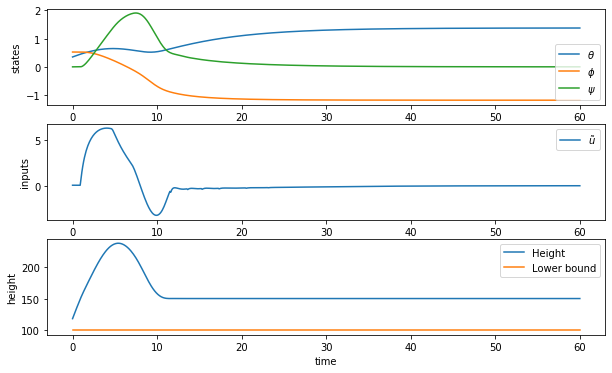

In [20]:
h=[]
for data in res_x_mpc.T:
    h.append([Length*sin(data[0])*cos(data[1])])
    
fig, ax = plt.subplots(3,1, figsize=(10,6))

ax[0].plot(np.linspace(0,60,res_x_mpc.T.shape[0]),res_x_mpc.T[:,0:3])
ax[0].legend([r'$\theta$',r'$\phi$',r'$\psi$'])

ax[1].plot(np.linspace(0,60,res_u_mpc.T.shape[0]),res_u_mpc.T)
ax[1].legend([r'$\tilde{u}$'])
ax[2].plot(np.linspace(0,60,len(h)),h)
ax[2].plot(np.linspace(0,60,res_u_mpc.T.shape[0]),100*np.ones(res_u_mpc.T.shape))
ax[2].legend(['Height','Lower bound'])

ax[0].set_ylabel('states')
ax[1].set_ylabel('inputs')
ax[2].set_ylabel('height')
ax[2].set_xlabel('time')

Text(0, 0.5, '$\\theta$')

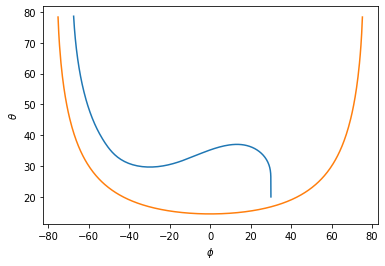

In [21]:
X=np.linspace(-90,90,500)
Y=arcsin(100/Length/cos(X/180*pi))
plt.plot(res_x_mpc.T[:,1]/np.pi*180,res_x_mpc.T[:,0]/np.pi*180)
plt.plot(X,Y/np.pi*180)
plt.xlabel(r'$\phi$')
plt.ylabel(r'$\theta$')

The average Tension is 68916.92N


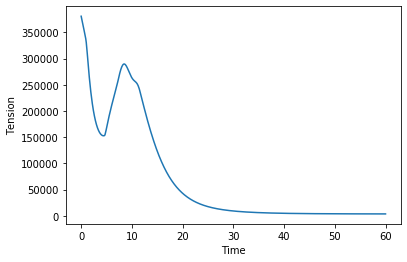

In [22]:
T=[]
sumT=0
t=np.linspace(0,60,res_u_mpc.T.shape[0])
for i in range(res_u_mpc.shape[1]):
    newT=Tf(res_x_mpc.T[i,:],res_u_mpc.T[i,:],t[0])
    T.append(newT)
    sumT+=newT

plt.plot(t,T)
plt.xlabel('Time')
plt.ylabel('Tension')
print('The average Tension is %.2fN' % np.mean(T))